# Contact Matrix Visualization

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import nafot
from tqdm import tqdm, tqdm_notebook
from matplotlib.patches import Rectangle
# plt.style.use('ggplot')
# plt.style.use('classic')

In [3]:
gdf = nafot.gdf.copy()

In [15]:
(gdf.DistrictCode.unique())

array([ 6.,  1.,  5.,  2.,  4.,  3., nan,  7.])

In [6]:
gdf.pop_thou[~gdf.pop_thou.isnull()].shape

(2299,)

In [16]:
se = pd.read_csv('./nafot/social_economic_status.csv')

In [27]:
se[~se.eshcol.isnull()].shape

(1866, 2)

## Loading the raw matrices - PASS IF ALREADY HAVE CONTACT MATRIX

In [2]:
#### Matrix A ####
gdf = nafot.gdf.copy()
matrix_A = np.load('../data/matrix/visit_matrix_raw_all.npy')

area = 'stat_area'
areas_ids = np.array(gdf.index.values)

matrix_A_df = pd.DataFrame(matrix_A, index=areas_ids, columns=areas_ids)

In [29]:
matrix_A_df.shape

(3070, 3070)

## Change matrix level to subdistricts

In [3]:
area_level = 'subdistrict'
hierarchical_list = nafot.get_hierarchical_list(area_level)

# Get codes column names in gdf
code_col_names = {'district': 'DistrictCode', 'subdistrict': 'SubDistrictCode', 'yeshuv': 'SEMEL_YISH'}

if area_level != 'stat_area':
    # If the level is not stat area, add the relevant level to the location data
    area_col = code_col_names[area_level] 

# Get a list of the area's ids
areas_ids = pd.unique(gdf[area_col])

# Remove NaN
areas_ids = np.array(areas_ids[~np.isnan(areas_ids)])

### Aggregate the columns


In [4]:
matrix_A_agg_cols_df = pd.DataFrame(index=matrix_A_df.index, columns=areas_ids)

for agg_area_id in areas_ids:
    matrix_A_agg_cols_df[agg_area_id] = matrix_A_df[hierarchical_list[agg_area_id]].sum(axis=1)

### Aggregate the rows

In [5]:
matrix_A_agg_df = pd.DataFrame(index=areas_ids, columns=areas_ids)

for agg_area_id in areas_ids:
    matrix_A_agg_df.loc[agg_area_id] = matrix_A_agg_cols_df.loc[hierarchical_list[agg_area_id]].sum()

### Remove Hadera, HaSharon, Be'er Sheva

In [6]:
matrix_A_agg_df.loc[[32,41,62]] = 0
matrix_A_agg_df.loc[:,[32,41,62]] = 0

### Create meeting matrix

In [7]:
#### Matrix A ####
visits_matrix_subdist = matrix_A_agg_df.values

meeting_matrix_subdist = nafot.visits_to_contact_matrix(visits_matrix_subdist, 'subdistrict')

Number of areas without population data (not home stat area): 0
Number of areas without population data (home stat area): 0


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 8020.66it/s]


In [8]:
v_mat = matrix_A_agg_df.drop([32,41,62,21,22,23,31,24,29],1).drop([32,41,62,21,22,23,31,24,29],0)
v_mat_norm = v_mat.divide(v_mat.sum(1), 'rows')
v_mat_norm

61.0       11.0       51.0        44.0       43.0       42.0  \
61.0    0.757331  0.0282067  0.0755226   0.0457918  0.0482263  0.0427821   
11.0   0.0134481   0.840619  0.0447276  0.00701006  0.0457406  0.0316201   
51.0    0.011631  0.0161294    0.84089  0.00974234  0.0355527  0.0845886   
44.0   0.0803148  0.0275674   0.147061    0.610261  0.0764886  0.0563194   
43.0   0.0202045  0.0376214   0.135352   0.0178889   0.694317  0.0901671   
42.0   0.0107208  0.0166119   0.146193  0.00620475  0.0405739    0.77629   
77.0  0.00931484   0.189236  0.0573276  0.00506934  0.0460081   0.108927   

            77.0  
61.0  0.00213941  
11.0   0.0168348  
51.0   0.0014659  
44.0   0.0019882  
43.0  0.00444942  
42.0  0.00340597  
77.0    0.584118

In [9]:
# Add subdist names
subdist_names = [nafot.subdistricts_names[i] for i in v_mat_norm.index]
v_mat_norm.columns = subdist_names
v_mat_norm.index = subdist_names
v_mat_norm

Ashkelon  Jerusalem   Tel Aviv     Rehovot      Ramla  \
Ashkelon           0.757331  0.0282067  0.0755226   0.0457918  0.0482263   
Jerusalem         0.0134481   0.840619  0.0447276  0.00701006  0.0457406   
Tel Aviv           0.011631  0.0161294    0.84089  0.00974234  0.0355527   
Rehovot           0.0803148  0.0275674   0.147061    0.610261  0.0764886   
Ramla             0.0202045  0.0376214   0.135352   0.0178889   0.694317   
Petah Tikva       0.0107208  0.0166119   0.146193  0.00620475  0.0405739   
Judea & Samaria  0.00931484   0.189236  0.0573276  0.00506934  0.0460081   

                Petah Tikva Judea & Samaria  
Ashkelon          0.0427821      0.00213941  
Jerusalem         0.0316201       0.0168348  
Tel Aviv          0.0845886       0.0014659  
Rehovot           0.0563194       0.0019882  
Ramla             0.0901671      0.00444942  
Petah Tikva         0.77629      0.00340597  
Judea & Samaria    0.108927        0.584118

In [10]:
# v_mat_norm = v_mat_norm[['Petah Tikva', 'Tel Aviv', 'Ramla', 'Rehovot', 'Ashkelon', 'Jerusalem', 'Judea & Samaria']].loc[['Petah Tikva', 'Tel Aviv', 'Ramla', 'Rehovot', 'Ashkelon','Jerusalem', 'Judea & Samaria']]
# v_mat_norm

#  Load existing contact matrix

In [14]:
meeting_matrix_subdist_2 = pd.read_csv('../data/matrix/contact_matrix_final_sample_subdist.csv')

In [15]:
meeting_matrix_subdist_2.set_index('Unnamed: 0', inplace=True)

In [16]:
# Add subdist names
subdist_names = [nafot.subdistricts_names[i] for i in meeting_matrix_subdist_2.index]
meeting_matrix_subdist_2.columns = subdist_names
meeting_matrix_subdist_2.index = subdist_names

In [18]:
meeting_matrix_subdist_2 = meeting_matrix_subdist_2[['Petah Tikva', 'Tel Aviv', 'Ramla', 'Rehovot', 'Ashkelon', 'Jerusalem', 'Judea & Samaria']].loc[['Petah Tikva', 'Tel Aviv', 'Ramla', 'Rehovot', 'Ashkelon','Jerusalem', 'Judea & Samaria']] = meeting_matrix_subdist[['Petah Tikva', 'Tel Aviv', 'Ramla', 'Rehovot', 'Ashkelon', 'Jerusalem', 'Judea & Samaria']].loc[['Petah Tikva', 'Tel Aviv', 'Ramla', 'Rehovot', 'Ashkelon','Jerusalem', 'Judea & Samaria']] = meeting_matrix_subdist[['Petah Tikva', 'Tel Aviv', 'Ramla', 'Rehovot', 'Ashkelon', 'Jerusalem', 'Judea & Samaria']].loc[['Petah Tikva', 'Tel Aviv', 'Ramla', 'Rehovot', 'Ashkelon','Jerusalem', 'Judea & Samaria']]

Add subdist names

In [8]:
# Add subdist names
subdist_names = [nafot.subdistricts_names[i] for i in meeting_matrix_subdist.index]
meeting_matrix_subdist.columns = subdist_names
meeting_matrix_subdist.index = subdist_names

Changing order according to geographical location of the subdistricts

In [9]:
meeting_matrix_subdist = meeting_matrix_subdist[['Petah Tikva', 'Tel Aviv', 'Ramla', 'Rehovot', 'Ashkelon', 'Jerusalem', 'Judea & Samaria']].loc[['Petah Tikva', 'Tel Aviv', 'Ramla', 'Rehovot', 'Ashkelon','Jerusalem', 'Judea & Samaria']]

In [10]:
meeting_matrix_subdist

Petah Tikva  Tel Aviv     Ramla   Rehovot  Ashkelon  \
Petah Tikva         0.717374  0.191254  0.031390  0.011678  0.014119   
Tel Aviv            0.078006  0.842726  0.024406  0.018574  0.013534   
Ramla               0.108083  0.204491  0.542828  0.035221  0.032168   
Rehovot             0.055326  0.178059  0.050985  0.582011  0.092809   
Ashkelon            0.037704  0.083731  0.029304  0.050444  0.761168   
Jerusalem           0.024000  0.043140  0.024010  0.006939  0.012508   
Judea & Samaria     0.100636  0.070213  0.030309  0.006843  0.010931   

                 Jerusalem  Judea & Samaria  
Petah Tikva       0.024091         0.010094  
Tel Aviv          0.019840         0.002913  
Ramla             0.067904         0.009305  
Rehovot           0.037535         0.003275  
Ashkelon          0.034743         0.002906  
Jerusalem         0.863647         0.025755  
Judea & Samaria   0.245904         0.535164

## Create Heat map

### Finding clusters

In [11]:
print('Cluster of size 2 are:')
for i in range(5+1):
    temp_mat = meeting_matrix_subdist.values[:,i:i+2][i:i+2]
    if ((temp_mat - np.diag(temp_mat.diagonal())).sum()/2) > 0.09:
        print (np.array(meeting_matrix_subdist.columns)[np.arange(i,i+2)])

Cluster of size 2 are:
[51. 44.]


In [12]:
print('Cluster of size 3 are:')
for i in range(4+1): 
    temp_mat = meeting_matrix_subdist.values[:,i:i+3][i:i+3]
    if (temp_mat - np.diag(temp_mat.diagonal())).sum()/6 > 0.1:
        print (np.array(meeting_matrix_subdist.columns)[np.arange(i,i+3)])

Cluster of size 3 are:


In [13]:
print('Cluster of size 4 are:')
for i in range(3+1): 
    temp_mat = meeting_matrix_subdist.values[:,i:i+4][i:i+4]
    if (temp_mat - np.diag(temp_mat.diagonal())).sum()/12 > 0.1:
        print (np.array(meeting_matrix_subdist.columns)[np.arange(i,i+4)])

Cluster of size 4 are:


### Subdistrict Heat Map

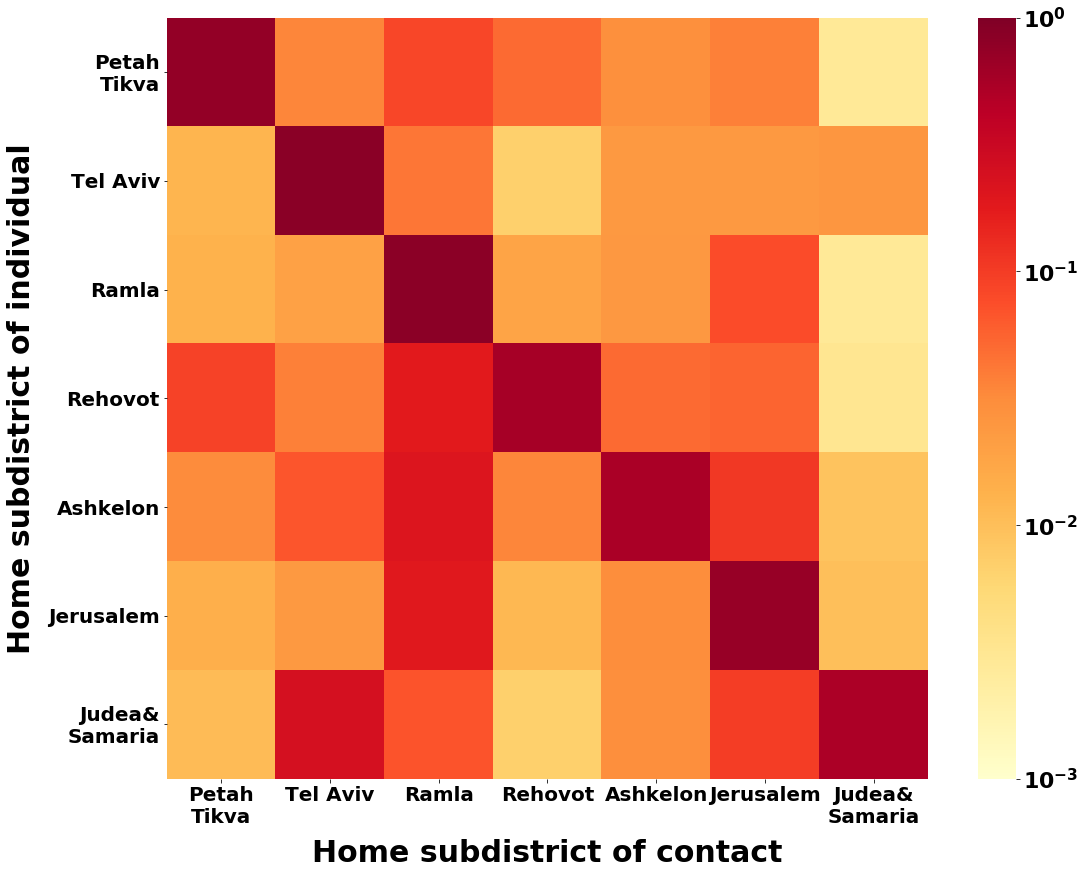

In [15]:
# Log transformation
meeting_mat_subdist_log_df = meeting_matrix_subdist.applymap(lambda x: np.log10(x))

# x,y axis ticks labels
labels = ['Petah\nTikva', 'Tel Aviv', 'Ramla', 'Rehovot', 'Ashkelon', 'Jerusalem', 'Judea&\nSamaria']

# creating the figure and setting the figure size
fig, ax = plt.subplots(figsize=(18,14))

# Make all bold
plt.rc('font', weight='bold')

# Setting the figure title
# ax.set_title('Contact Probability Heat Map', {'fontsize': 25, 'position': (0.5,1.02)})

# Creating the heatmap with seaborn heatmap object
# heat = sns.heatmap(meeting_mat_subdist_log_df, ax=ax, cmap='YlOrRd', robust=False, vmin=-3, vmax=0,
#                    annot=meeting_matrix_subdist, annot_kws={'fontsize': 20, 'fontweight': 'bold'},
#                    cbar_kws={'ticks':np.linspace(-3,0, 4)}, square=True, xticklabels=labels, yticklabels=labels)

heat = sns.heatmap(meeting_mat_subdist_log_df, ax=ax, cmap='YlOrRd', robust=False, vmin=-3, vmax=0,
                   cbar_kws={'ticks':np.linspace(-3,0, 4)}, square=True, xticklabels=labels, yticklabels=labels)

# Setting the oreintation of the ticks label
ax.tick_params(labelsize=20)
plt.xticks(rotation='horizontal')
plt.yticks(rotation='horizontal')

# Add axis labels
plt.ylabel('Home subdistrict of individual', fontsize=30, fontweight='bold', labelpad=12)
plt.xlabel('Home subdistrict of contact', fontsize=30, fontweight='bold', labelpad=12)

# Setting the color bar ticks labels
cb = fig.axes[1]
cb.set_yticklabels([f'$10^{"{"+str(int(i))+"}"}$' for i in np.linspace(-3,0, 4)], fontsize=22)

# Save - without clusters
# plt.savefig('../img/contact_heatmap_bold_no_annot.png', bbox_inches="tight")

# Mark the clusters using horizontal and vertical lines - the first parameters sets the location of the lines
# The other parameters sets the style of the lines (color, width and dashing)
# plt.vlines([3,5], [0,5], [3,7], colors='white', **{'linewidth': 3.5}, linestyles='dashed')
# plt.hlines([3,5], [0,5], [3,7], colors='white', **{'linewidth': 3.5}, linestyles='dashed')

# Save - with clusters
# plt.savefig('../img/contact_heatmap - with clusters.png', bbox_inches="tight")
plt.show()

visit matrix

In [32]:
v_mat_norm

Ashkelon  Jerusalem   Tel Aviv     Rehovot      Ramla  \
Ashkelon           0.757331  0.0282067  0.0755226   0.0457918  0.0482263   
Jerusalem         0.0134481   0.840619  0.0447276  0.00701006  0.0457406   
Tel Aviv           0.011631  0.0161294    0.84089  0.00974234  0.0355527   
Rehovot           0.0803148  0.0275674   0.147061    0.610261  0.0764886   
Ramla             0.0202045  0.0376214   0.135352   0.0178889   0.694317   
Petah Tikva       0.0107208  0.0166119   0.146193  0.00620475  0.0405739   
Judea & Samaria  0.00931484   0.189236  0.0573276  0.00506934  0.0460081   

                Petah Tikva Judea & Samaria  
Ashkelon          0.0427821      0.00213941  
Jerusalem         0.0316201       0.0168348  
Tel Aviv          0.0845886       0.0014659  
Rehovot           0.0563194       0.0019882  
Ramla             0.0901671      0.00444942  
Petah Tikva         0.77629      0.00340597  
Judea & Samaria    0.108927        0.584118

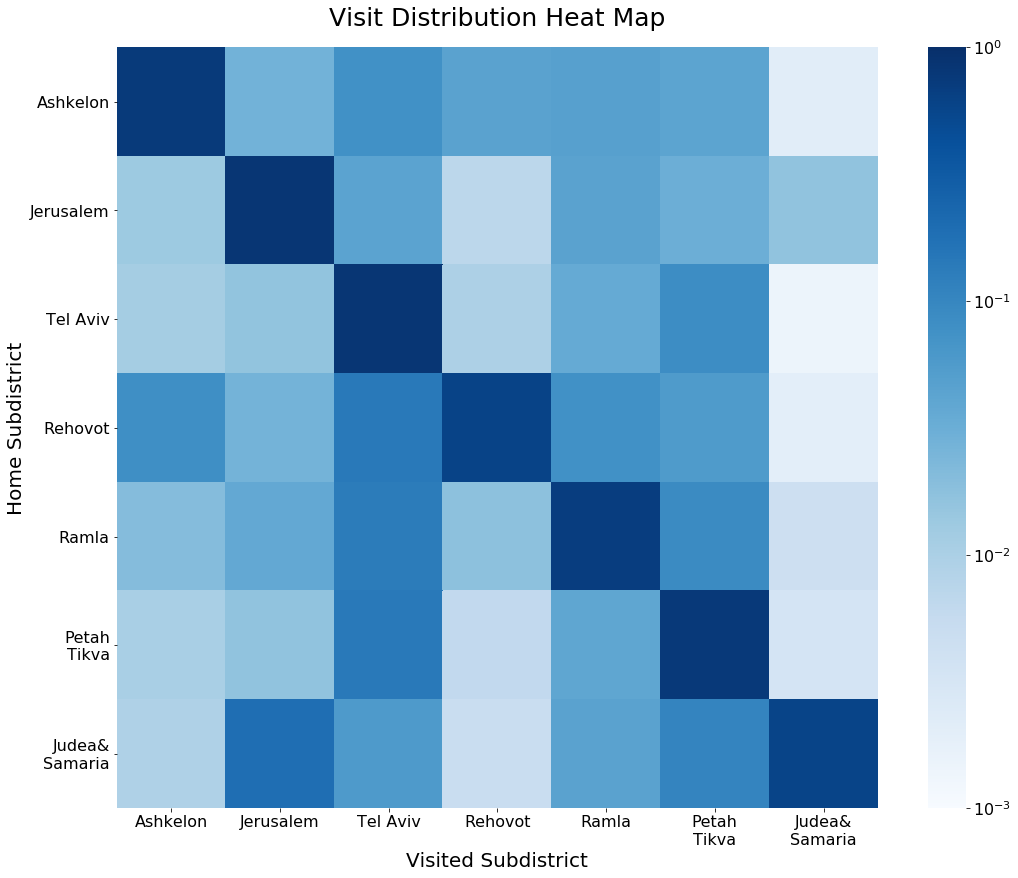

In [31]:
# Log transformation
# meeting_mat_subdist_log_df = meeting_matrix_subdist.applymap(lambda x: np.log10(x))
meeting_mat_subdist_log_df = v_mat_norm.applymap(lambda x: np.log10(x))


# x,y axis ticks labels
# labels = ['Petah\nTikva', 'Tel Aviv', 'Ramla', 'Rehovot', 'Ashkelon', 'Jerusalem', 'Judea&\nSamaria']
labels = ['Ashkelon', 'Jerusalem',  'Tel Aviv', 'Rehovot', 'Ramla', 'Petah\nTikva', 'Judea&\nSamaria']

# creating the figure and setting the figure size
fig, ax = plt.subplots(figsize=(18,14))

# Setting the figure title
ax.set_title('Visit Distribution Heat Map', {'fontsize': 25, 'position': (0.5,1.02)})

# # Creating the heatmap with seaborn heatmap object
# heat = sns.heatmap(meeting_mat_subdist_log_df, ax=ax, cmap='YlOrRd', robust=False, vmin=-3, vmax=0,
#                    annot=meeting_matrix_subdist, annot_kws={'fontsize': 16},
#                    cbar_kws={'ticks':np.linspace(-3,0, 4)}, square=True, xticklabels=labels, yticklabels=labels)

# Creating the heatmap with seaborn heatmap object
heat = sns.heatmap(meeting_mat_subdist_log_df, ax=ax, cmap='Blues', robust=False, vmin=-3, vmax=0,
                   cbar_kws={'ticks':np.linspace(-3,0, 4)}, square=True, xticklabels=labels, yticklabels=labels)

# Setting the oreintation of the ticks label
ax.tick_params(labelsize=16)
plt.xticks(rotation='horizontal')
plt.yticks(rotation='horizontal')

# Add axis labels
plt.ylabel('Home Subdistrict', fontsize=20)
plt.xlabel('Visited Subdistrict', fontsize=20)

# Setting the color bar ticks labels
cb = fig.axes[1]
cb.set_yticklabels([f'$10^{"{"+str(int(i))+"}"}$' for i in np.linspace(-3,0, 4)], fontsize=16)

# Save - without clusters
plt.savefig('../img/visit_heatmap2.png', bbox_inches="tight")

# Mark the clusters using horizontal and vertical lines - the first parameters sets the location of the lines
# The other parameters sets the style of the lines (color, width and dashing)
# plt.vlines([3,5], [0,5], [3,7], colors='white', **{'linewidth': 3.5}, linestyles='dashed')
# plt.hlines([3,5], [0,5], [3,7], colors='white', **{'linewidth': 3.5}, linestyles='dashed')

# Save - with clusters
# plt.savefig('../img/contact_heatmap - with clusters.png', bbox_inches="tight")
plt.show()

### Subdistrict Heat Map - without log

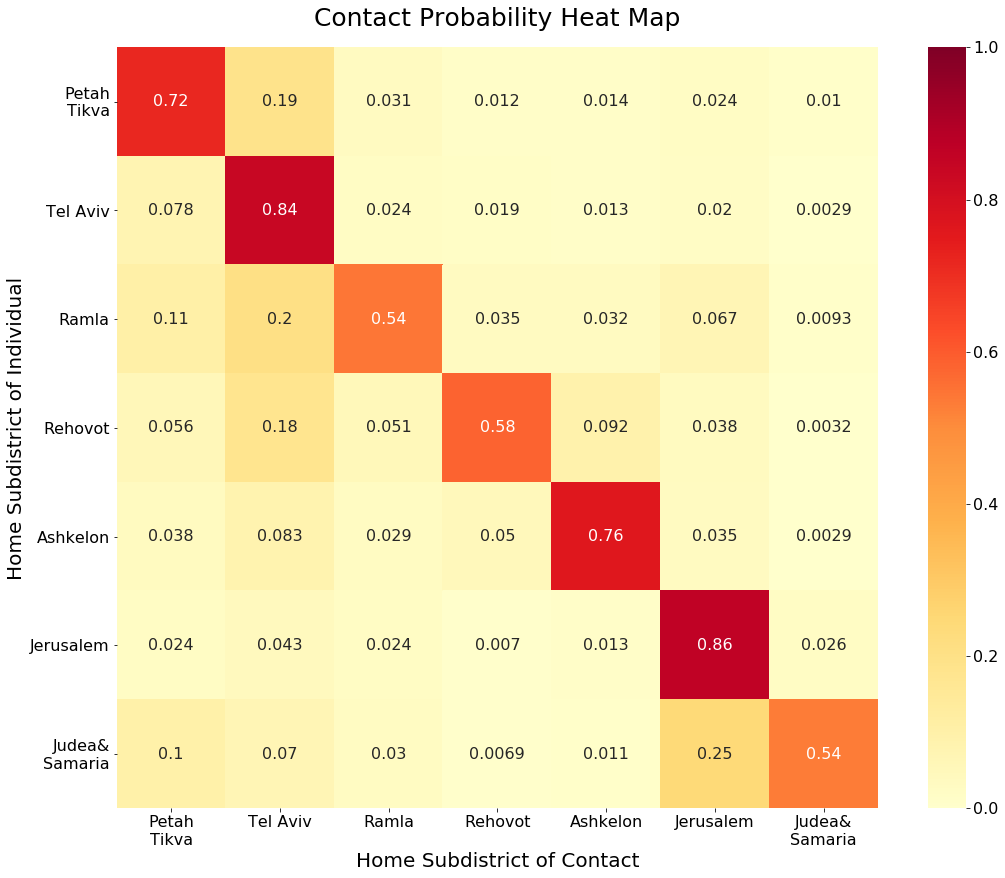

In [17]:
# Log transformation
meeting_mat_subdist_log_df = meeting_matrix_subdist

labels = ['Petah\nTikva', 'Tel Aviv', 'Ramla', 'Rehovot', 'Ashkelon', 'Jerusalem', 'Judea&\nSamaria']

fig, ax = plt.subplots(figsize=(18,14))
ax.set_title('Contact Probability Heat Map', {'fontsize': 25, 'position': (0.5,1.02)})
heat = sns.heatmap(meeting_mat_subdist_log_df, ax=ax, cmap='YlOrRd', robust=False, vmin=0, vmax=1,
                   annot=meeting_matrix_subdist, annot_kws={'fontsize': 16},
                   cbar_kws={'ticks':np.linspace(0,1,6)}, square=True, xticklabels=labels, yticklabels=labels)

# Ticks
ax.tick_params(labelsize=16)
plt.xticks(rotation='horizontal')
plt.yticks(rotation='horizontal')

# Axis labels
plt.ylabel('Home Subdistrict of Individual', fontsize=20)
plt.xlabel('Home Subdistrict of Contact', fontsize=20)

# Color bar
cb = fig.axes[1]
cb.set_yticklabels(np.linspace(0,1,6), fontsize=16)

# Save - without log
plt.savefig('../img/contact_heatmap - withoutlog.png', bbox_inches="tight")
plt.show()

## Multiplying the matrix by itself

In [16]:
mat = meeting_matrix_subdist.values
meeting_matrix_subdist_norm_2steps = pd.DataFrame(np.linalg.matrix_power(mat, 2), columns=meeting_matrix_subdist.columns,
                                                  index=meeting_matrix_subdist.index)
meeting_matrix_subdist_norm_3steps = pd.DataFrame(np.linalg.matrix_power(mat, 3), columns=meeting_matrix_subdist.columns,
                                                  index=meeting_matrix_subdist.index)
meeting_matrix_subdist_norm_steady_state = pd.DataFrame(np.linalg.matrix_power(mat, 100000),
                                                        columns=meeting_matrix_subdist.columns).iloc[0:1]

### Subdistrict Heat Map - Steady State - Subdistrict Centrality

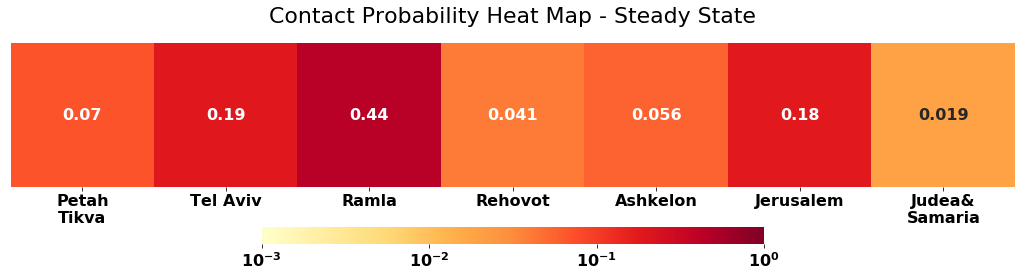

In [17]:
############### Steady state
meeting_mat_subdist_log_df_ss = meeting_matrix_subdist_norm_steady_state.applymap(lambda x: np.log10(x))

labels = ['Petah\nTikva', 'Tel Aviv', 'Ramla', 'Rehovot', 'Ashkelon', 'Jerusalem', 'Judea&\nSamaria']

fig, ax = plt.subplots(figsize=(18,5))
ax.set_title('Contact Probability Heat Map - Steady State', {'fontsize': 22, 'position': (0.5,1.1)})
heat = sns.heatmap(meeting_mat_subdist_log_df_ss, ax=ax, cmap='YlOrRd', robust = True, xticklabels=labels,
                   yticklabels='', vmin=-3, vmax=0, annot=meeting_matrix_subdist_norm_steady_state,
                  annot_kws={'fontsize': 16}, cbar_kws={'ticks':np.linspace(-3,0, 4), "orientation": "horizontal",
                                                        'shrink':0.5, 'aspect':30}, square=True)
ax.tick_params(labelsize=16)

# Color bar
cb = fig.axes[1]
cb.set_xticklabels([f'$10^{"{"+str(int(i))+"}"}$' for i in np.linspace(-3,0, 4)], fontsize=16)

plt.xticks(rotation='horizontal')

# plt.savefig('./img/contact_heatmap - steady state.png', bbox_inches="tight")
plt.show()

### Subdistrict Heat Map - Steady State - Subdistrict Centrality - Sorted

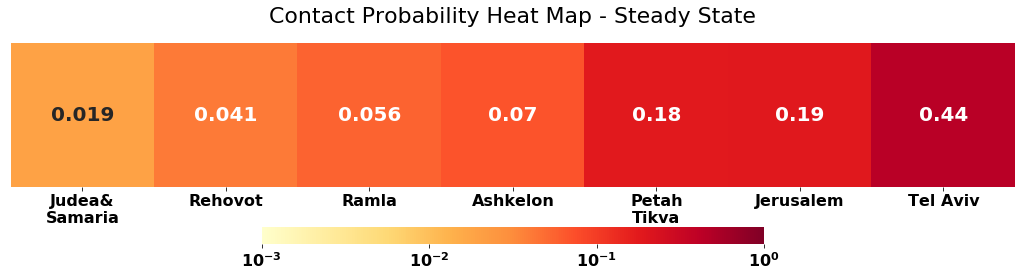

In [38]:
############### Steady state
meeting_matrix_subdist_norm_steady_state_sorted = meeting_matrix_subdist_norm_steady_state.sort_values(0, axis=1)
meeting_mat_subdist_log_df_ss_sorted = meeting_matrix_subdist_norm_steady_state_sorted.applymap(lambda x: np.log10(x))

labels = ['Judea&\nSamaria', 'Rehovot', 'Ramla',
       'Ashkelon', 'Petah\nTikva', 'Jerusalem', 'Tel Aviv']


fig, ax = plt.subplots(figsize=(18,5))
ax.set_title('Contact Probability Heat Map - Steady State', {'fontsize': 22, 'position': (0.5,1.1)})
heat = sns.heatmap(meeting_mat_subdist_log_df_ss_sorted, ax=ax, cmap='YlOrRd', robust = True, xticklabels=labels,
                   yticklabels='', vmin=-3, vmax=0, annot=meeting_matrix_subdist_norm_steady_state_sorted,
                  annot_kws={'fontsize': 20}, cbar_kws={'ticks':np.linspace(-3,0, 4), "orientation": "horizontal",
                                                        'shrink':0.5, 'aspect':30}, square=True)
ax.tick_params(labelsize=16)

# Color bar
cb = fig.axes[1]
cb.set_xticklabels([f'$10^{"{"+str(int(i))+"}"}$' for i in np.linspace(-3,0, 4)], fontsize=16)

plt.xticks(rotation='horizontal')

# plt.savefig('../img/contact_heatmap - steady state sorted.png', bbox_inches="tight")
plt.show()

### Subdistrict Centrality - w.r.t population size

In [45]:
pop = gdf.groupby('SubDistrictCode').sum()['pop_thou'].loc[[61,11,51,44,43,42,77]]
pop = pop / pop.sum()
subdist_wrt_pop_size = meeting_matrix_subdist_norm_steady_state / pop.values

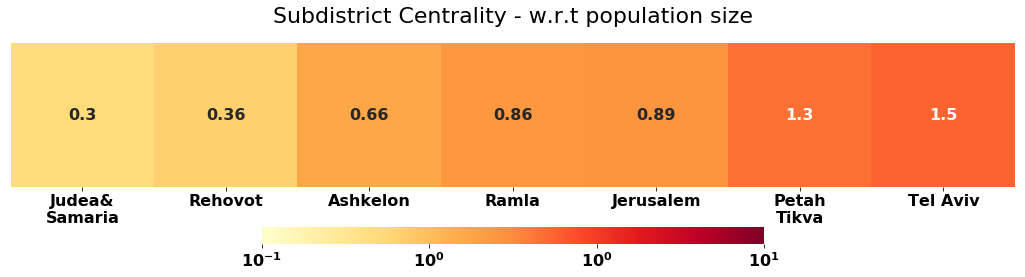

In [48]:
############### Steady state
subdist_wrt_pop_size_sorted = subdist_wrt_pop_size.sort_values(0, axis=1)
subdist_wrt_pop_size_sorted_log_df = subdist_wrt_pop_size_sorted.applymap(lambda x: np.log10(x))

labels = ['Judea&\nSamaria', 'Rehovot', 'Ashkelon', 'Ramla', 'Jerusalem', 'Petah\nTikva', 'Tel Aviv']

fig, ax = plt.subplots(figsize=(18,5))
ax.set_title('Subdistrict Centrality - w.r.t population size', {'fontsize': 22, 'position': (0.5,1.1)})
heat = sns.heatmap(subdist_wrt_pop_size_sorted_log_df, ax=ax, cmap='YlOrRd', robust = True, xticklabels=labels,
                   yticklabels='', vmin=-1, vmax=1, annot=subdist_wrt_pop_size_sorted,
                  annot_kws={'fontsize': 16}, cbar_kws={'ticks':np.linspace(-1,1, 4), "orientation": "horizontal",
                                                        'shrink':0.5, 'aspect':30}, square=True)
ax.tick_params(labelsize=16)

# Color bar
cb = fig.axes[1]
cb.set_xticklabels([f'$10^{"{"+str(int(i))+"}"}$' for i in np.linspace(-1,1, 4)], fontsize=16)

plt.xticks(rotation='horizontal')

# plt.savefig('../img/Subdistrict Centrality - w.r.t population size.png', bbox_inches="tight")
plt.show()

## Subdistrict Centrality - according to the steady state

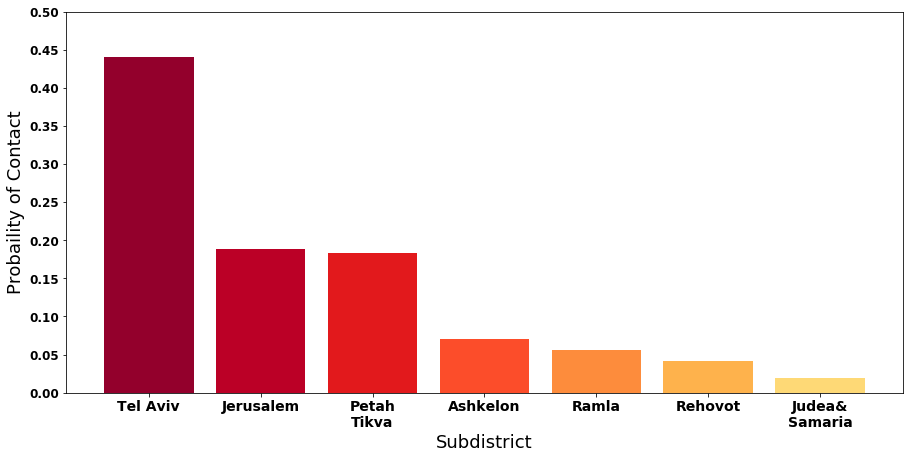

In [22]:
sorted_meeting_steady_state = meeting_matrix_subdist_norm_steady_state.sort_values(0, axis=1, ascending=False)
sorted_meeting_steady_state.columns = ['Tel Aviv', 'Jerusalem', 'Petah\nTikva', 'Ashkelon', 'Ramla', 'Rehovot','Judea&\nSamaria']

xs = np.arange(1,7+1)
vals = sorted_meeting_steady_state.values[0]
colors = ['#93002c', '#bb0026', '#e2191c', '#fc4d2a', '#fd8c3c', '#feb24c', '#fed976','#ffeda0', '#ffffcc']

fig = plt.figure(figsize=(15,7))
plt.bar(xs, vals, color=colors)

# plt.title('Subdistrict Centrality', fontsize=20)
plt.xlabel('Subdistrict', fontsize=18)
plt.ylabel('Probaility of Contact', fontsize=18)

plt.xticks(xs, sorted_meeting_steady_state.columns, fontsize=14)
plt.yticks(np.arange(0,0.5+0.05,0.05), fontsize=12)

plt.ylim([0,0.5])

# Add labels on the bars
# for x, y in zip(np.arange(0.65,9) ,vals):
#     plt.text(x+0.12, y + 0.01, '{:.3f}'.format(y), color='black', fontweight='bold', fontsize=13)

# plt.savefig('../img/subdistrict cenrtrality updated regular style.png', bbox_inches="tight")
plt.show()

### Comparison to reltaive population size

In [24]:
sorted_meeting_steady_state

Tel Aviv  Jerusalem  Petah\nTikva  Ashkelon     Ramla   Rehovot  \
0  0.440996   0.188338      0.183545  0.070261  0.056419  0.041396   

   Judea&\nSamaria  
0         0.019045

In [26]:
subdist_wrt_pop_size_sorted

77.0      44.0      61.0      43.0      11.0      42.0      51.0
0  0.298719  0.357738  0.497854  0.531933  0.634079  0.869996  6.749511

In [27]:
subdist_wrt_pop_size_sorted = 0

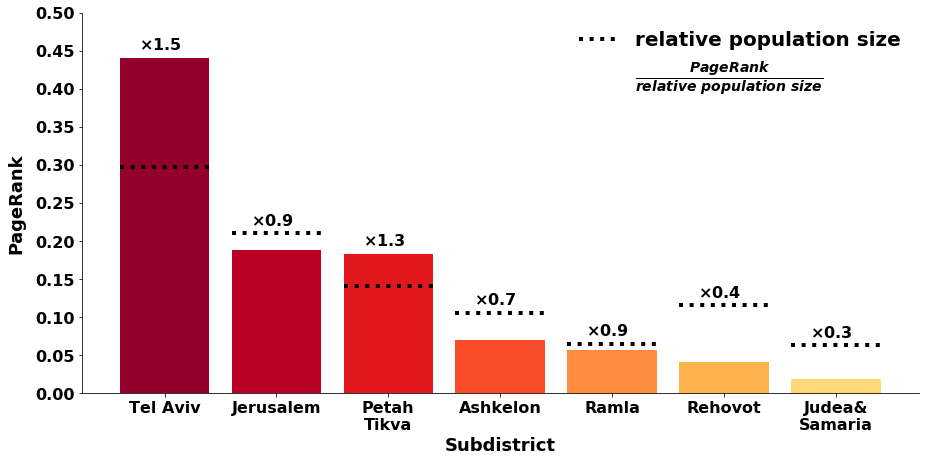

In [64]:
sorted_meeting_steady_state = meeting_matrix_subdist_norm_steady_state.sort_values(0, axis=1, ascending=False)
sorted_meeting_steady_state.columns = ['Tel Aviv', 'Jerusalem', 'Petah\nTikva', 'Ashkelon', 'Ramla', 'Rehovot','Judea&\nSamaria']

# subdist_wrt_pop_size_sorted.columns = [nafot.subdistricts_names[code] for code in subdist_wrt_pop_size_sorted.columns]
subdist_wrt_pop_size_sorted = subdist_wrt_pop_size_sorted[['Tel Aviv', 'Jerusalem', 'Petah Tikva', 'Ashkelon', 'Ramla',
                                                           'Rehovot','Judea & Samaria']]
# population propotion
pop_prop = pop[[51,11,42,61,43,44,77]].values

# Setting the x-location of the bars
xs = np.arange(1,7+1)

# Setting the values of the bars (hights)
vals = sorted_meeting_steady_state.values[0]

# Setting the colors of the bars
colors = ['#93002c', '#bb0026', '#e2191c', '#fc4d2a', '#fd8c3c', '#feb24c', '#fed976','#ffeda0', '#ffffcc']

# Creating the figure
fig, ax = plt.subplots(figsize=(15,7))


# Plotting the bar with the x-locations, bar hights and colors above 
plt.bar(xs, vals, color=colors)

# plt.title('Subdistrict Centrality', fontsize=20)

# Setting the x,y axis labels
plt.xlabel('Subdistrict', fontsize=18, fontweight='bold')
plt.ylabel('PageRank', fontsize=18, fontweight='bold', labelpad=10)

# Setting the x,y ticks location and label size
plt.xticks(xs, sorted_meeting_steady_state.columns, fontsize=16)
plt.yticks(np.arange(0,0.5+0.05,0.05), fontsize=16)

# Setting the limits of the y axis
plt.ylim([0,0.5])

# Plotting the dotted lines representing the relative population size using horizontal lines object
# The first 3 parameters sets the lines vertical and horizontal location
# The rest of the parameters sets the lines style (color, width)
# The label parameter will be used in for the legend
lines = plt.hlines(pop_prop, xs-0.4,xs+0.4, linestyles='dotted', color='black', **{'linewidth': 4},
           label='relative population size')

# Adding a legend
extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
legend = plt.legend([lines, extra], ['relative population size',
                                            r'$\frac{PageRank}{relative \ population \ size}$']
                    ,loc='upper right', fontsize=20, frameon=False)

# Add labels on the bars using text object
# The first 2 parameter sets the x,y location of the text
# The next parameters sets the text and its style (color, font weight and size)
for x, y, z in zip(np.arange(0.65,9) ,subdist_wrt_pop_size_sorted.values[0], np.maximum(pop_prop, vals)):
    plt.text(x+0.12, z + 0.01, f'$\\times${y:.1f}', color='black', fontweight='bold', fontsize=16)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)    

# plt.savefig('../img/subdistrict cenrtrality - enhanced regular style.png', bbox_inches="tight")
plt.savefig('../img/subdistrict cenrtrality bold.png', bbox_inches="tight")

plt.show()

## PageRank

In [143]:
a = meeting_matrix_subdist.values - np.diag(np.diagonal(meeting_matrix_subdist.values))
a_df = pd.DataFrame(a, columns=meeting_matrix_subdist.columns, index=meeting_matrix_subdist.index)
a_df

Petah Tikva  Tel Aviv     Ramla   Rehovot  Ashkelon  \
Petah Tikva         0.000000  0.191006  0.031357  0.011729  0.014086   
Tel Aviv            0.077826  0.000000  0.024403  0.018581  0.013476   
Ramla               0.107821  0.204490  0.000000  0.035055  0.032011   
Rehovot             0.055833  0.178267  0.050934  0.000000  0.092088   
Ashkelon            0.037568  0.083076  0.028948  0.050383  0.000000   
Jerusalem           0.023967  0.042904  0.024039  0.006981  0.012580   
Judea & Samaria     0.100557  0.070038  0.030445  0.006909  0.011005   

                 Jerusalem  Judea & Samaria  
Petah Tikva       0.024055         0.010066  
Tel Aviv          0.019744         0.002913  
Ramla             0.067263         0.009320  
Rehovot           0.037558         0.003198  
Ashkelon          0.034819         0.002909  
Jerusalem         0.000000         0.025720  
Judea & Samaria   0.246034         0.000000

In [145]:
ss = sorted_meeting_steady_state.copy()
ss.columns = ['Tel Aviv', 'Jerusalem', 'Petah Tikva', 'Ashkelon', 'Ramla', 'Rehovot', 'Judea & Samaria']
sss = {key: ss[key].values[0] for key in ss.columns}
sss

{'Ashkelon': 0.070381287960112657,
 'Jerusalem': 0.1880107022805671,
 'Judea & Samaria': 0.018993048255433905,
 'Petah Tikva': 0.18349694794384214,
 'Ramla': 0.0565092486132618,
 'Rehovot': 0.041448228392352723,
 'Tel Aviv': 0.44116053656094895}

In [153]:
meeting_matrix_subdist.columns

Index(['Petah Tikva', 'Tel Aviv', 'Ramla', 'Rehovot', 'Ashkelon', 'Jerusalem',
       'Judea & Samaria'],
      dtype='object')

{0: 0.183492914122903,
 1: 0.4411476377915216,
 2: 0.0565091008423128,
 3: 0.04144750743965315,
 4: 0.07038058746641022,
 5: 0.18802807385087733,
 6: 0.01899417848632156}

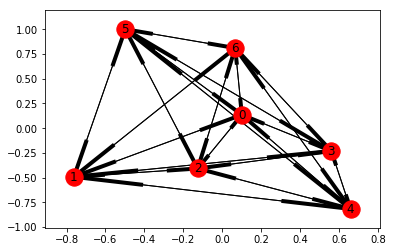

In [194]:
import networkx as nx
# G = nx.from_pandas_adjacency(meeting_matrix_subdist, create_using=nx.DiGraph())
G = nx.from_numpy_matrix(meeting_matrix_subdist.values, create_using=nx.DiGraph())

nx.drawing.nx_pylab.draw_networkx(G)

pageranks = nx.pagerank(G, alpha=1)
pageranks

## Create GIF - from 1 step to steady state

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


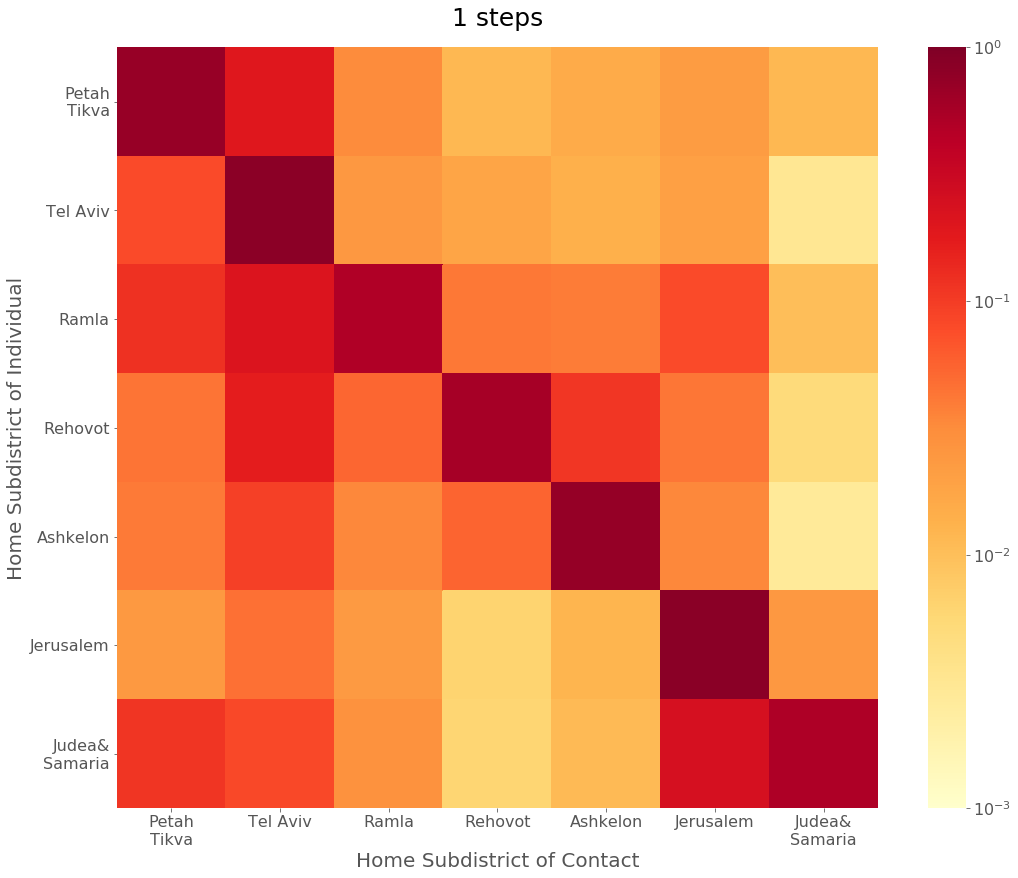

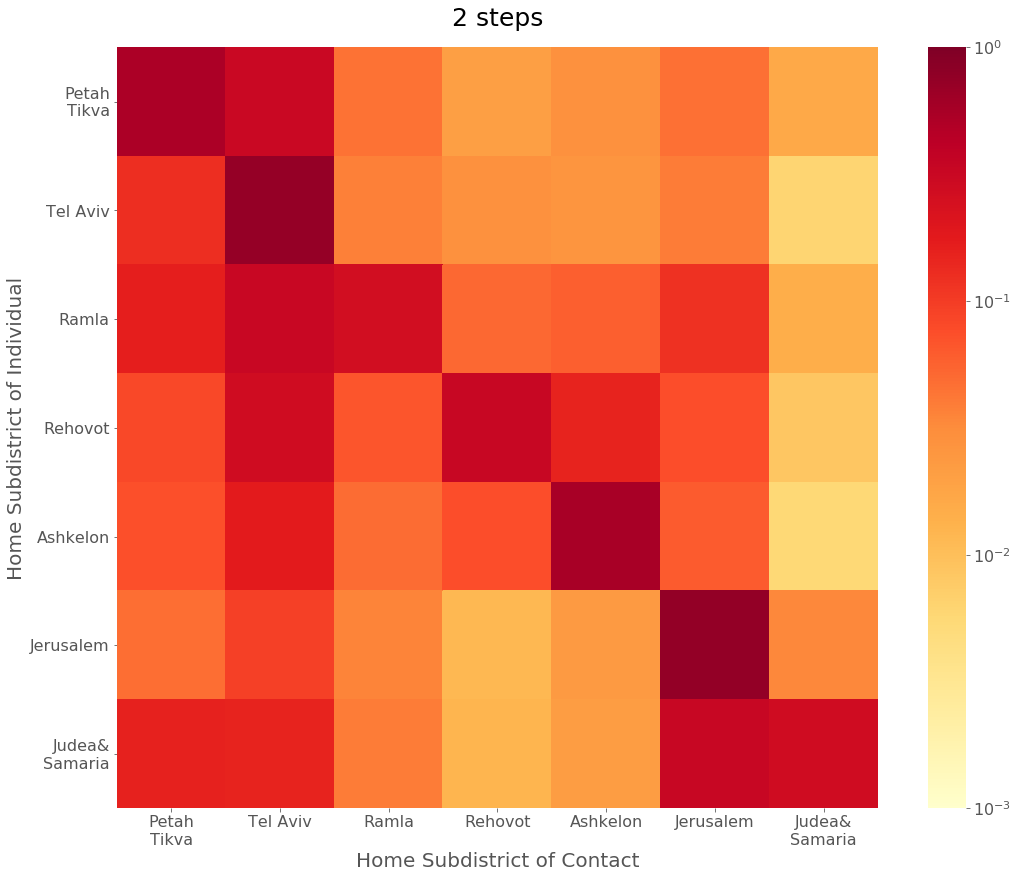

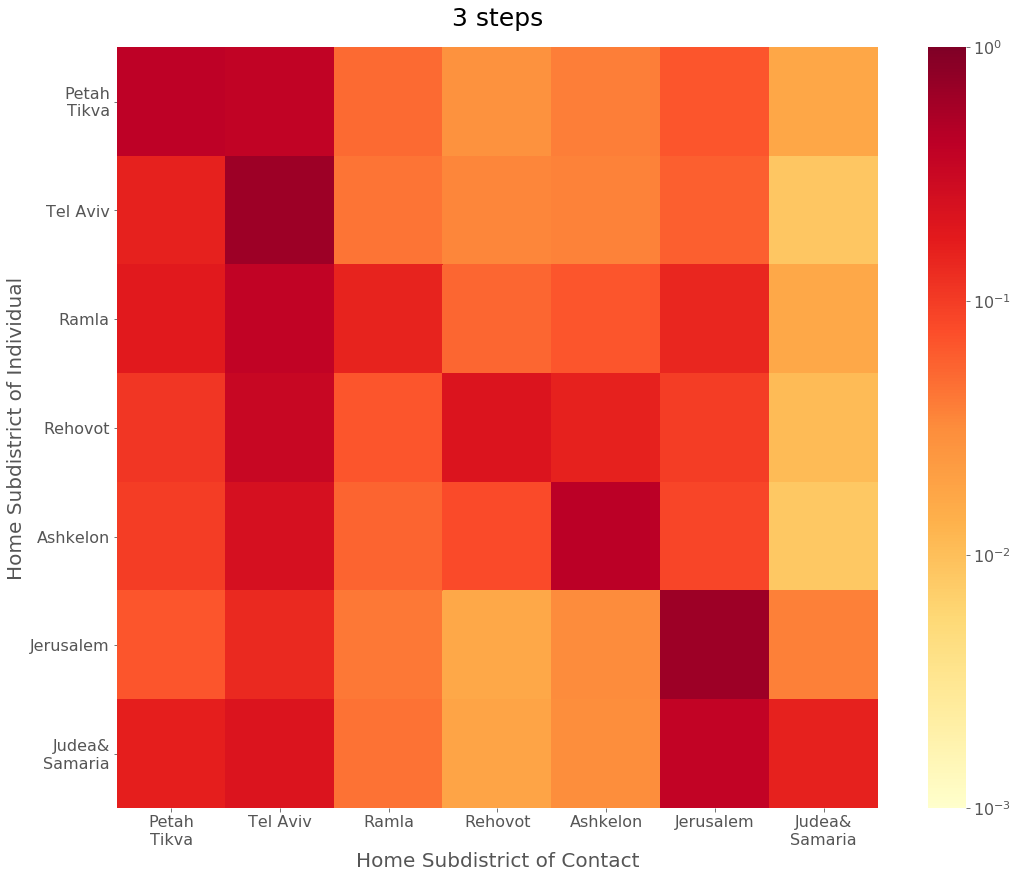

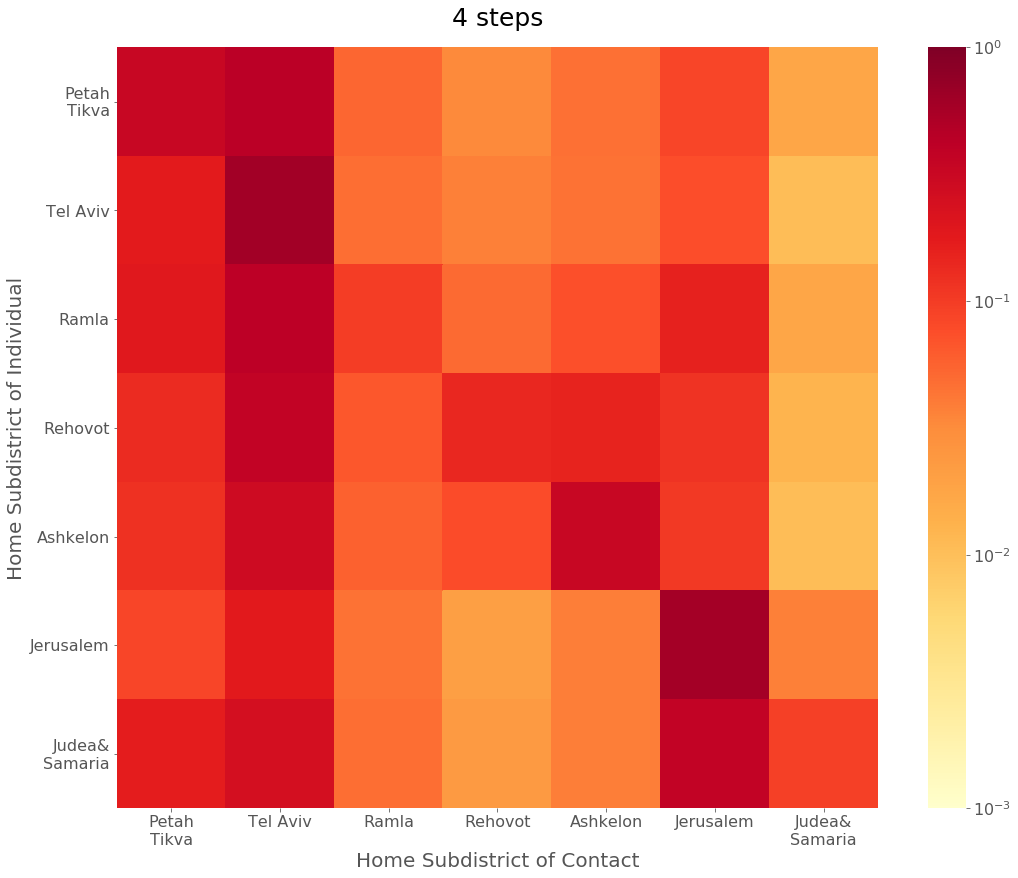

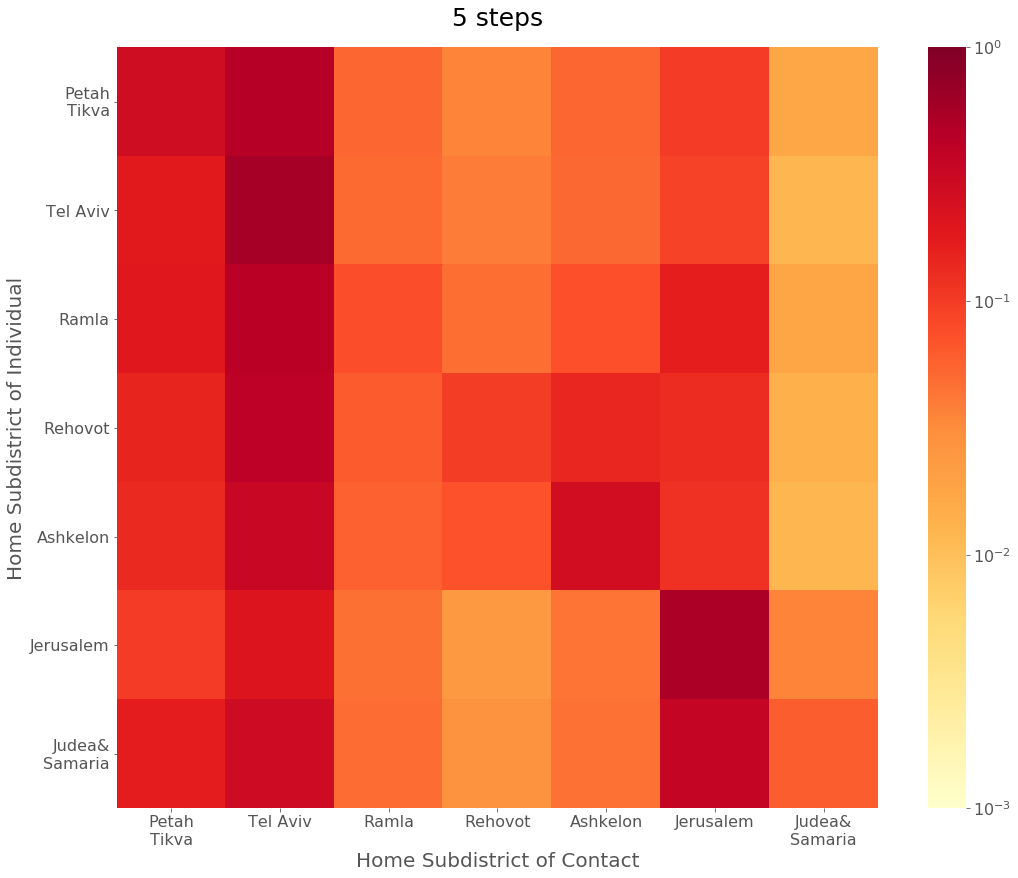

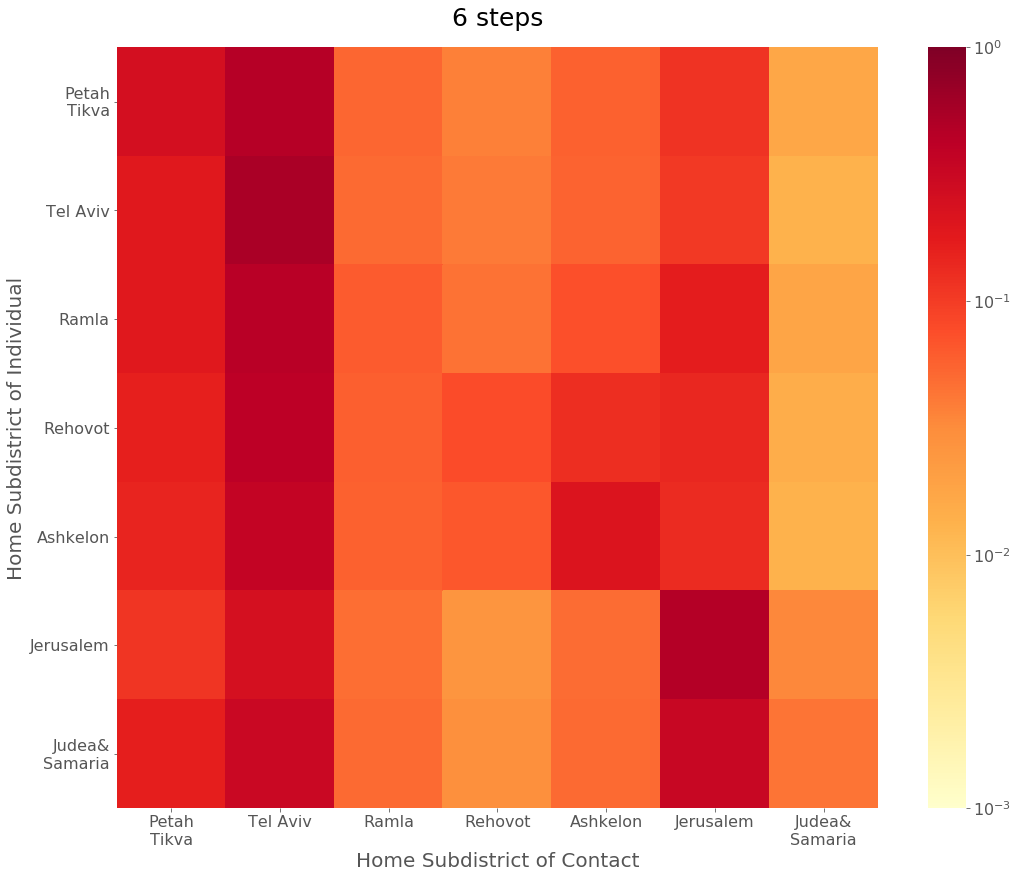

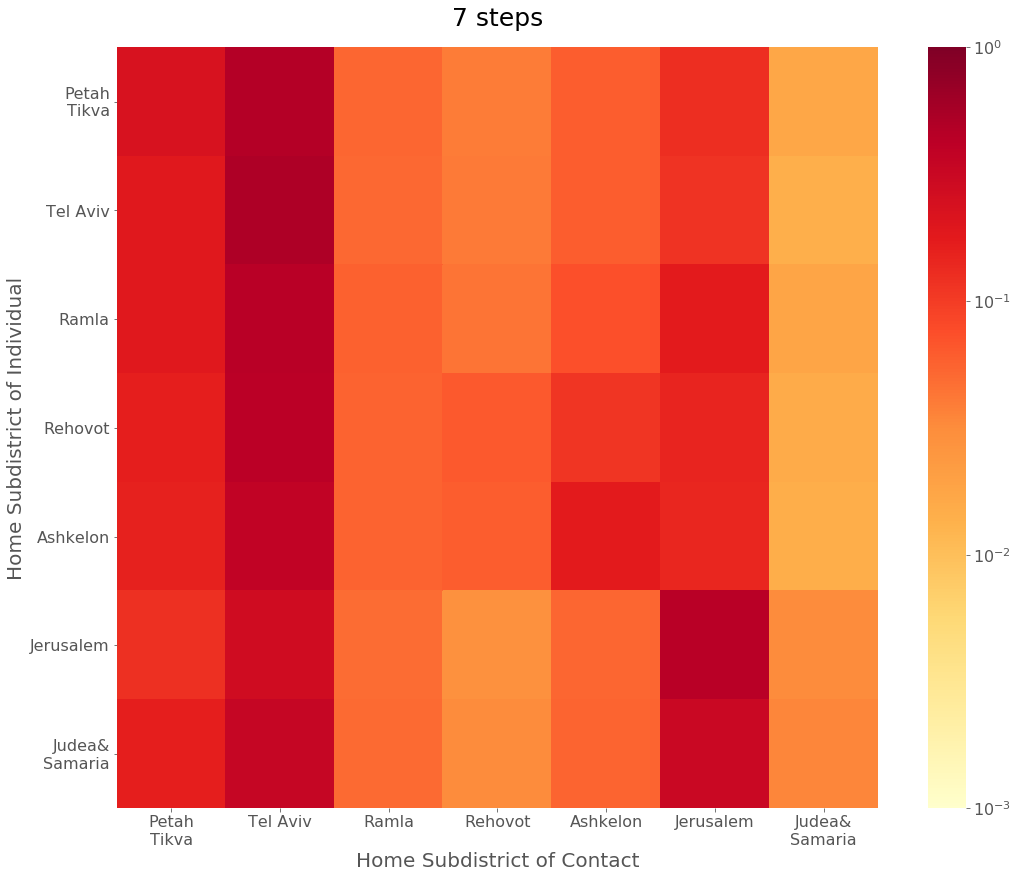

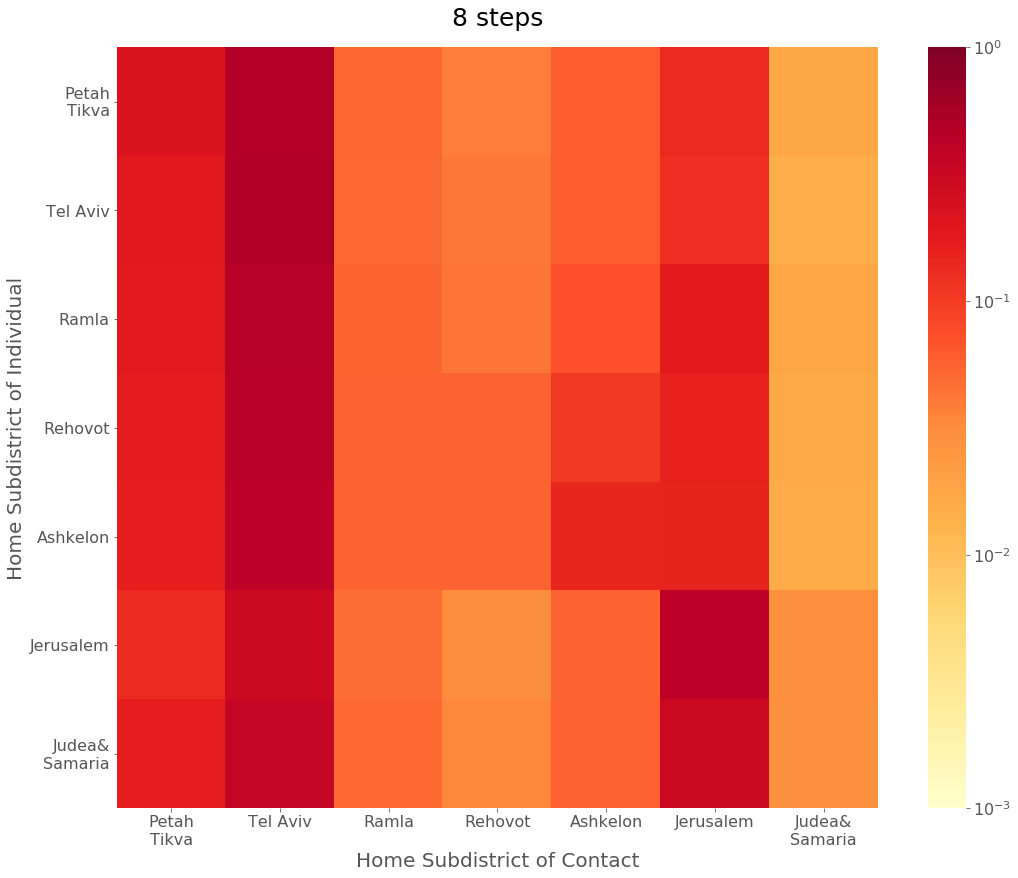

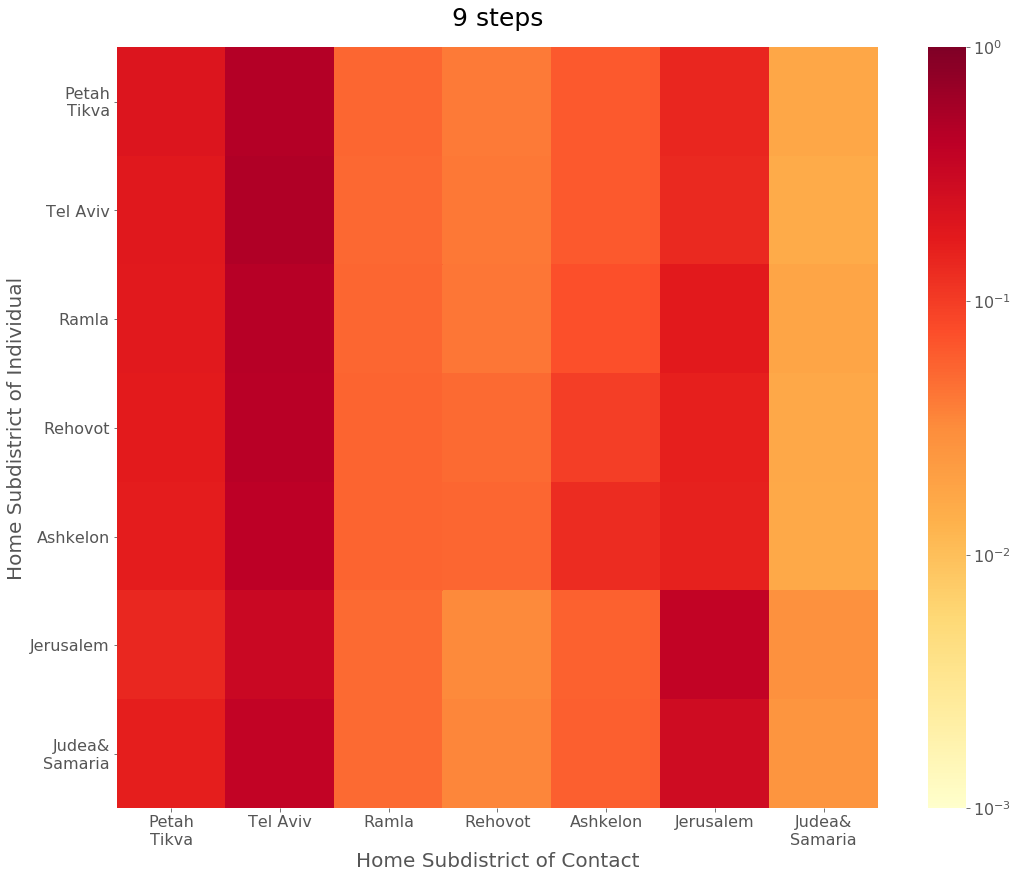

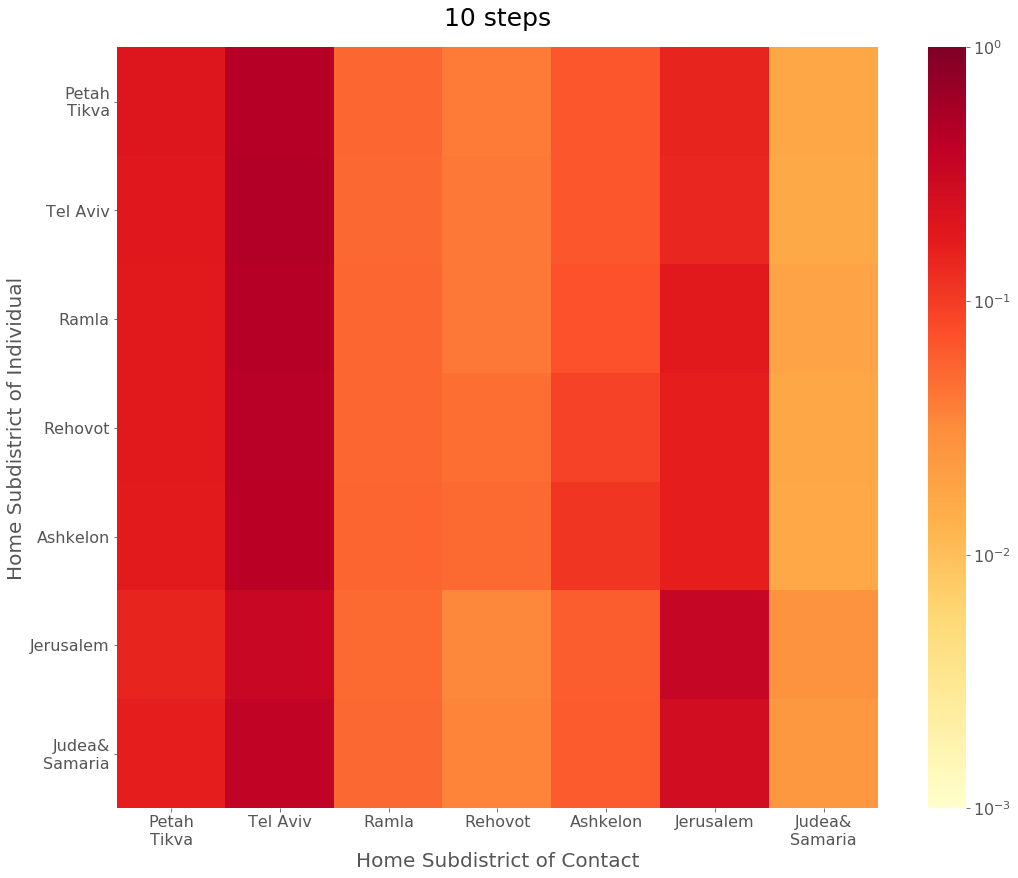

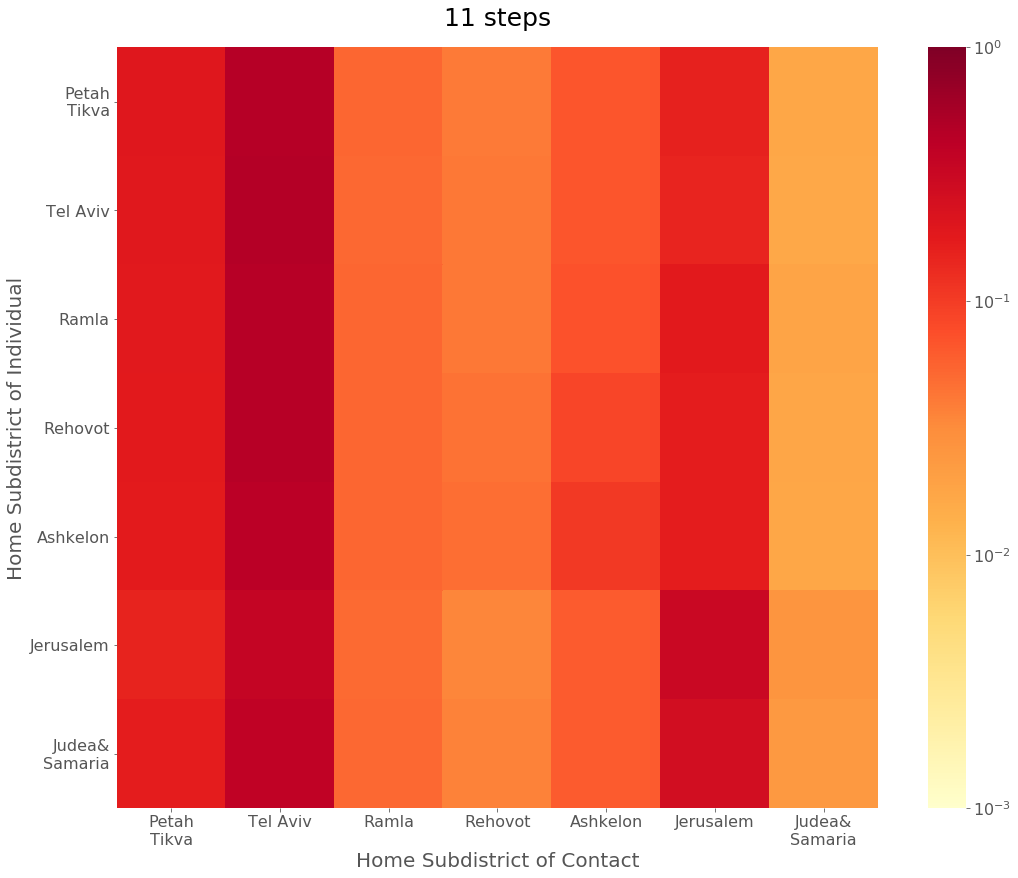

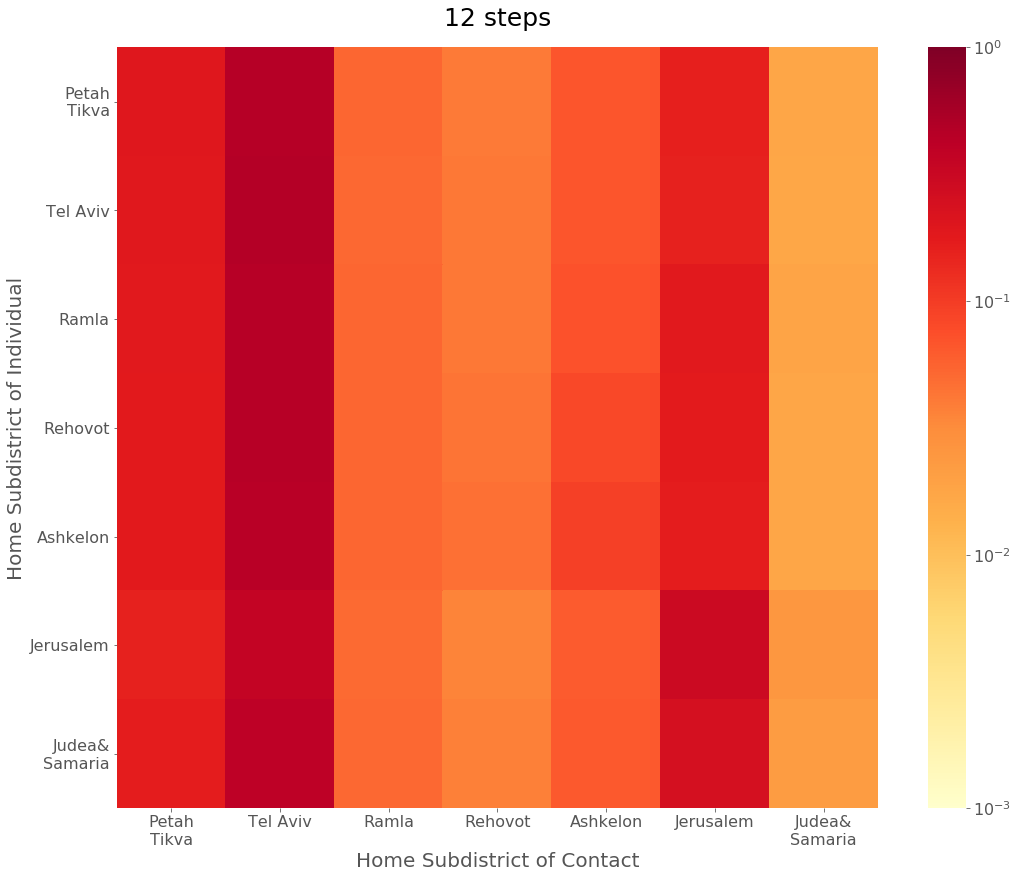

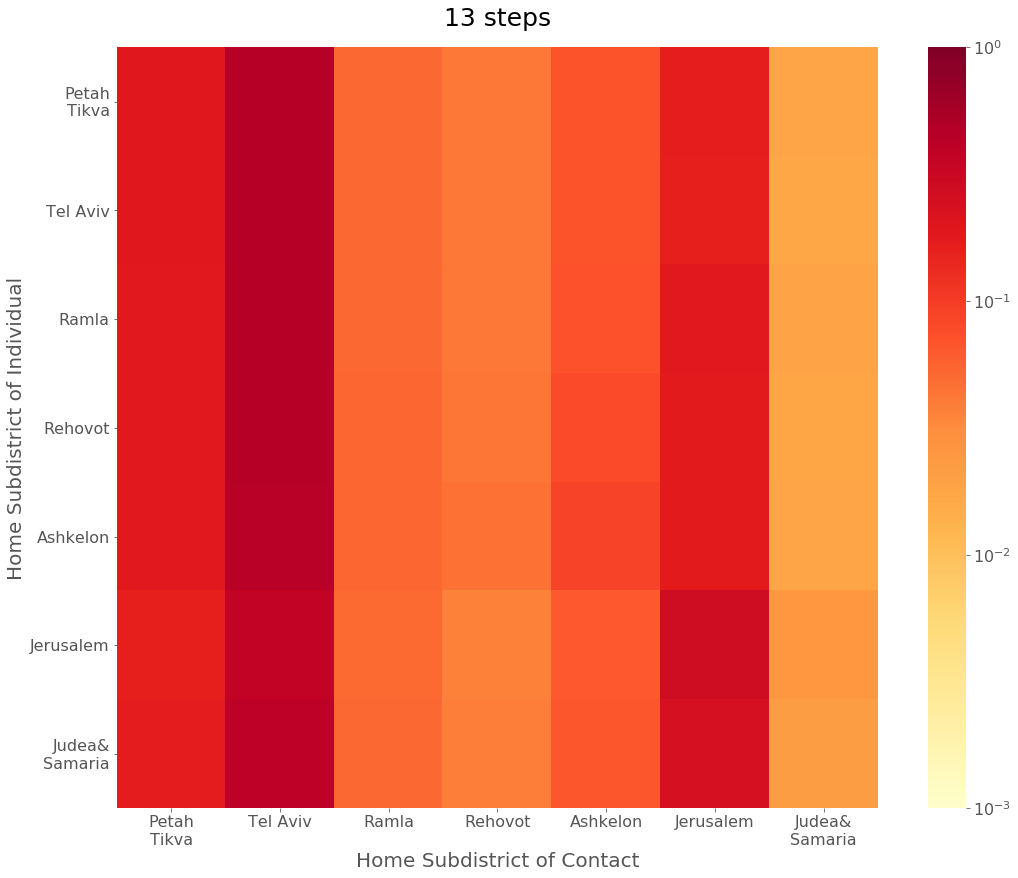

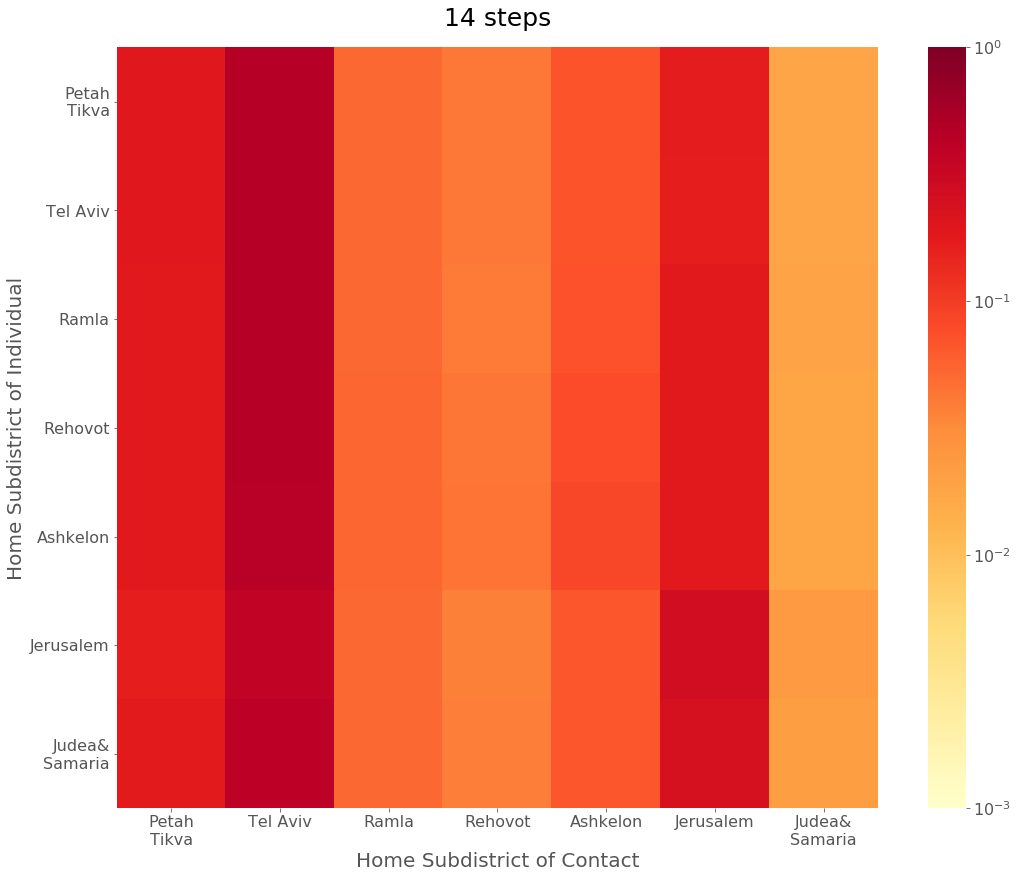

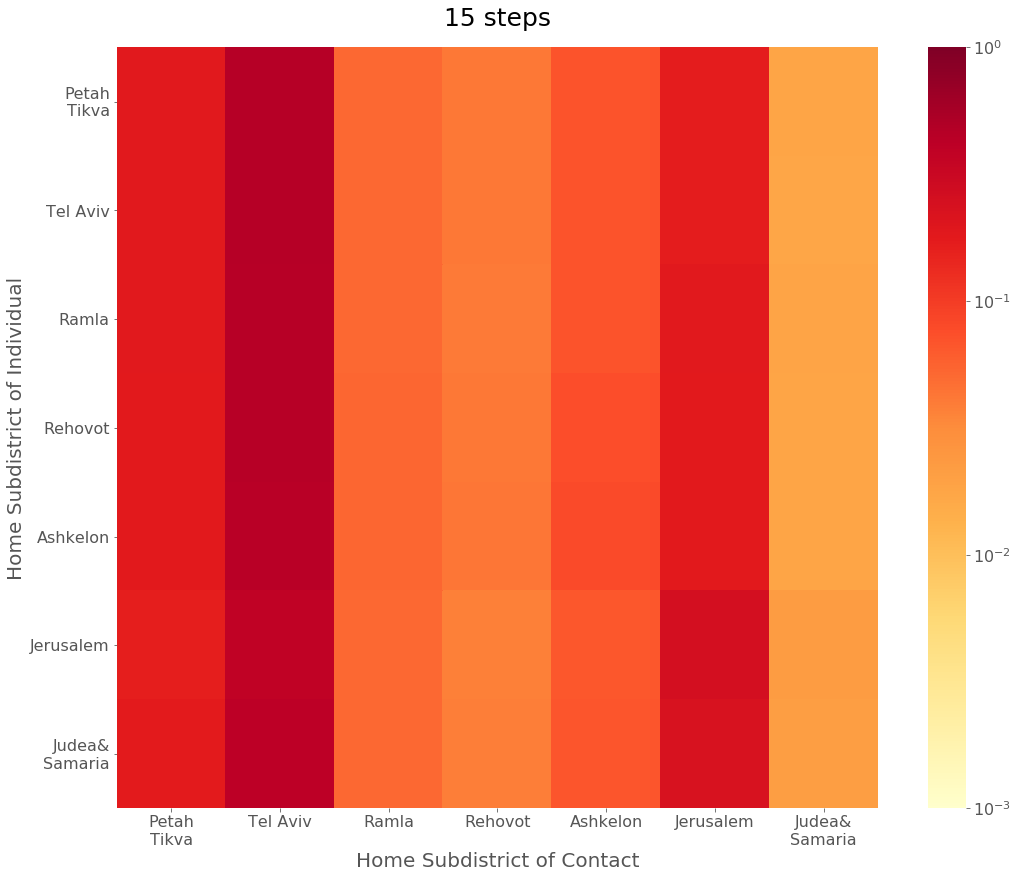

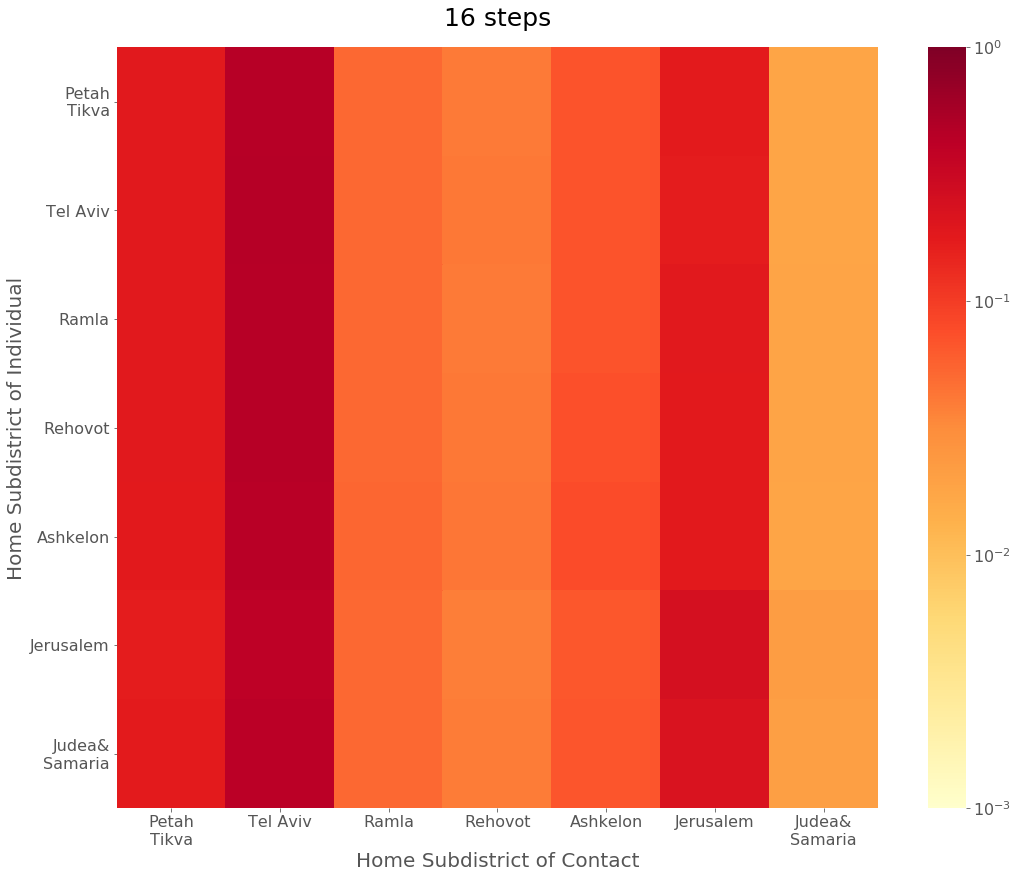

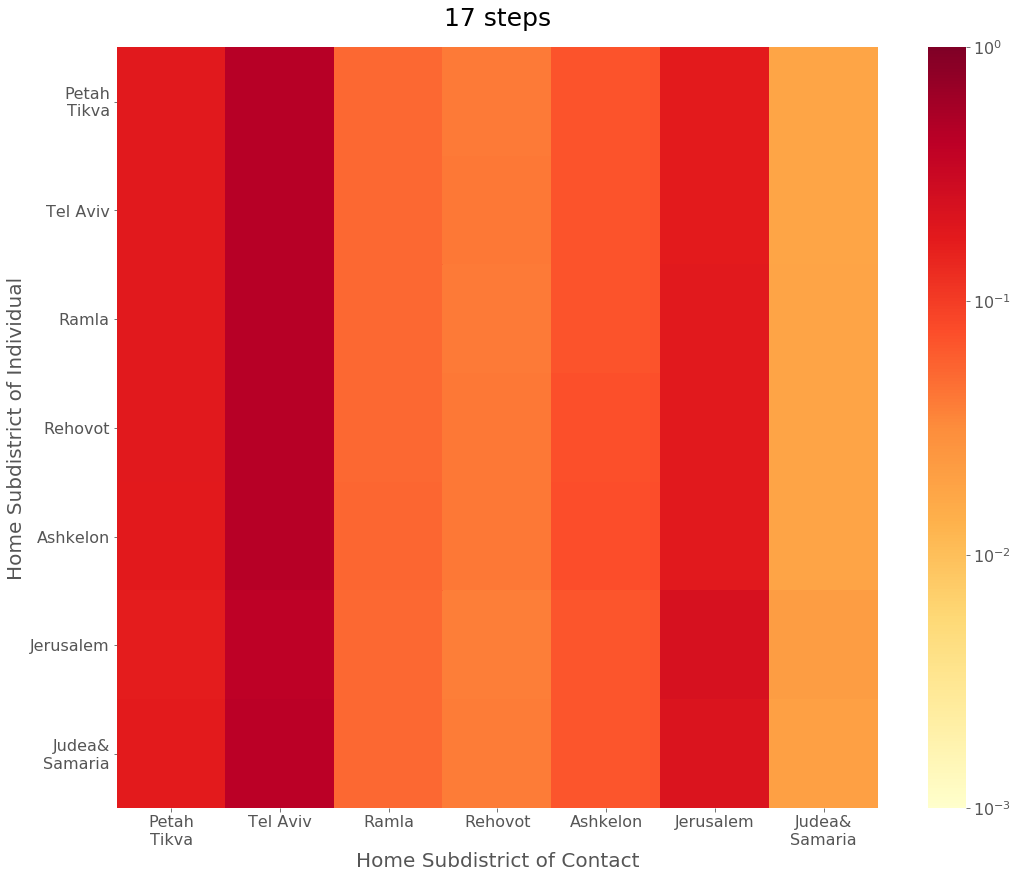

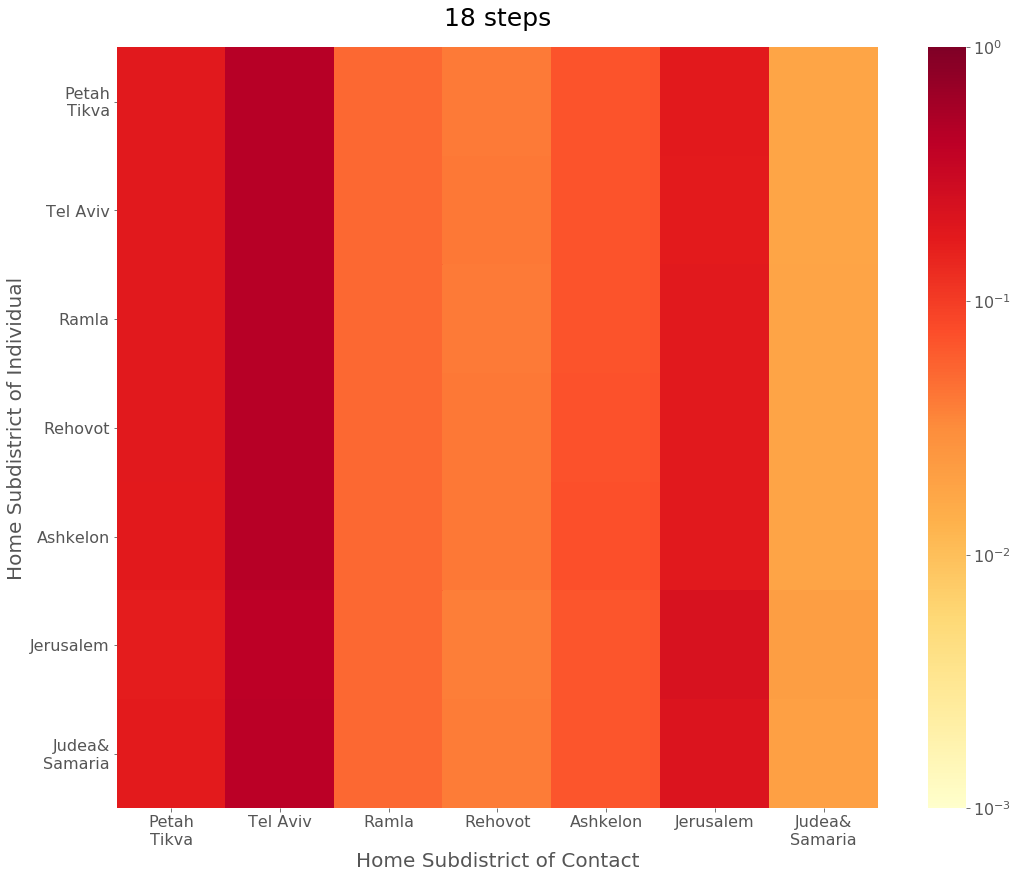

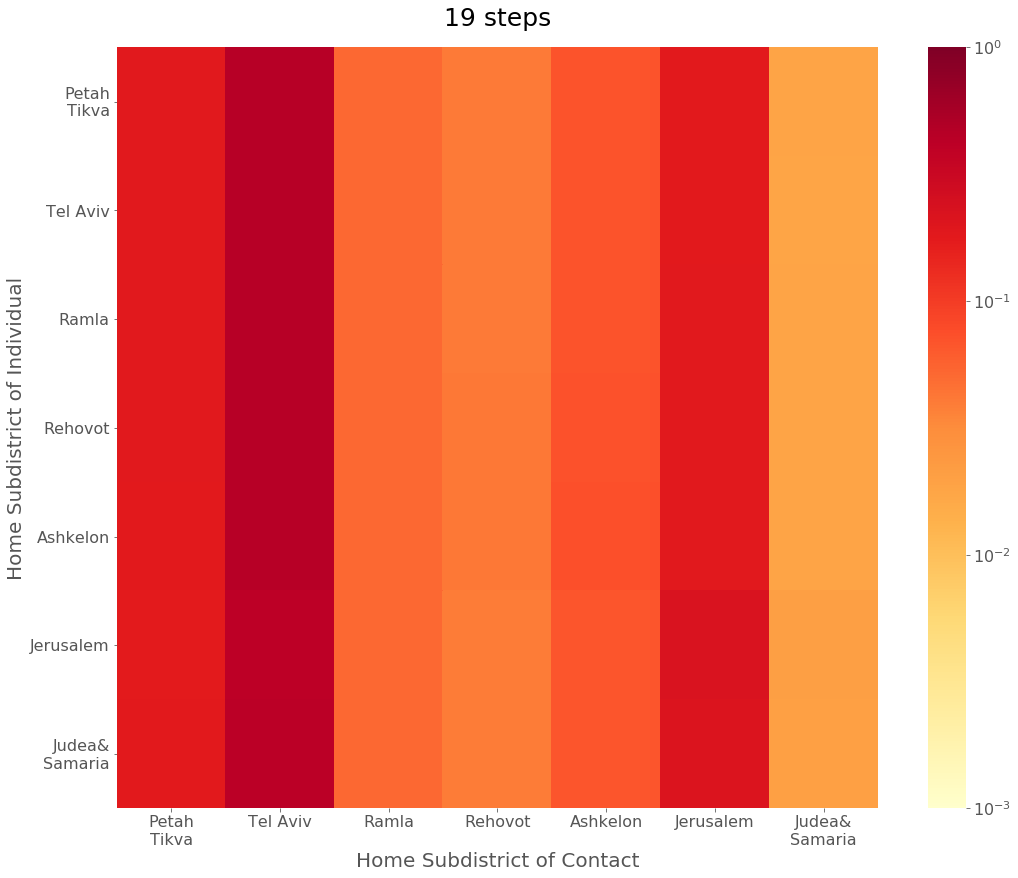

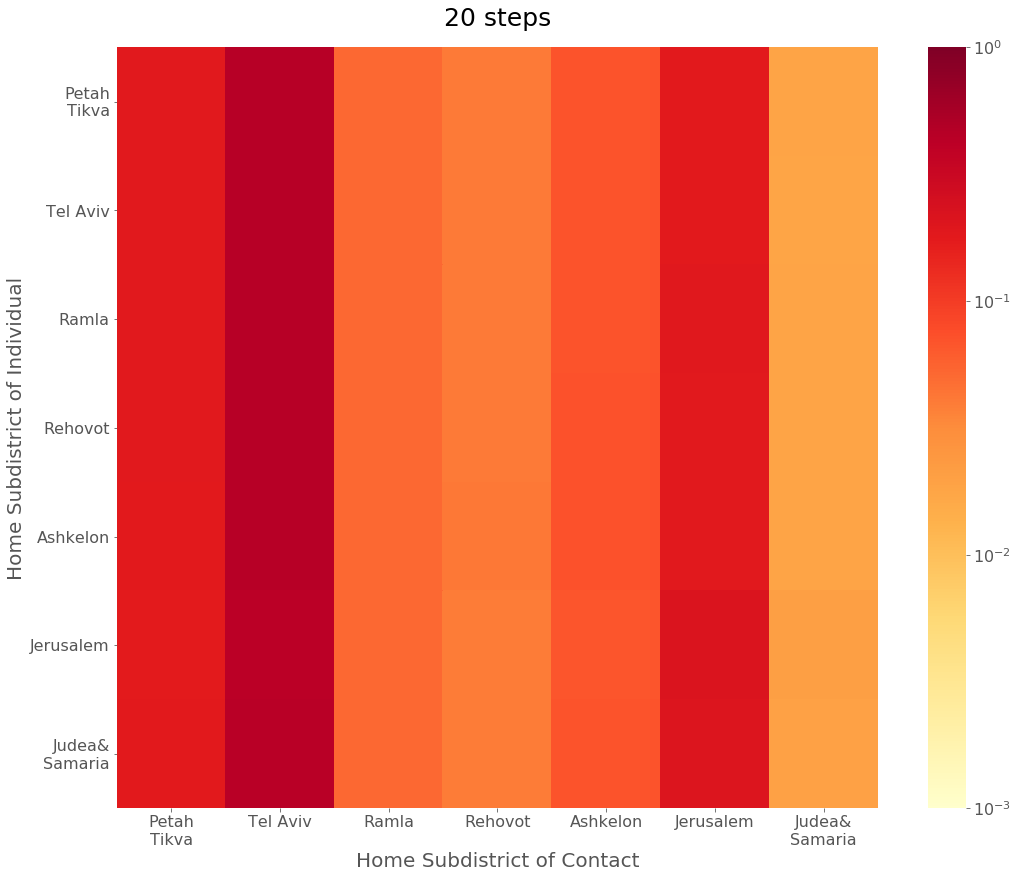

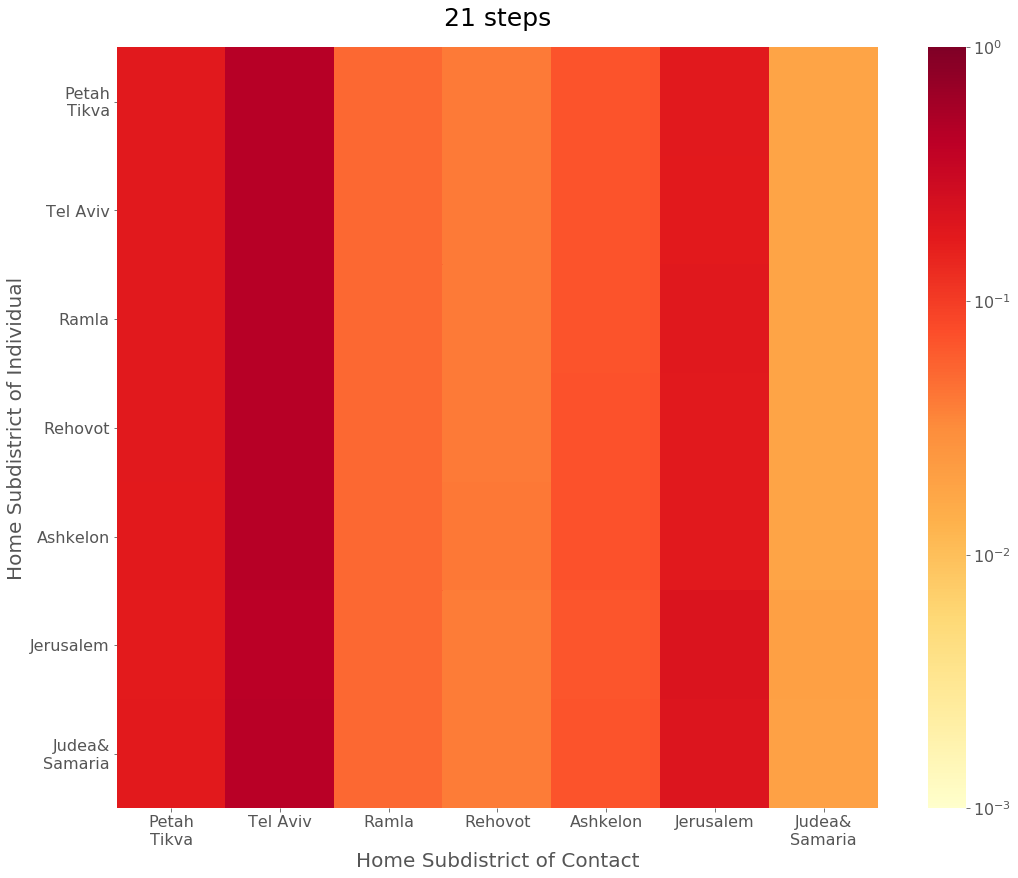

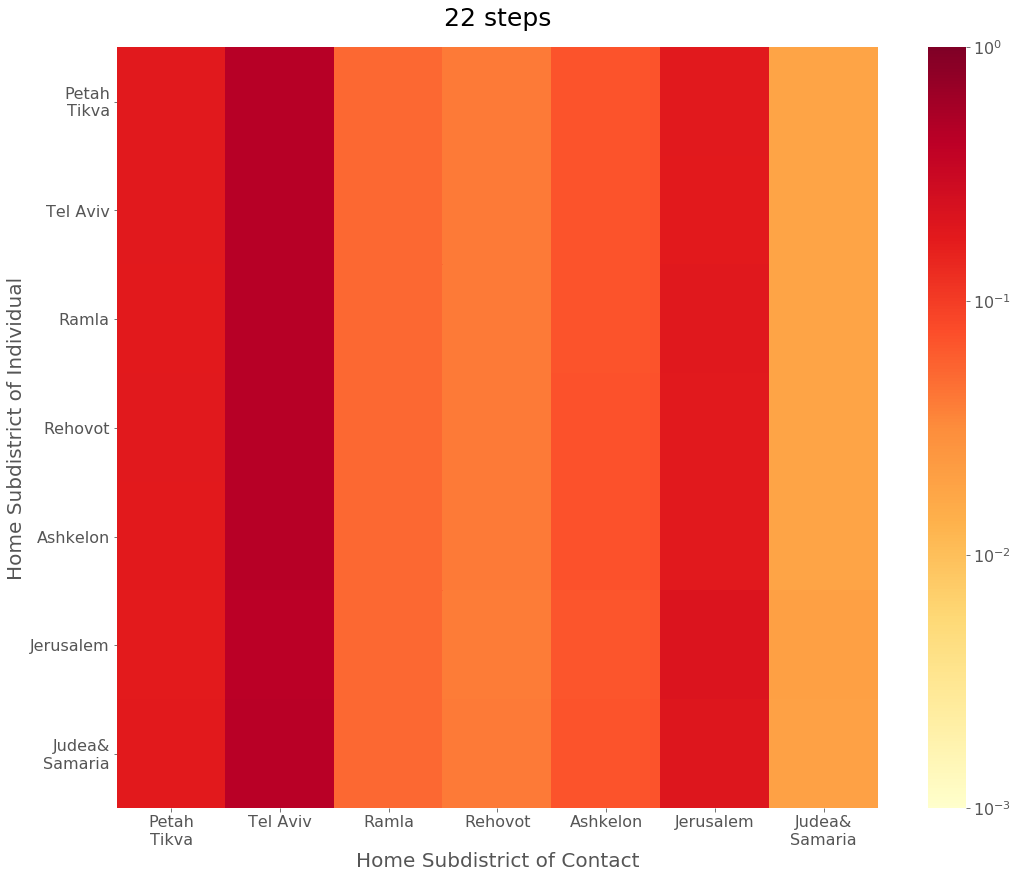

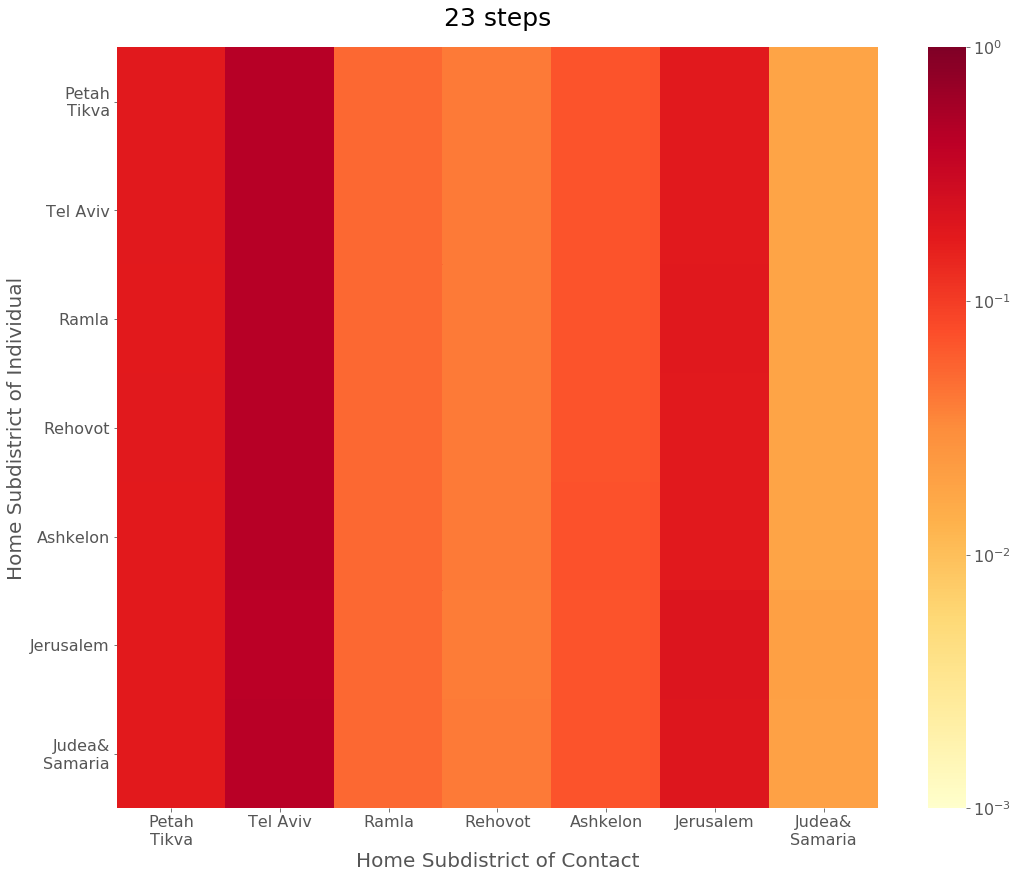

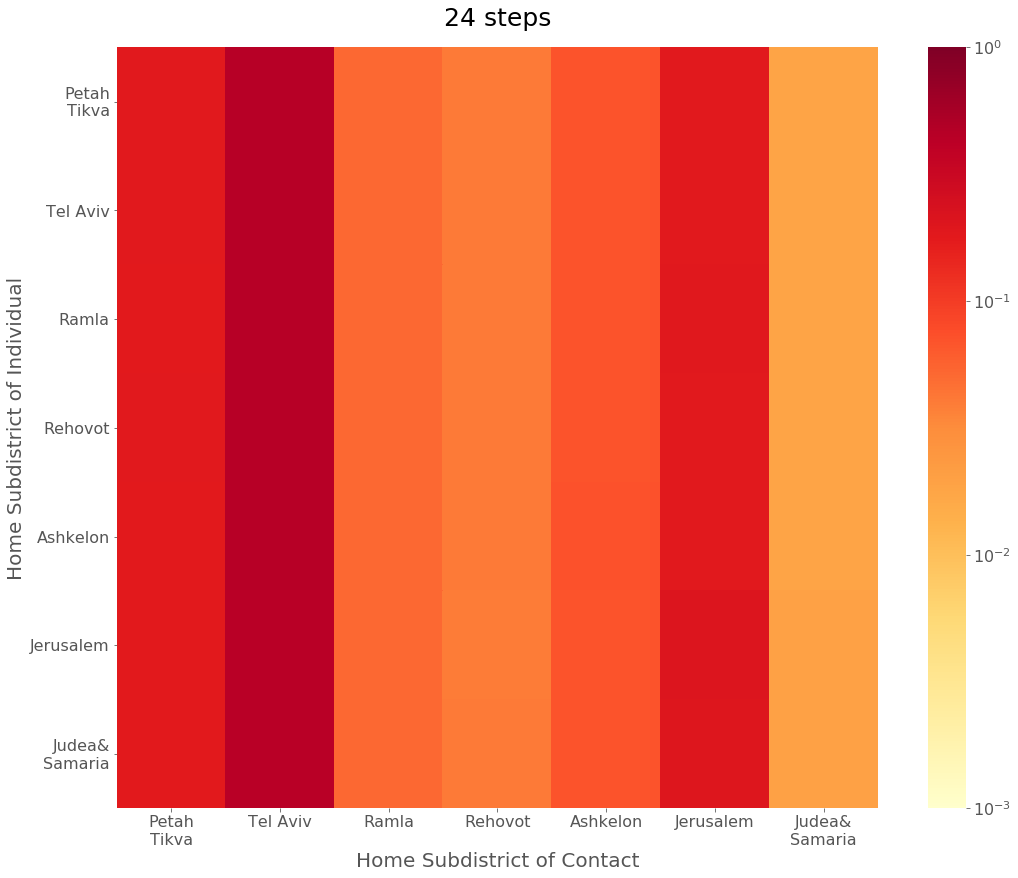

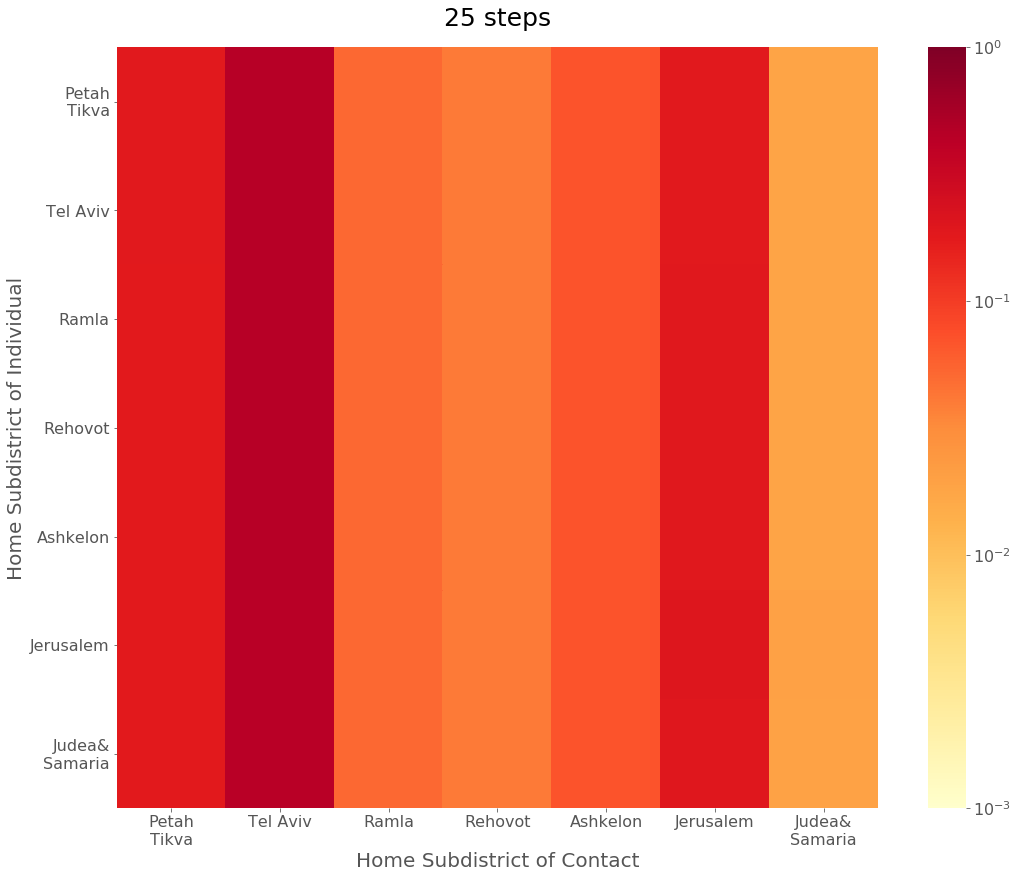

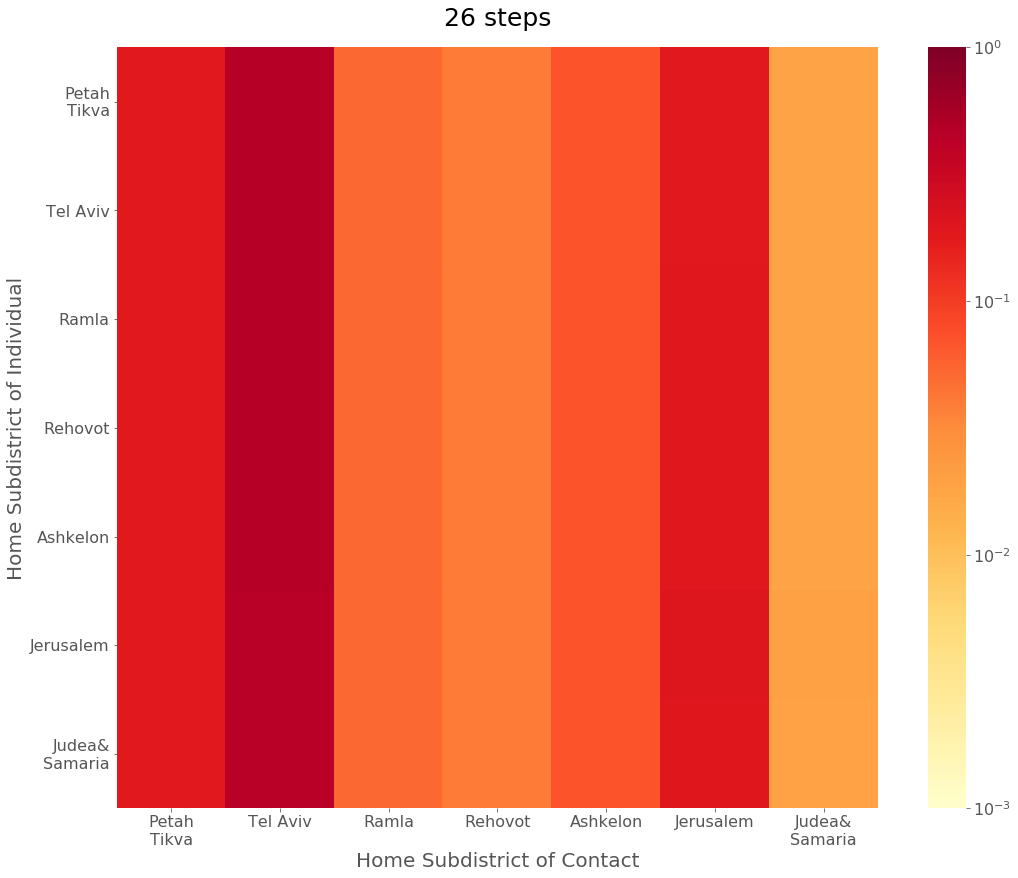

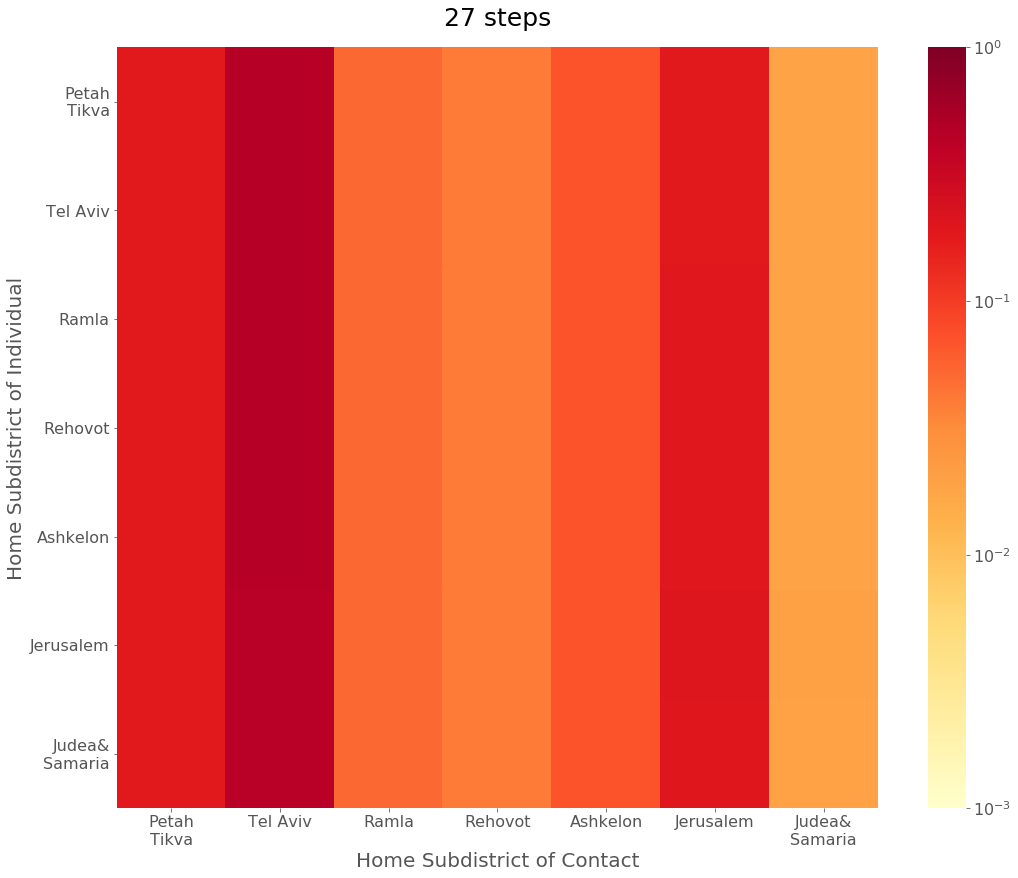

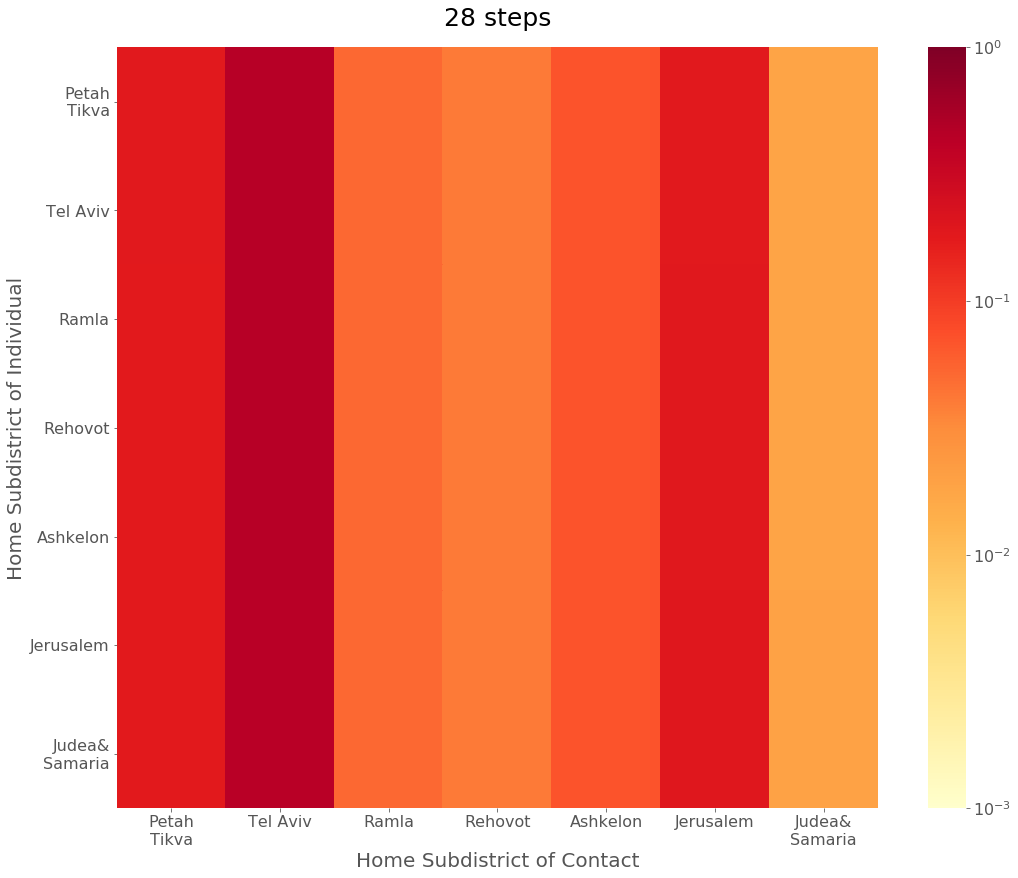

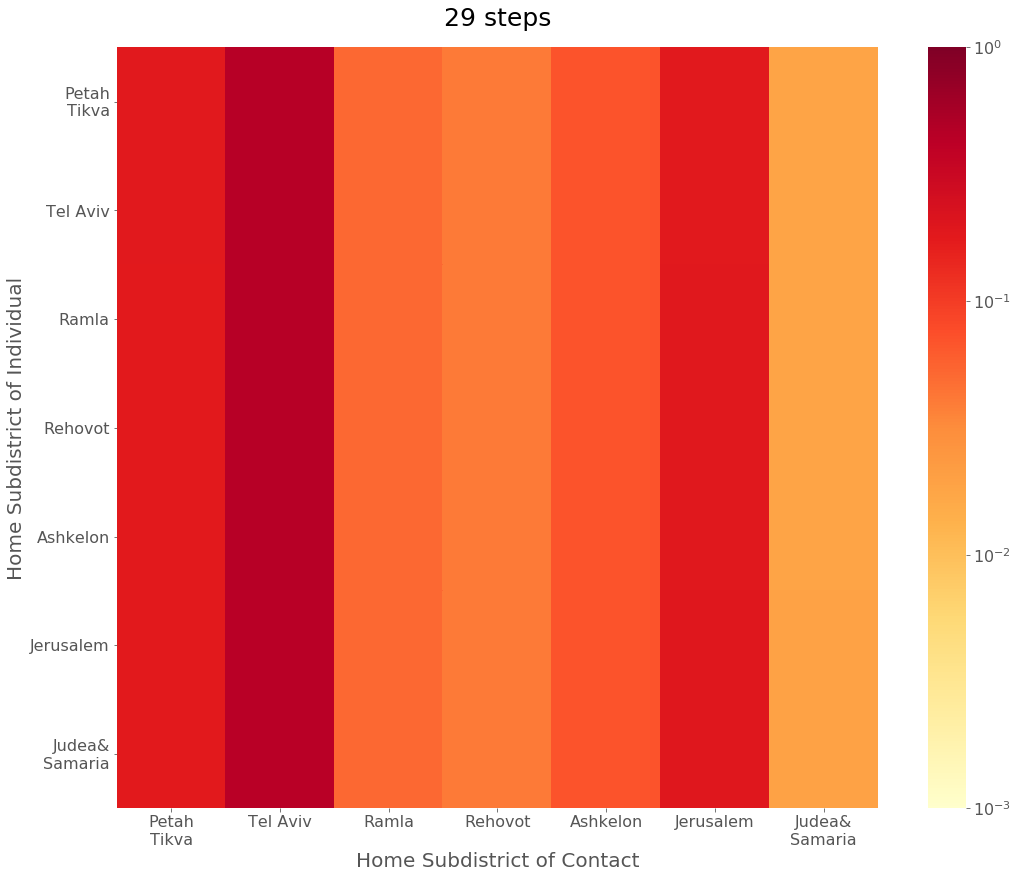

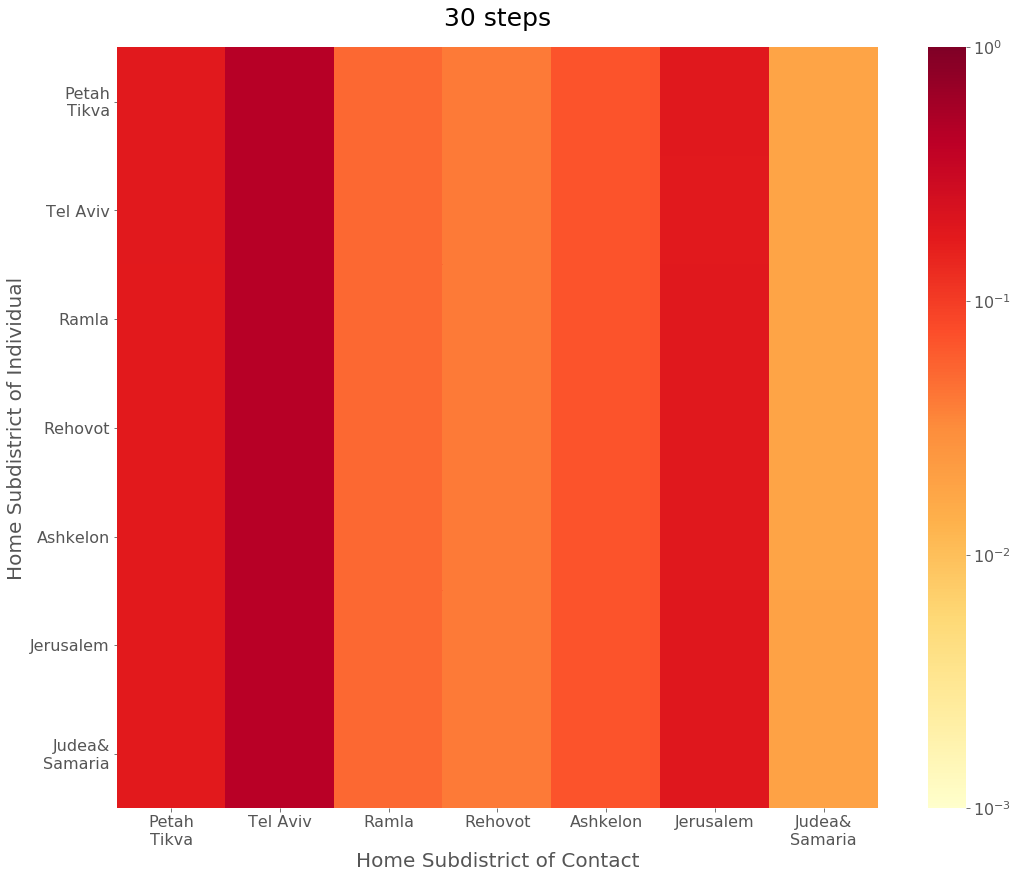

In [100]:
mat = meeting_matrix_subdist_norm.values
steps = np.arange(1,31)

labels = ['Petah\nTikva', 'Tel Aviv', 'Ramla', 'Rehovot', 'Ashkelon', 'Jerusalem', 'Judea&\nSamaria']

for step in steps:
    meeting_matrix_subdist_norm_i_steps = pd.DataFrame(np.linalg.matrix_power(mat, step), columns=meeting_matrix_subdist_norm.columns,
                                                  index=meeting_matrix_subdist_norm.index)
    # Log transformation
    meeting_mat_subdist_log_df = meeting_matrix_subdist_norm_i_steps.applymap(lambda x: np.log10(x))

    fig, ax = plt.subplots(figsize=(18,14))
    ax.set_title(f'{step} steps', {'fontsize': 25, 'position': (0.5,1.02)})
    heat = sns.heatmap(meeting_mat_subdist_log_df, ax=ax, cmap='YlOrRd', robust=False, vmin=-3, vmax=0,
                       cbar_kws={'ticks':np.linspace(-3,0, 4)}, square=True, xticklabels=labels, yticklabels=labels)
    
    # Axis labels
    plt.ylabel('Home Subdistrict of Individual', fontsize=20)
    plt.xlabel('Home Subdistrict of Contact', fontsize=20)

    # Color bar
    cb = fig.axes[1]
    cb.set_yticklabels([f'$10^{"{"+str(int(i))+"}"}$' for i in np.linspace(-3,0, 4)], fontsize=16)

    ax.tick_params(labelsize=16)
    plt.xticks(rotation='horizontal')
    plt.yticks(rotation='horizontal')

    if step<=9:
        plt.savefig(f'./img/gif_new/0{step}_steps_heatmap.png', bbox_inches="tight");
    else:
        plt.savefig(f'./img/gif_new/{step}_steps_heatmap.png', bbox_inches="tight");

## Plot map

In [101]:
subdistricts_names = nafot.subdistricts_names
rev_names = {subdist: code for code, subdist in subdistricts_names.items()}
subdist_gdf = nafot.get_subdistricts_gdf()

In [102]:
[rev_names[subdist] for subdist in meeting_matrix_subdist_norm.columns]

[42.0, 51.0, 43.0, 44.0, 61.0, 11.0, 77.0]

In [103]:
subdist_gdf = subdist_gdf.loc[[rev_names[subdist] for subdist in meeting_matrix_subdist_norm.columns]].copy()
subdist_gdf['subdist'] = subdist_gdf.apply(lambda row: subdistricts_names[row.name], axis=1)
subdist_gdf['coords'] = subdist_gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
subdist_gdf['coords'] = [coords[0] for coords in subdist_gdf['coords']]

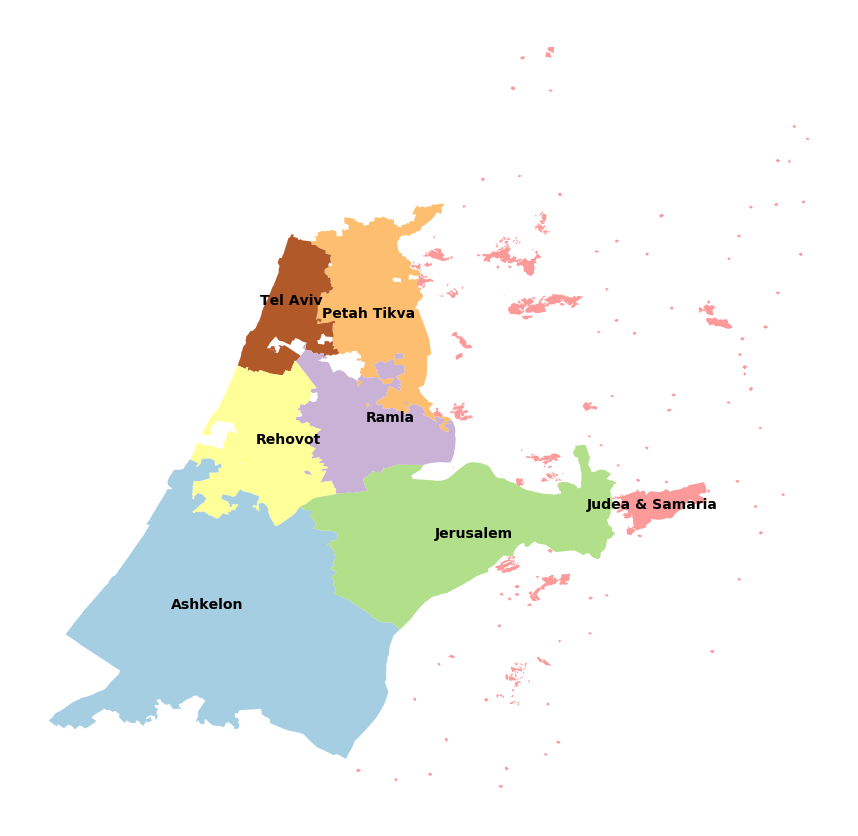

In [171]:
fix, ax = plt.subplots(figsize=(15,15))
subdist_gdf.plot(column ='subdist', figsize=(15,15), label=subdist_gdf.subdist.values, cmap='Paired', ax=ax)
for idx, row in subdist_gdf.iterrows():
    plt.annotate(s=row['subdist'], xy=row['coords'],
                 horizontalalignment='center', size=14, fontweight='bold')

plt.xticks([])
plt.yticks([])

ax.set_facecolor('w')

plt.savefig('./img/subdist map.png')
plt.show()

# Socio-economic Score

## Aggregate the columns

In [15]:
eshcol_data = pd.read_csv('../data/social_economic_status.csv', index_col='stat_id')       

In [16]:
soc_eco_agg_cols_df = pd.DataFrame(index=matrix_A_df.index, columns=range(1,21))

for eschol in range(1,21):
    soc_eco_agg_cols_df[eschol] = matrix_A_df[eshcol_data[eshcol_data.eshcol == eschol].index.values].sum(axis=1)

## Aggregate the rows

In [17]:
soc_eco_agg_df = pd.DataFrame(index=range(1,21), columns=range(1,21))

for eschol in range(1,21):
    soc_eco_agg_df.loc[eschol] = soc_eco_agg_cols_df.loc[eshcol_data[eshcol_data.eshcol == eschol].index.values].sum()

In [18]:
#### Matrix A ####
visits_matrix_soc_eco = soc_eco_agg_df.values

contat_mat_soc_eco = nafot.visits_to_contact_matrix(visits_matrix_soc_eco, 'social-economic')

Number of areas without population data (not home stat area): 0
Number of areas without population data (home stat area): 0


100%|██████████| 20/20 [00:00<00:00, 6685.75it/s]


In [19]:
for n in range(2,7+1):
    print(f'Cluster of size {n} are:')
    for i in range(contat_mat_soc_eco.shape[0]-n+1): 
        temp_mat = contat_mat_soc_eco.values[:,i:i+n][i:i+n]
        if ((temp_mat - np.diag(temp_mat.diagonal())).sum()/(n**2 - n)) > 0.07:
            print (np.array(contat_mat_soc_eco.columns)[np.arange(i,i+n)])

Cluster of size 2 are:
[3 4]
[4 5]
[8 9]
[ 9 10]
[10 11]
[11 12]
[12 13]
[13 14]
[14 15]
[15 16]
[16 17]
[17 18]
Cluster of size 3 are:
[2 3 4]
[3 4 5]
[4 5 6]
[ 8  9 10]
[ 9 10 11]
[10 11 12]
[11 12 13]
[12 13 14]
[13 14 15]
[14 15 16]
[15 16 17]
Cluster of size 4 are:
[2 3 4 5]
[ 8  9 10 11]
[13 14 15 16]
[14 15 16 17]
Cluster of size 5 are:
[13 14 15 16 17]
Cluster of size 6 are:
Cluster of size 7 are:


## Plot heat map

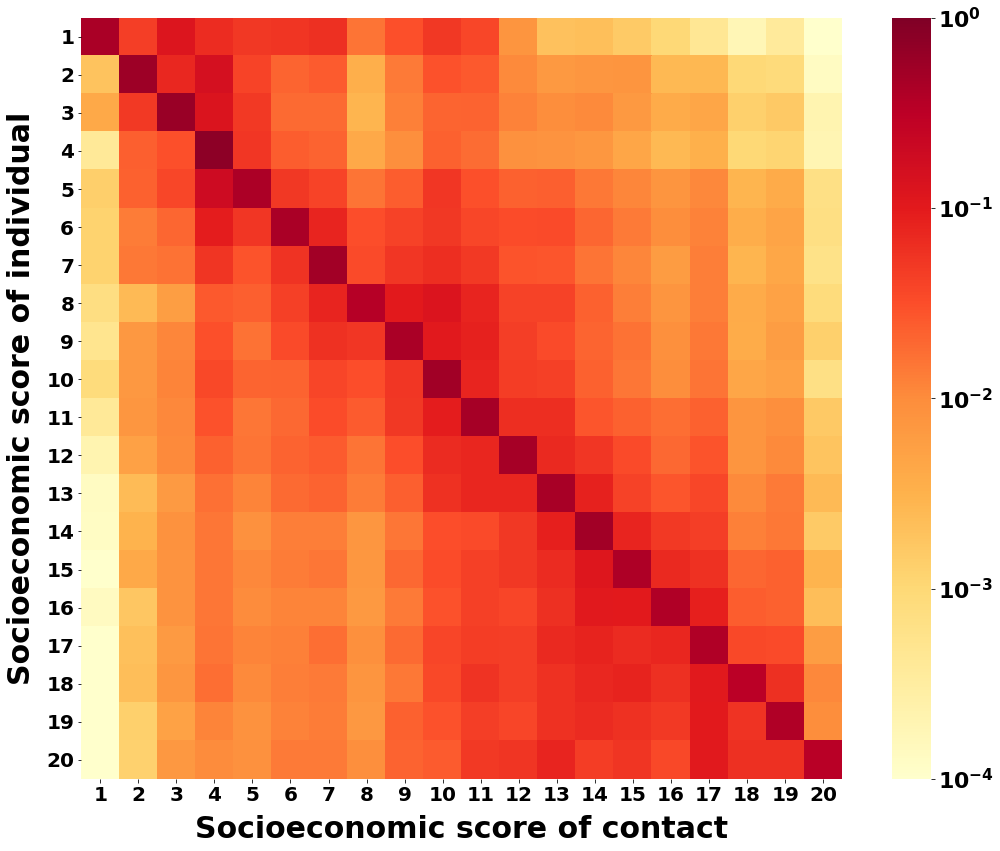

In [47]:
# Log transformation
contat_mat_soc_eco_log_df = contat_mat_soc_eco.applymap(lambda x: np.log10(x))


fig, ax = plt.subplots(figsize=(18,14))
# ax.set_title('Contact Probability Heat Map', {'fontsize': 25, 'position': (0.5,1.02)})
heat = sns.heatmap(contat_mat_soc_eco_log_df, ax=ax, cmap='YlOrRd', robust=False, vmin=-4, vmax=0,
                   cbar_kws={'ticks':np.linspace(-4,0, 5)}, square=True)#, xticklabels=labels, yticklabels=labels)

# Ticks
ax.tick_params(labelsize=20)
plt.yticks(rotation='horizontal')

# Axis labels
plt.ylabel('Socioeconomic score of individual', fontsize=30, labelpad=10, fontweight='bold')
plt.xlabel('Socioeconomic score of contact', fontsize=30, labelpad=10, fontweight='bold')

# Color bar
cb = fig.axes[1]
cb.set_yticklabels([f'$10^{"{"+str(int(i))+"}"}$' for i in np.linspace(-4,0, 5)], fontsize=22)

# Save - without clusters
plt.savefig('../img/contact_heatmap_socio-economic_bold.png', bbox_inches="tight")

# Mark the clusters
# clusters = [[7,4,13,10,16], [0,13,4,10,16], [7,4,13,20,20]]
# plt.vlines(clusters[0], clusters[1], clusters[2], colors='white', **{'linewidth': 2.5}, linestyles='dashed')
# plt.hlines(clusters[0], clusters[1], clusters[2], colors='white', **{'linewidth': 2.5}, linestyles='dashed')

# Save - with clusters
# plt.savefig('../img/contact_heatmap_socio-economic - with clusters.png', bbox_inches="tight")
plt.show()

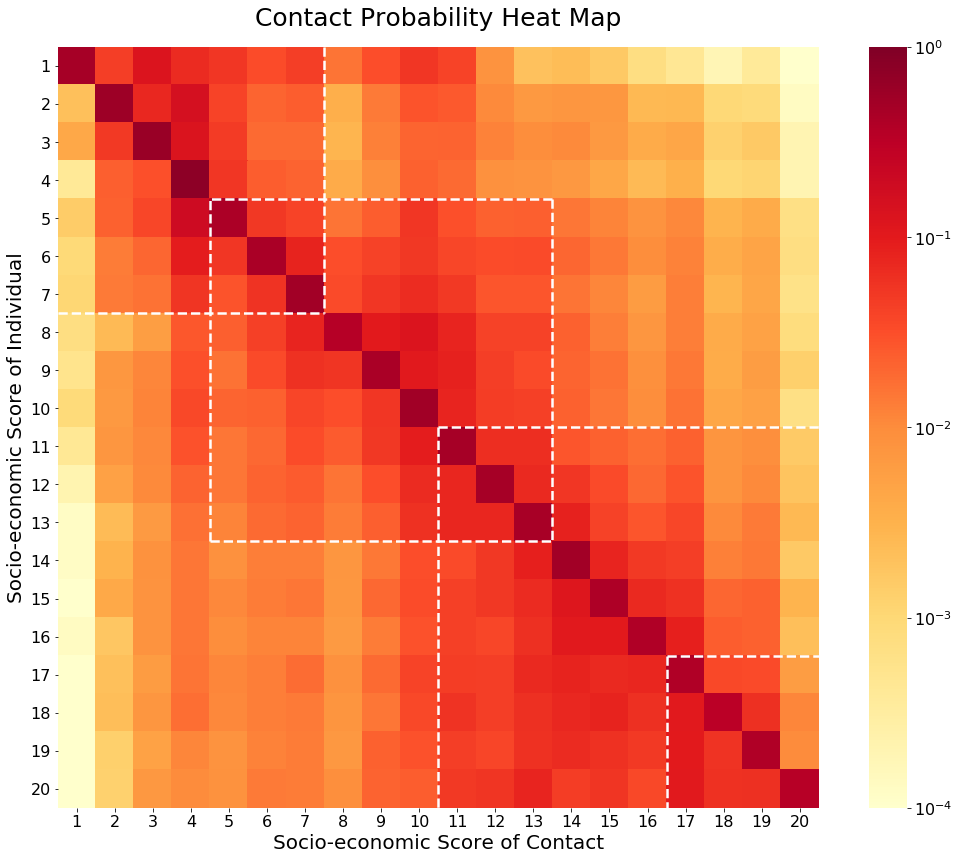

In [201]:
# Log transformation
contat_mat_soc_eco_log_df = contat_mat_soc_eco.applymap(lambda x: np.log10(x))


fig, ax = plt.subplots(figsize=(18,14))
ax.set_title('Contact Probability Heat Map', {'fontsize': 25, 'position': (0.5,1.02)})
heat = sns.heatmap(contat_mat_soc_eco_log_df, ax=ax, cmap='YlOrRd', robust=False, vmin=-4, vmax=0,
                   cbar_kws={'ticks':np.linspace(-4,0, 5)}, square=True)#, xticklabels=labels, yticklabels=labels)

# Ticks
ax.tick_params(labelsize=16)
plt.yticks(rotation='horizontal')

# Axis labels
plt.ylabel('Socio-economic Score of Individual', fontsize=20)
plt.xlabel('Socio-economic Score of Contact', fontsize=20)

# Color bar
cb = fig.axes[1]
cb.set_yticklabels([f'$10^{"{"+str(int(i))+"}"}$' for i in np.linspace(-4,0, 5)], fontsize=16)

# Save - without clusters
# plt.savefig('../img/contact_heatmap_socio-economic.png', bbox_inches="tight")

# Mark the clusters
clusters = [[7,4,13,10,16], [0,13,4,10,16], [7,4,13,20,20]]
plt.vlines(clusters[0], clusters[1], clusters[2], colors='white', **{'linewidth': 2.5}, linestyles='dashed')
plt.hlines(clusters[0], clusters[1], clusters[2], colors='white', **{'linewidth': 2.5}, linestyles='dashed')

# Save - with clusters
# plt.savefig('../img/contact_heatmap_socio-economic - with clusters.png', bbox_inches="tight")
plt.show()

## Religion Contact Matrix

#### Aggregate the columns

In [30]:
religions = list(nafot.religion_dict.values())

religion_agg_cols_df = pd.DataFrame(index=matrix_A_df.index, columns=religions)

for rel in religions:
    religion_agg_cols_df[rel] = matrix_A_df[gdf[gdf.religion == rel].index.values].sum(axis=1)

#### Aggregate the rows

In [31]:
religion_agg_df = pd.DataFrame(index=religions, columns=religions)

for rel in religions:
    religion_agg_df.loc[rel] = religion_agg_cols_df.loc[gdf[gdf.religion == rel].index.values].sum()

# Save the final matrix
# meeting_matrix_subdist.to_csv('../data/matrix/sample1+2_final_matrix_.csv')        

In [52]:
#### Matrix A ####
visits_matrix_religion = religion_agg_df.values

contat_mat_religion = visits_to_contact_matrix(visits_matrix_religion, 'religion')

['Jewish' 'Muslim' 'Christian' 'Druze' 'Other']
Number of areas without population data (not home stat area): 0
Number of areas without population data (home stat area): 0


100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<?, ?it/s]


In [53]:
contat_mat_religion

Jewish    Muslim
Jewish  0.956863  0.043137
Muslim  0.540475  0.459525

In [55]:
contat_mat_rel_log_df = contat_mat_religion.applymap(lambda x: np.log10(x))
contat_mat_rel_log_df

Jewish    Muslim
Jewish -0.019150 -1.365146
Muslim -0.267224 -0.337691

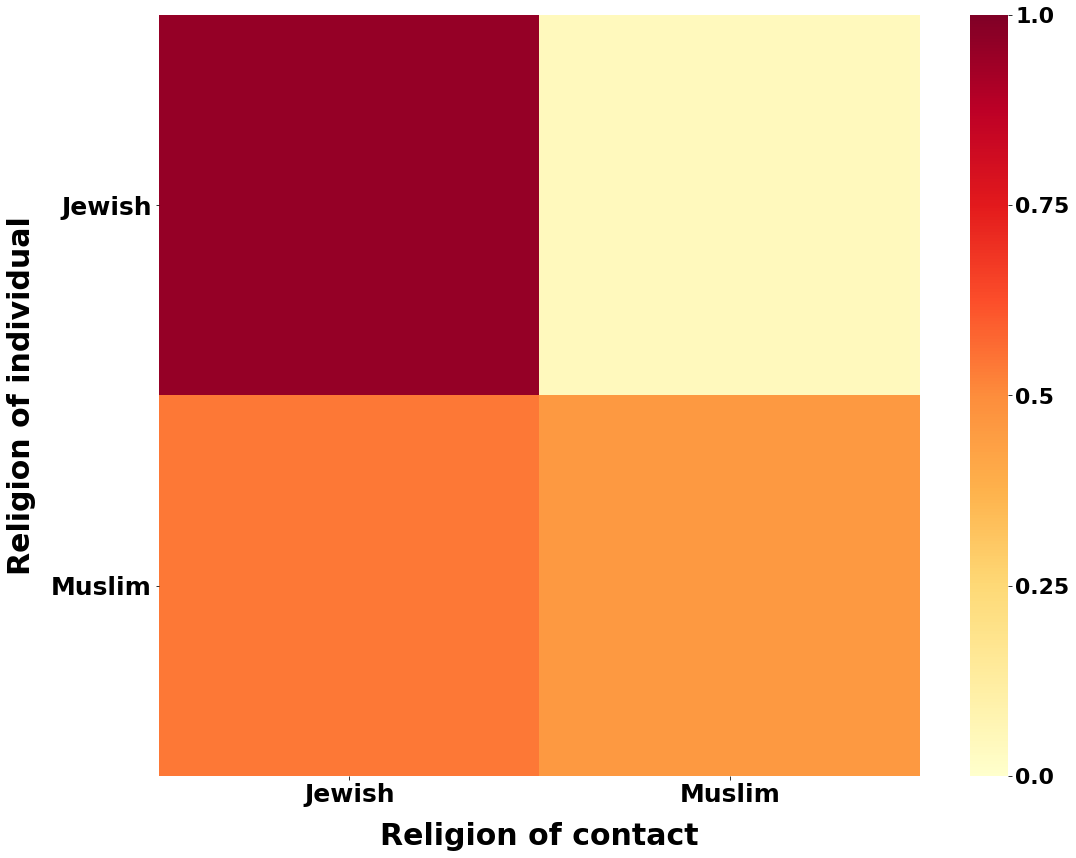

In [64]:
# Log transformation
contat_mat_rel_log_df = contat_mat_religion.applymap(lambda x: np.log10(x))


fig, ax = plt.subplots(figsize=(18,14))

# Make all bold
plt.rc('font', weight='bold')

# ax.set_title('Contact Probability Heat Map', {'fontsize': 25, 'position': (0.5,1.02)})
heat = sns.heatmap(contat_mat_religion, ax=ax, cmap='YlOrRd', robust=False, vmin=0, vmax=1,
                   cbar_kws={'ticks':np.linspace(0,1,5)}, square=True)#, xticklabels=labels, yticklabels=labels)

# Ticks
ax.tick_params(labelsize=25)
plt.yticks(rotation='horizontal')

# Axis labels
plt.ylabel('Religion of individual', fontsize=30, labelpad=15, fontweight='bold')
plt.xlabel('Religion of contact', fontsize=30, labelpad=15, fontweight='bold')

# Color bar
cb = fig.axes[1]
cb.set_yticklabels([f'{i}' for i in np.linspace(0,1,5)], fontsize=22)

# Save - without clusters
plt.savefig('../img/contact_heatmap_rel_bold.png', bbox_inches="tight")

# Mark the clusters
# clusters = [[7,4,13,10,16], [0,13,4,10,16], [7,4,13,20,20]]
# plt.vlines(clusters[0], clusters[1], clusters[2], colors='white', **{'linewidth': 2.5}, linestyles='dashed')
# plt.hlines(clusters[0], clusters[1], clusters[2], colors='white', **{'linewidth': 2.5}, linestyles='dashed')

# Save - with clusters
# plt.savefig('../img/contact_heatmap_socio-economic - with clusters.png', bbox_inches="tight")
plt.show()

In [51]:
religion_dict = nafot.religion_dict

def visits_to_contact_matrix(visits_matrix, level, use_names=False):
    """Receives a visits matrix aggregated by 'level' and returns a contact matrix"""
    #### Level adjustments ####
    if level in ['district', 'subdistrict', 'yeshuv']:
        # Get codes column names in gdf
        code_col_names = {'district': 'DistrictCode', 'subdistrict': 'SubDistrictCode', 'yeshuv': 'SEMEL_YISH'}

        # If the level is not stat area, add the relevant level to the location data
        area_col = code_col_names[level]

        # Get a list of the area's ids
        ids = pd.unique(gdf[area_col])

        # Remove NaN
        ids = np.array(ids[~np.isnan(ids)])

        # Get areas names
        if level == 'district':
            areas_names = districts_names.copy()
        elif level == 'subdistrict':
            areas_names = subdistricts_names.copy()
        elif level == 'yeshuv':
            areas_names = yesuvim_names.copy()

    elif level == 'stat_area':
        ids = np.array(gdf.index.values)

    elif level == 'social-economic':
        ids = np.array(range(1, 21))

    elif level == 'religion':
        ids = np.array(list(religion_dict.values()))

    elif level == 'religion_with_orthodox':
        ids = np.array(religion_with_orthodox.columns[:-1])

    elif level == 'education':
        ids = np.array(education.columns[:-1])

    #### Matrix B ####
    # Normalizing the meeting matrix by dividing each row by it's sum
    matrix_B = visits_matrix.copy()
    for i in range(matrix_B.shape[0]):
        if matrix_B[i].sum() > 0:
            matrix_B[i] = matrix_B[i] / (matrix_B[i].sum())

    #### Matrix C ####
    no_pop = 0
    no_pop2 = 0

    # Multiply each row by the population of the stat_area
    matrix_C = matrix_B.copy()

    # Getting areas population
    if level in ['district', 'subdistrict', 'yeshuv']:
        gb_gdf = gdf.groupby(area_col)
        population_dict = {area_id: gb_gdf.pop_thou.sum().loc[area_id] * 1000 for area_id in ids}

    elif level == 'stat_area':
        population_dict = {area_id: gdf.iloc[i].pop_thou * 1000 for i, area_id in enumerate(ids)}

    elif level == 'social-economic':
        gb_gdf = eshcol_data.groupby('eshcol')
        population_dict = {eshcol: gb_gdf.pop_thou.sum().loc[eshcol] * 1000 for eshcol in ids}

    elif level == 'religion':
        gb_gdf = gdf.groupby('religion')
        print(ids)
        population_dict = {rel: gb_gdf.pop_thou.sum().loc[rel] * 1000 for rel in ids}

    elif level == 'religion_with_orthodox':
        population_dict = {rel: ((religion_with_orthodox[rel] * religion_with_orthodox.pop_thou).sum() * 1000) for rel
                           in ids}

    elif level == 'education':
        population_dict = {ed_lvl: ((education[ed_lvl] * education.pop_thou).sum() * 1000) for ed_lvl in ids}

    # Initialize a list for the areas without population data
    no_pop_areas = []

    for i in range(matrix_C.shape[0]):
        # Get the stat_area population (the data is in thousands)
        area_pop = population_dict[ids[i]]
        if np.isnan(area_pop) or area_pop == 0:
            area_pop = 0
            no_pop_areas.append(i)
            no_pop += 1
            if matrix_C[i].sum() > 0:
                no_pop2 += 1

        # Multiply the row by the relevant population
        matrix_C[i] *= area_pop

    print('Number of areas without population data (not home stat area): {}'.format(no_pop))
    print('Number of areas without population data (home stat area): {}'.format(no_pop2))

    # Remove rows and columns without population data
    mask = np.ones(matrix_C.shape[0], dtype=bool)
    mask[no_pop_areas] = False
    remaining_areas = np.arange(matrix_C.shape[0])[mask]
    matrix_C = matrix_C[:, remaining_areas][remaining_areas].copy()
    matrix_B = matrix_B[:, remaining_areas][remaining_areas].copy()

    #### Matrix D ####
    matrix_D = matrix_C.copy()

    # Normalize each column (sum of 1)
    for i in range(matrix_C.shape[1]):
        if matrix_D[:, i].sum() > 0:
            matrix_D[:, i] = matrix_D[:, i] / (matrix_D[:, i].sum())

    #### Meeting Matrix P ####
    meeting_matrix_P = np.zeros(matrix_B.shape, dtype=float)

    for i in tqdm(range(meeting_matrix_P.shape[0])):
        for j in range(meeting_matrix_P.shape[1]):
            meeting_matrix_P[i, j] = np.sum(matrix_B[i] * matrix_B[j] * matrix_D[j])

    # Create a DataFrame
    if level in ['district', 'subdistrict', 'yeshuv'] and use_names:
        names = [areas_names[area_id] for area_id in ids[mask]]
        meeting_matrix_P_df = pd.DataFrame(meeting_matrix_P, index=names, columns=names)

    else:
        meeting_matrix_P_df = pd.DataFrame(meeting_matrix_P, index=ids[mask], columns=ids[mask])

    # Remove rows and columns with 0 only
    meeting_matrix_P_df = meeting_matrix_P_df.applymap(lambda x: np.nan if x == 0 else x)
    meeting_matrix_P_df.dropna(axis=0, how='all', inplace=True)
    meeting_matrix_P_df.dropna(axis=1, how='all', inplace=True)
    #     meeting_matrix_P_df = meeting_matrix_P_df.applymap(lambda x: 0 if np.isnan(x) else x)

    # Normalizing each row to a sum of 1
    meeting_matrix_P_df_norm = meeting_matrix_P_df.values / meeting_matrix_P_df.sum(1).values.reshape(
        (meeting_matrix_P_df.shape[0], 1))

    # Saving to DataFrame
    meeting_matrix_P_df_norm = pd.DataFrame(meeting_matrix_P_df_norm, columns=meeting_matrix_P_df.columns,
                                            index=meeting_matrix_P_df.index)

    return meeting_matrix_P_df_norm

## Steady State

### Multiplying the matrix by itself

In [202]:
mat = contat_mat_soc_eco.values
contat_mat_soc_eco_steady_state = pd.DataFrame(np.linalg.matrix_power(mat, 100000),
                                                        columns=contat_mat_soc_eco.columns).iloc[0:1]

### Create heat map steady state

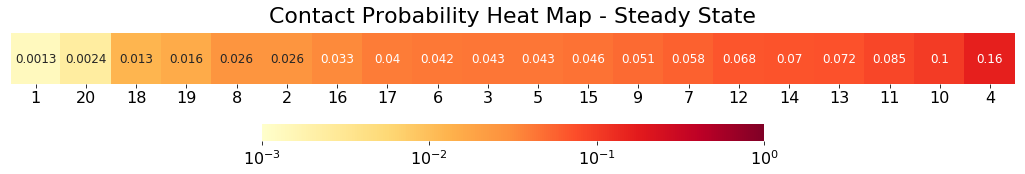

In [203]:
############### Steady state
# contat_mat_soc_eco_log_df_ss = contat_mat_soc_eco_steady_state.applymap(lambda x: np.log10(x))
contat_mat_soc_eco_steady_state_sorted = contat_mat_soc_eco_steady_state.sort_values(0, axis=1)
contat_mat_soc_eco_sorted_log_df_sorted = contat_mat_soc_eco_steady_state_sorted.applymap(lambda x: np.log10(x))


fig, ax = plt.subplots(figsize=(18,5))
ax.set_title('Contact Probability Heat Map - Steady State', {'fontsize': 22, 'position': (0.5,1.1)})
heat = sns.heatmap(contat_mat_soc_eco_sorted_log_df_sorted, ax=ax, cmap='YlOrRd', robust = True,
                   yticklabels='', vmin=-3, vmax=0, annot=contat_mat_soc_eco_steady_state_sorted,
                  annot_kws={'fontsize': 12}, cbar_kws={'ticks':np.linspace(-3,0, 4), "orientation": "horizontal",
                                                        'shrink':0.5, 'aspect':30}, square=True)
ax.tick_params(labelsize=16)

# Color bar
cb = fig.axes[1]
cb.set_xticklabels([f'$10^{"{"+str(int(i))+"}"}$' for i in np.linspace(-3,0, 4)], fontsize=16)

plt.xticks(rotation='horizontal')

# plt.savefig('./img/contact_heatmap scio-economic - steady state.png', bbox_inches="tight")
plt.show()

### w.r.t population size

In [61]:
pop_soc_eco[11:].size

9

In [62]:
pop_soc_eco[10:].sum() / pop_soc_eco.sum()

0.44672900001500804

In [53]:
f'{int(pop_soc_eco.sum()*0.05)}'

'333154'

In [223]:
eshcol_data = pd.read_csv('../data/social_economic_status.csv', index_col='stat_id')       

gb_gdf = eshcol_data.groupby('eshcol')
population_dict = {eshcol: gb_gdf.pop_thou.sum().loc[eshcol] * 1000 for eshcol in range(1,20+1)}
pop_soc_eco = np.array([population_dict[eshcol] for eshcol in range(1,20+1)])

# population propotion
pop_soc_eco = pop_soc_eco / pop_soc_eco.sum()

soc_eco_wrt_pop_size = contat_mat_soc_eco_steady_state / pop_soc_eco

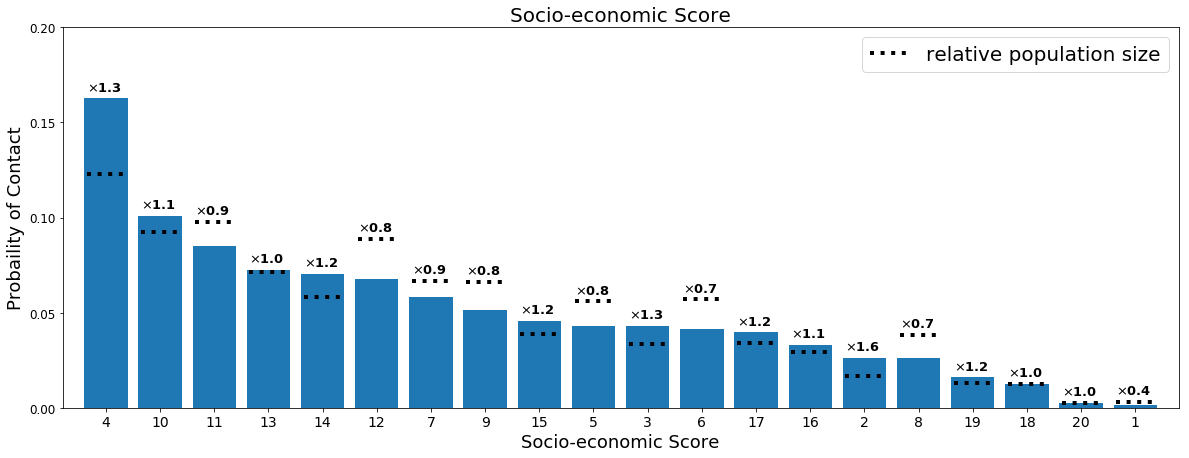

In [224]:
sorted_contat_mat_soc_eco_steady_state = contat_mat_soc_eco_steady_state.sort_values(0, axis=1, ascending=False)

sorted_pop_prop = pop_soc_eco[sorted_contat_mat_soc_eco_steady_state.columns -1]
sorted_soc_eco_wrt_pop_size = soc_eco_wrt_pop_size[sorted_contat_mat_soc_eco_steady_state.columns]

xs = np.arange(1,20+1)
vals = sorted_contat_mat_soc_eco_steady_state.values[0]
colors = ['#93002c', '#bb0026', '#e2191c', '#fc4d2a', '#fd8c3c', '#feb24c', '#fed976','#ffeda0', '#ffffcc']

fig = plt.figure(figsize=(20,7))
plt.bar(xs, vals)

plt.title('Socio-economic Score', fontsize=20)
plt.xlabel('Socio-economic Score', fontsize=18)
plt.ylabel('Probaility of Contact', fontsize=18)

plt.xticks(xs, sorted_contat_mat_soc_eco_steady_state.columns, fontsize=14)
plt.yticks(np.arange(0,0.5+0.05,0.05), fontsize=12)

plt.ylim([0,0.2])
plt.xlim([0.2,20.8])

plt.hlines(sorted_pop_prop, xs-0.35,xs+0.4, linestyles='dotted', color='black', **{'linewidth': 4},
           label='relative population size')

legend = plt.legend(loc='upper right', fontsize=20)

# # Add labels on the bars
for x, y, z in zip(np.arange(0.65,20) ,sorted_soc_eco_wrt_pop_size.values[0], np.maximum(sorted_pop_prop, vals)):
    plt.text(x, z + 0.004, f'$\\times${y:.1f}', color='black', fontweight='bold', fontsize=13)

# plt.savefig('../img/socio-economic scores cenrtrality regular style.png', bbox_inches="tight")
plt.show()

## Create GIF

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


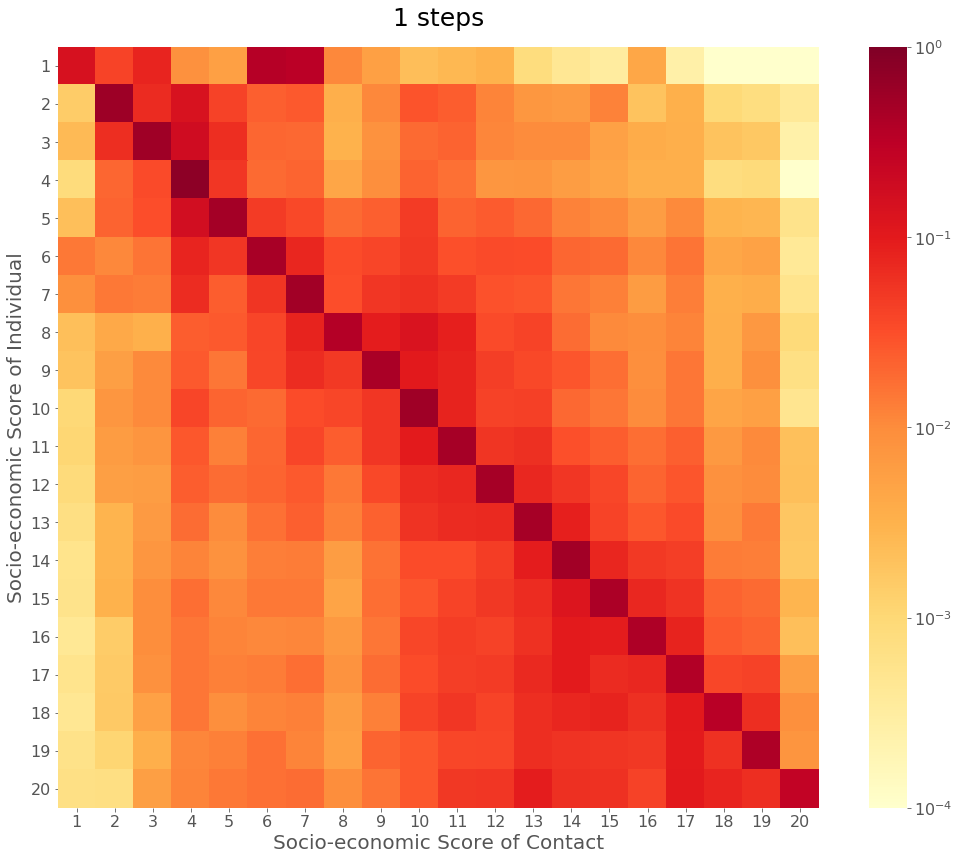

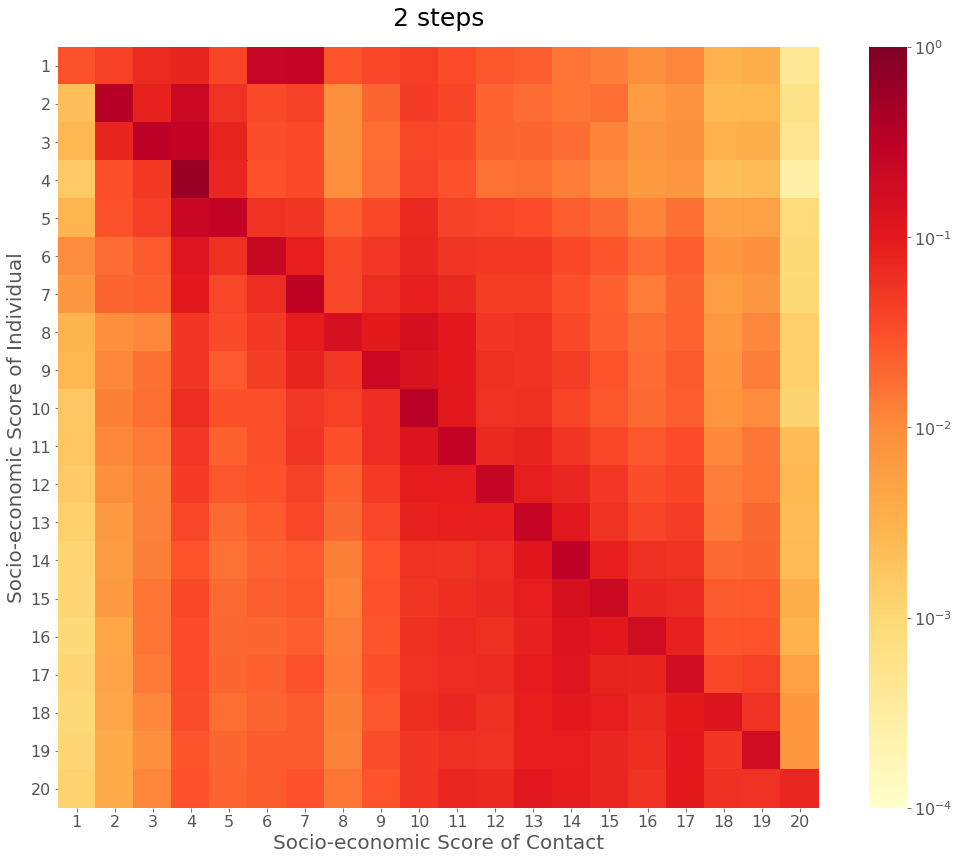

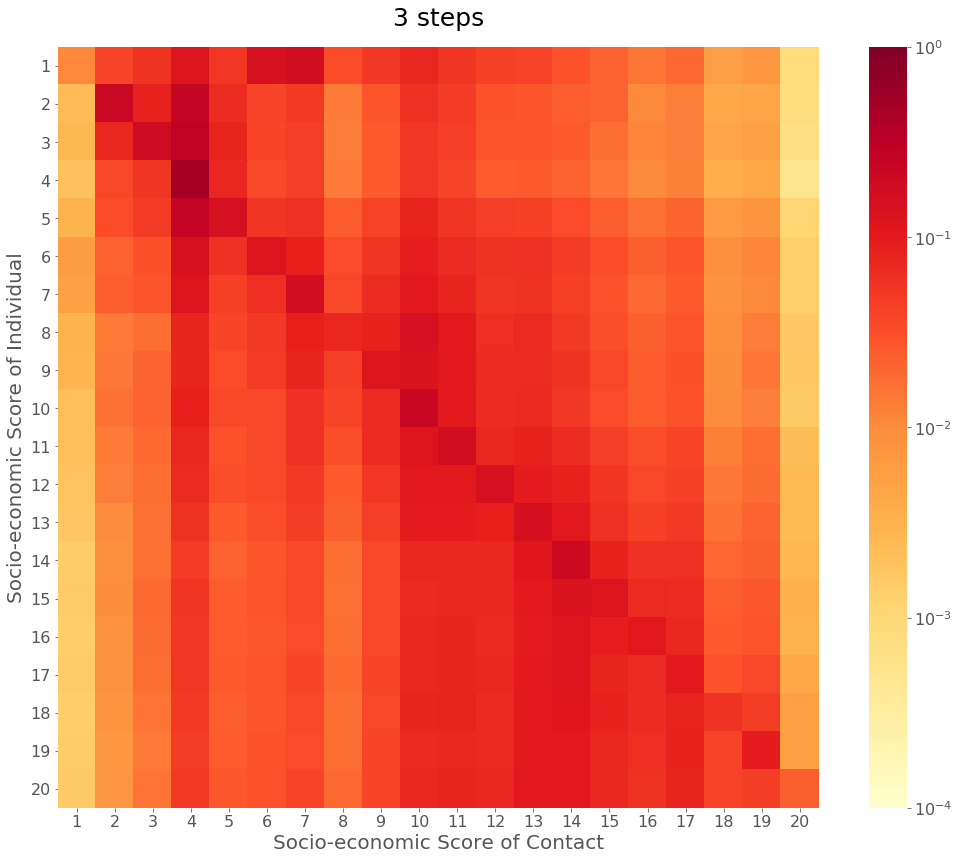

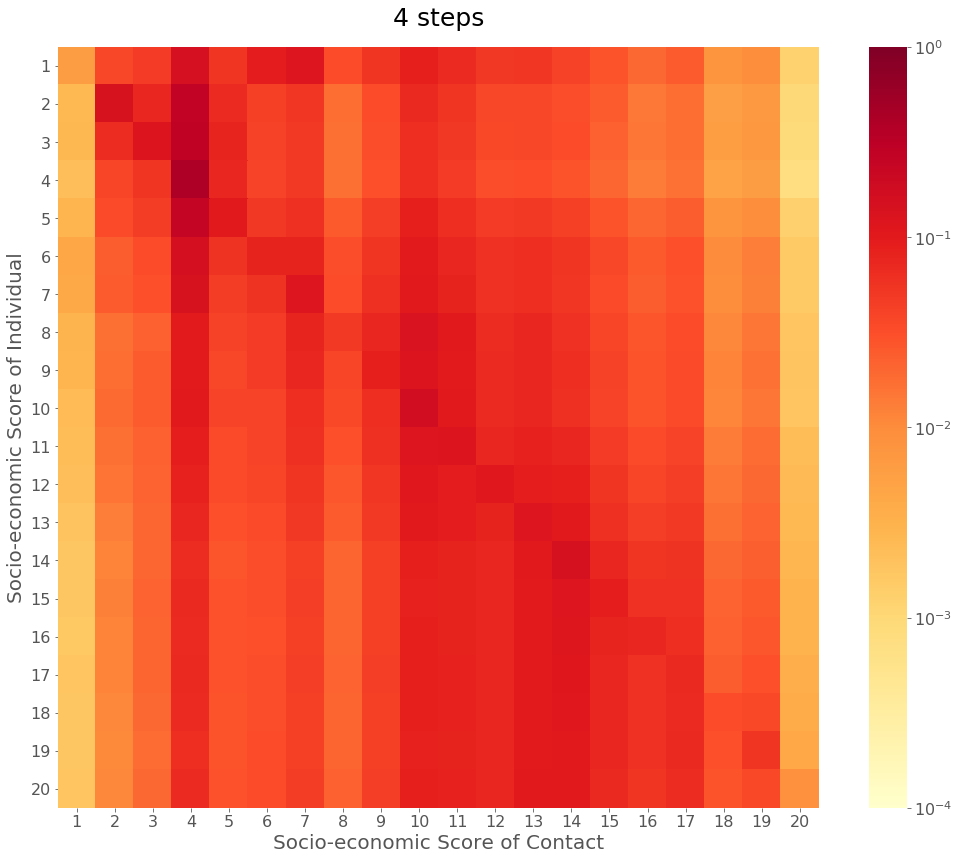

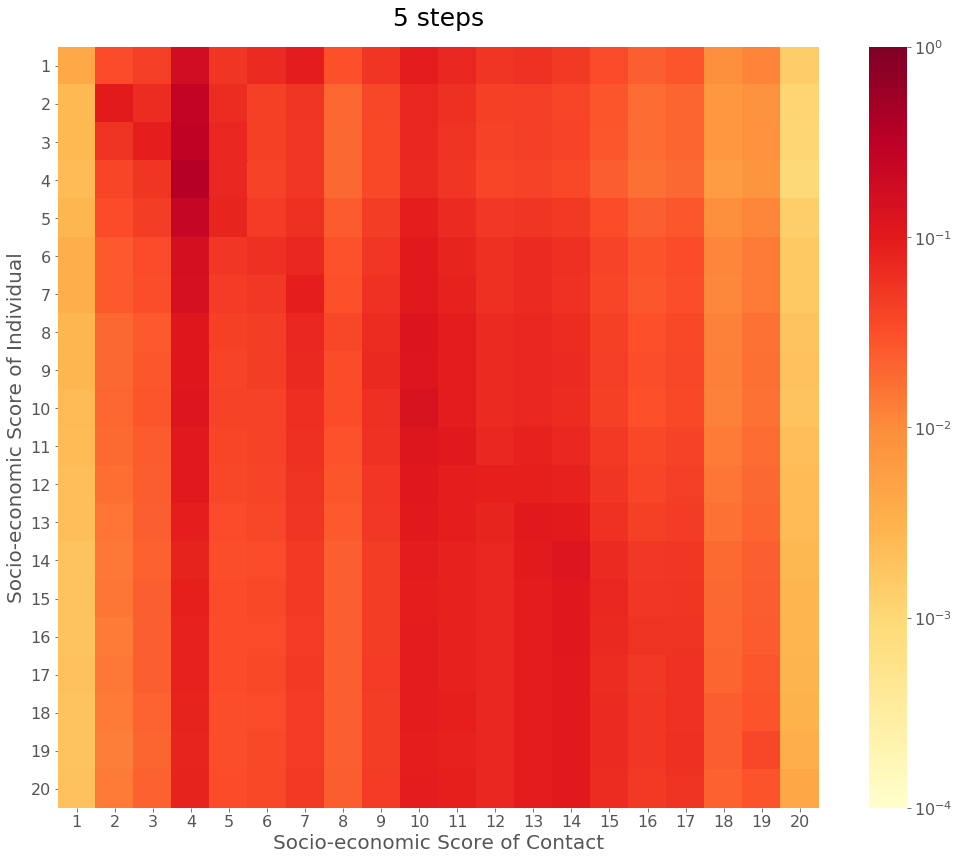

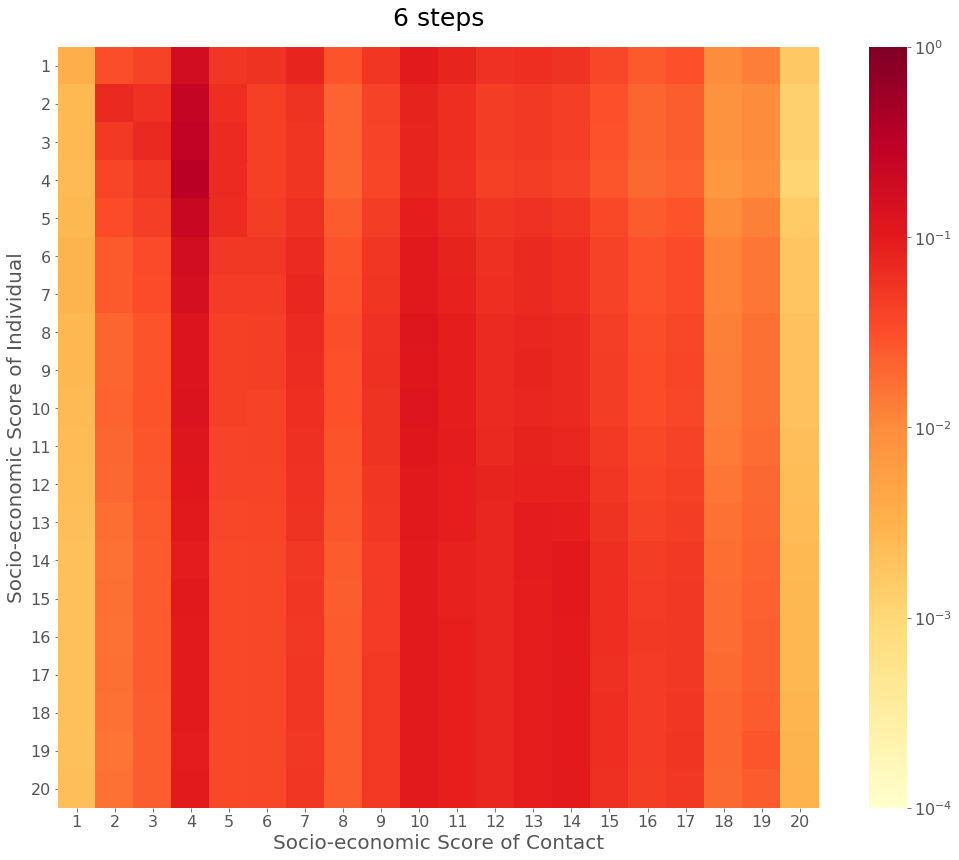

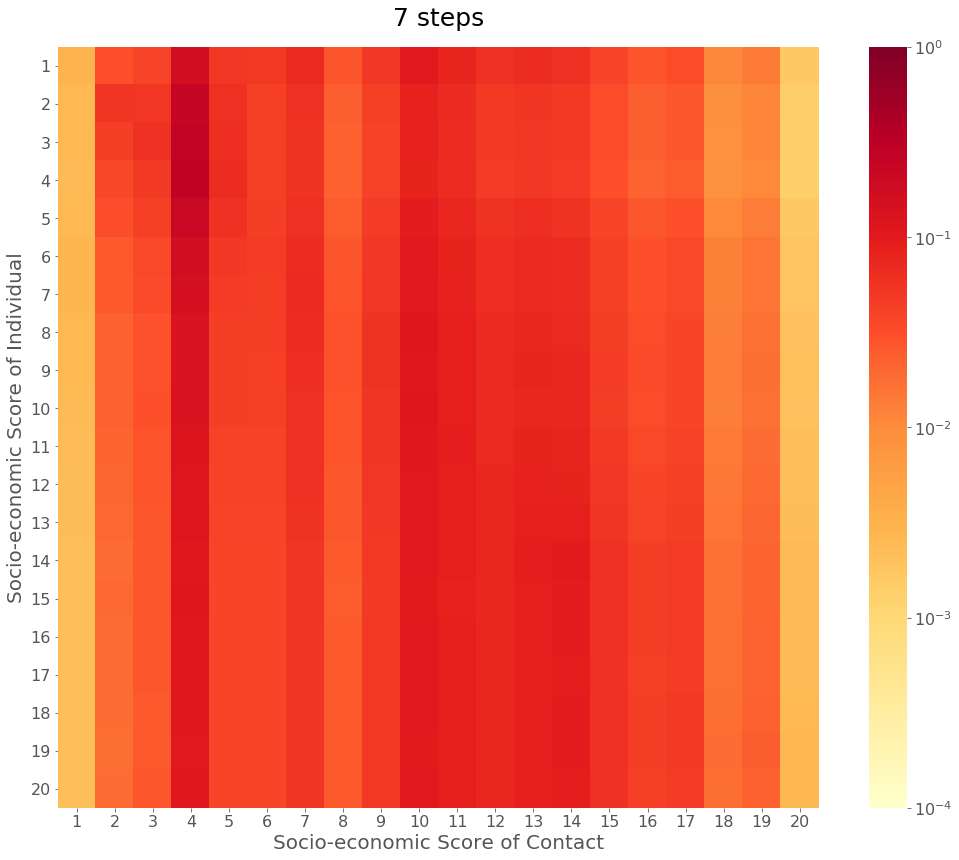

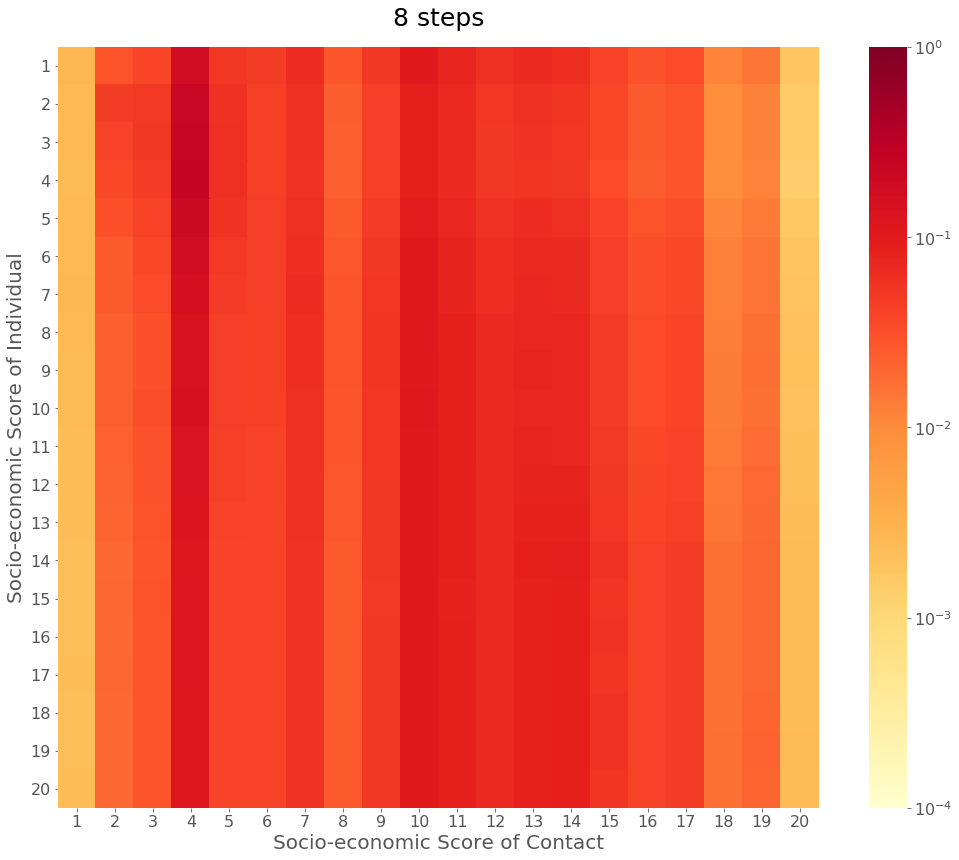

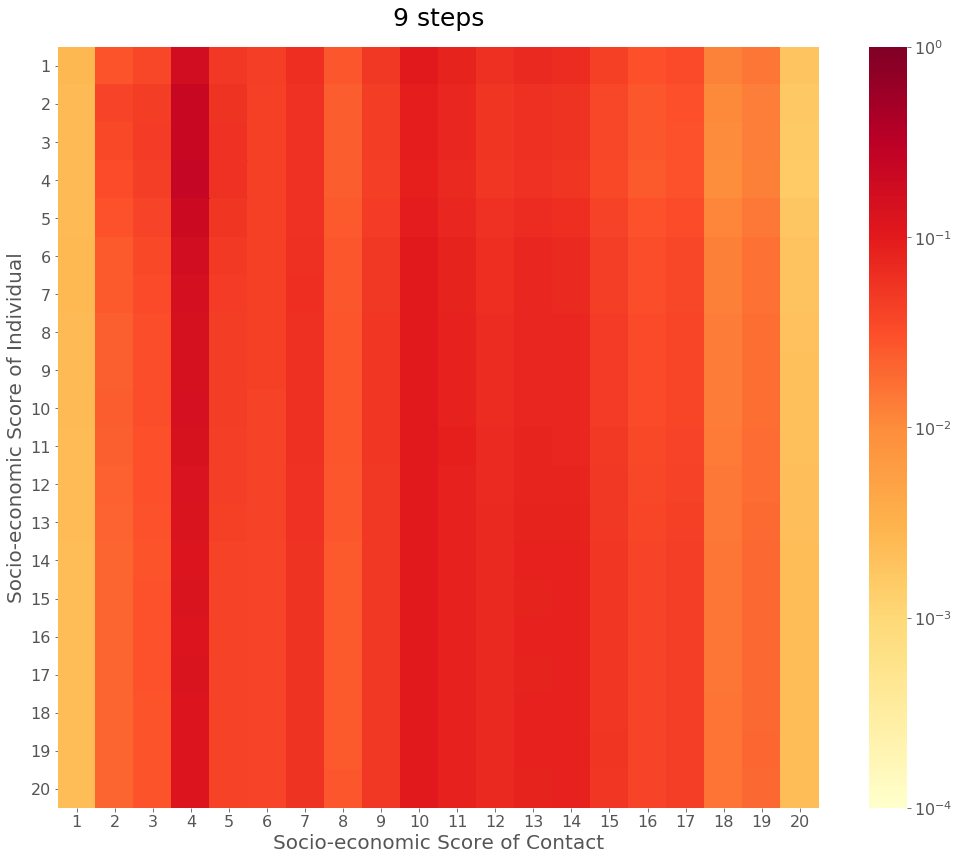

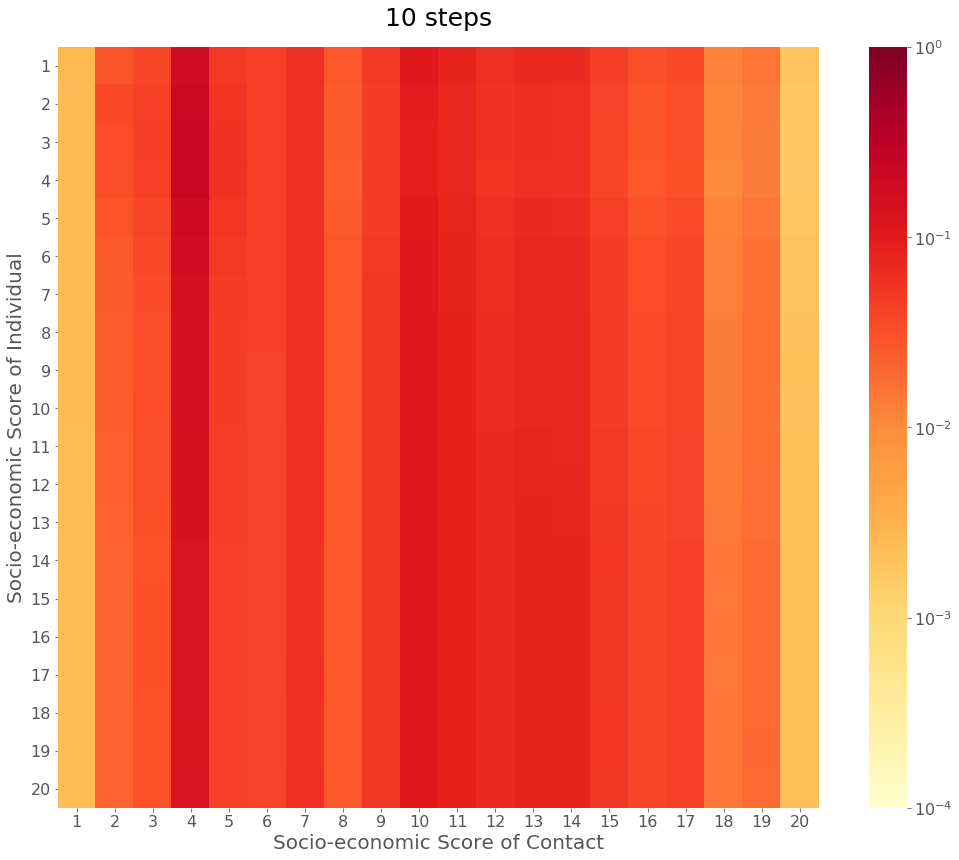

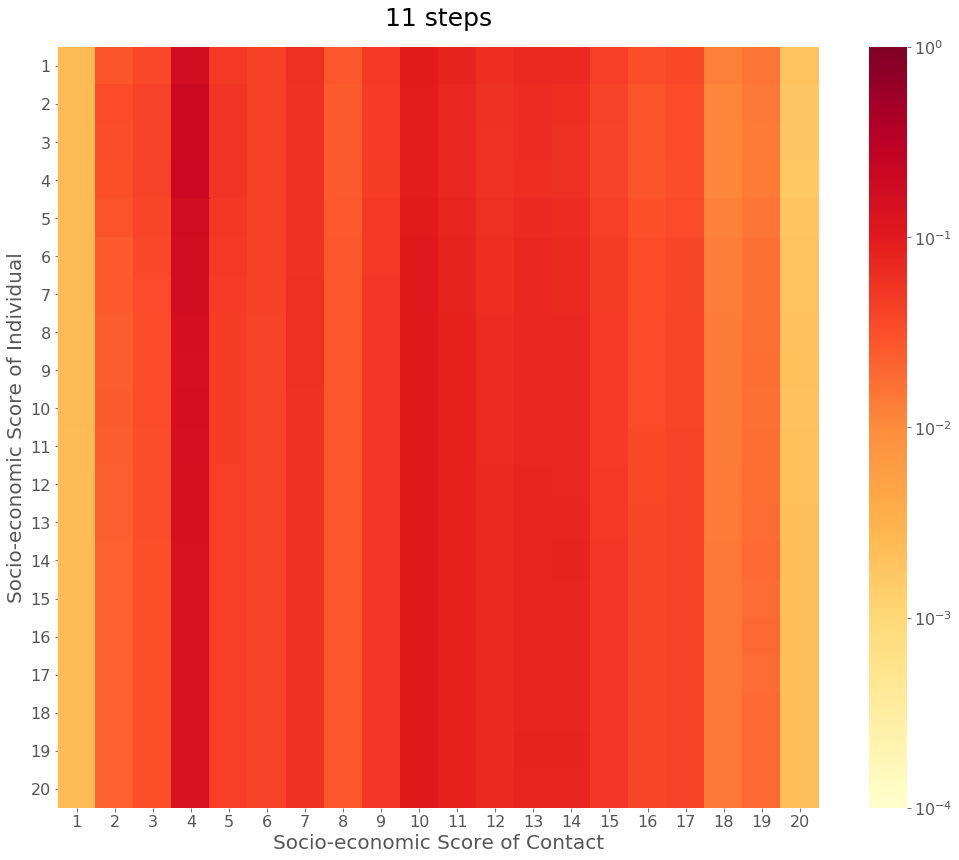

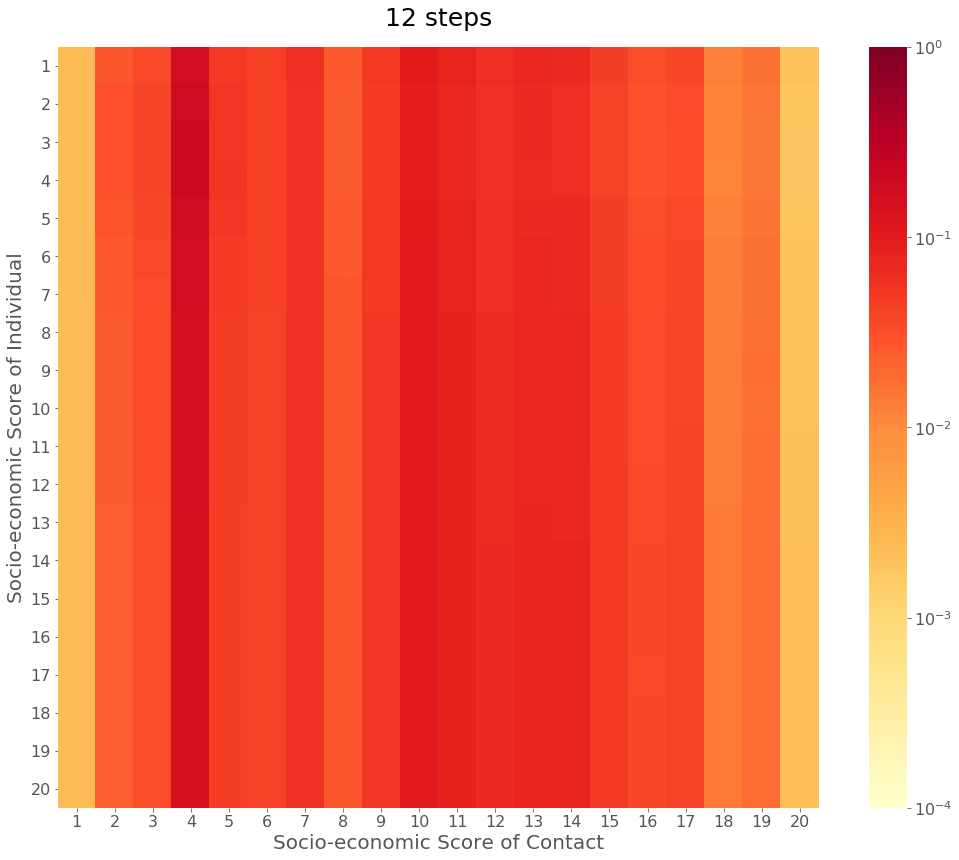

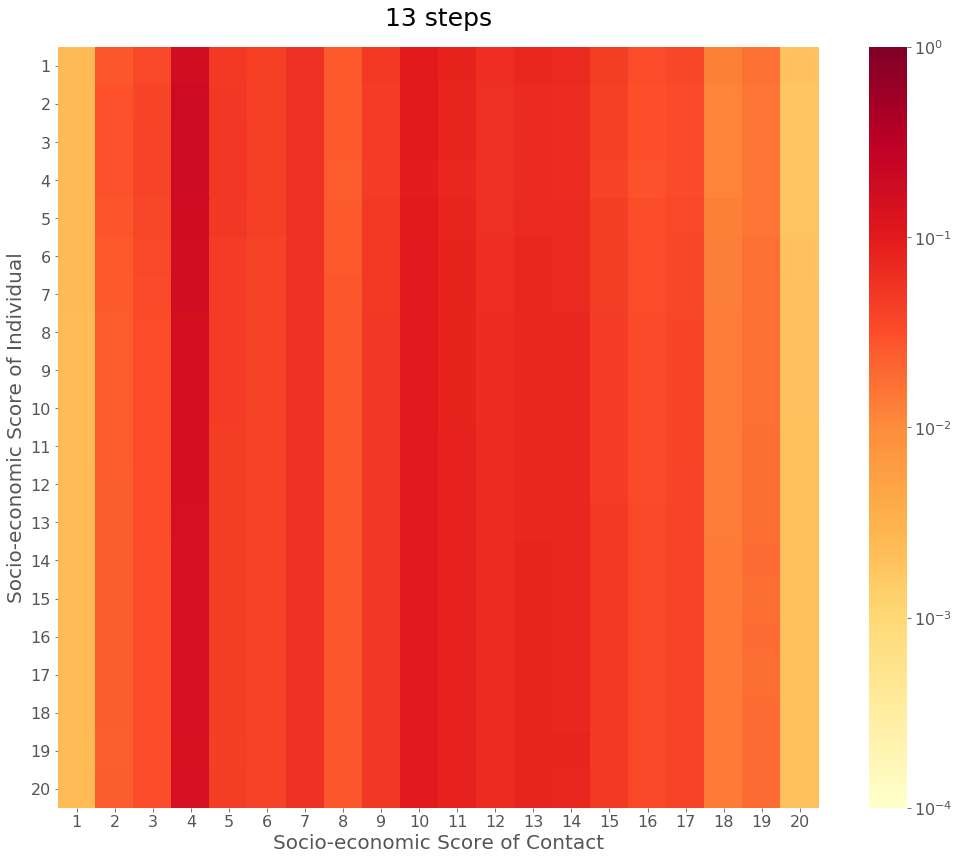

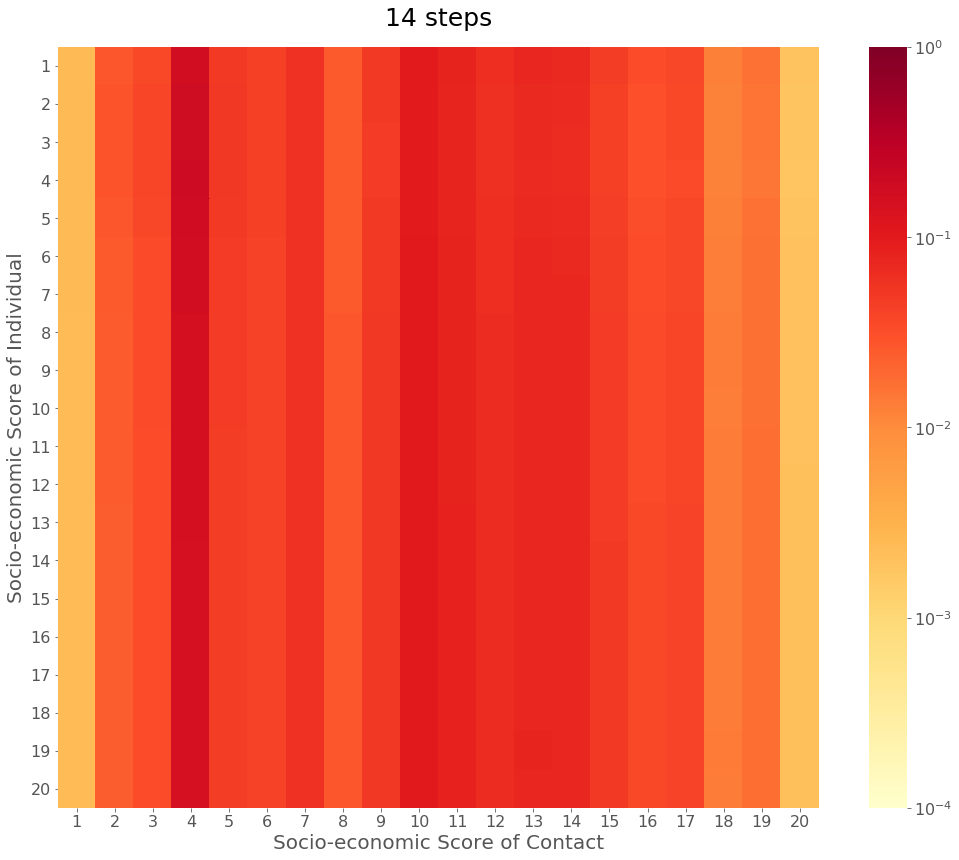

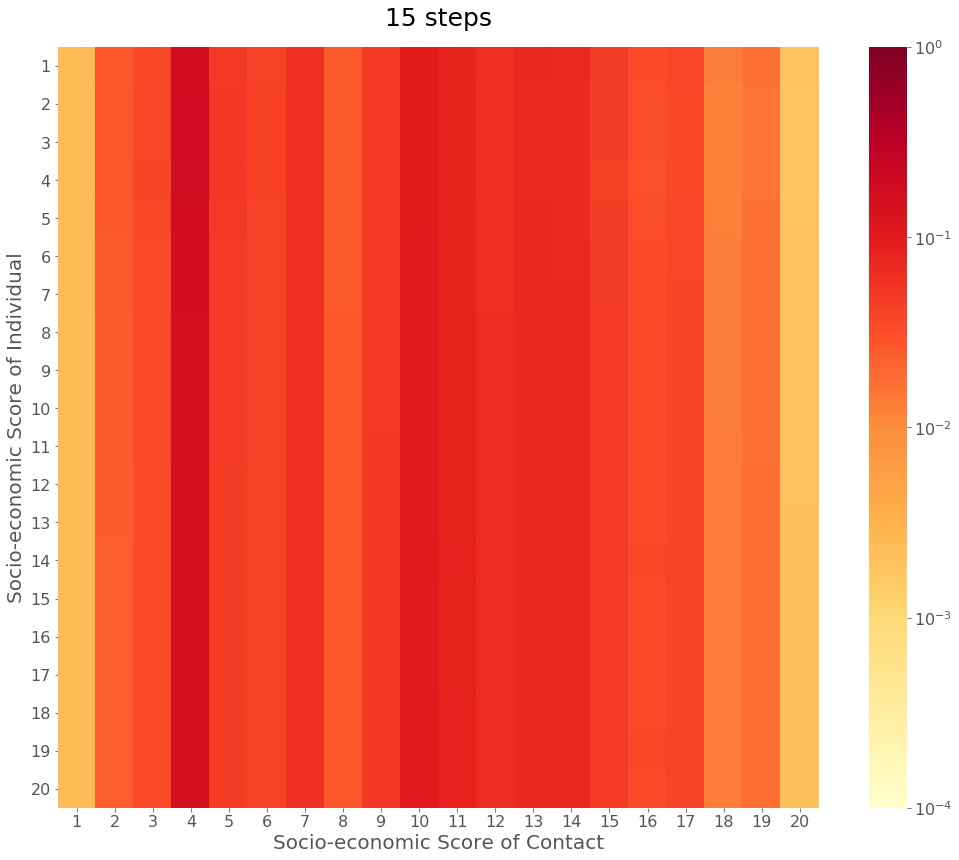

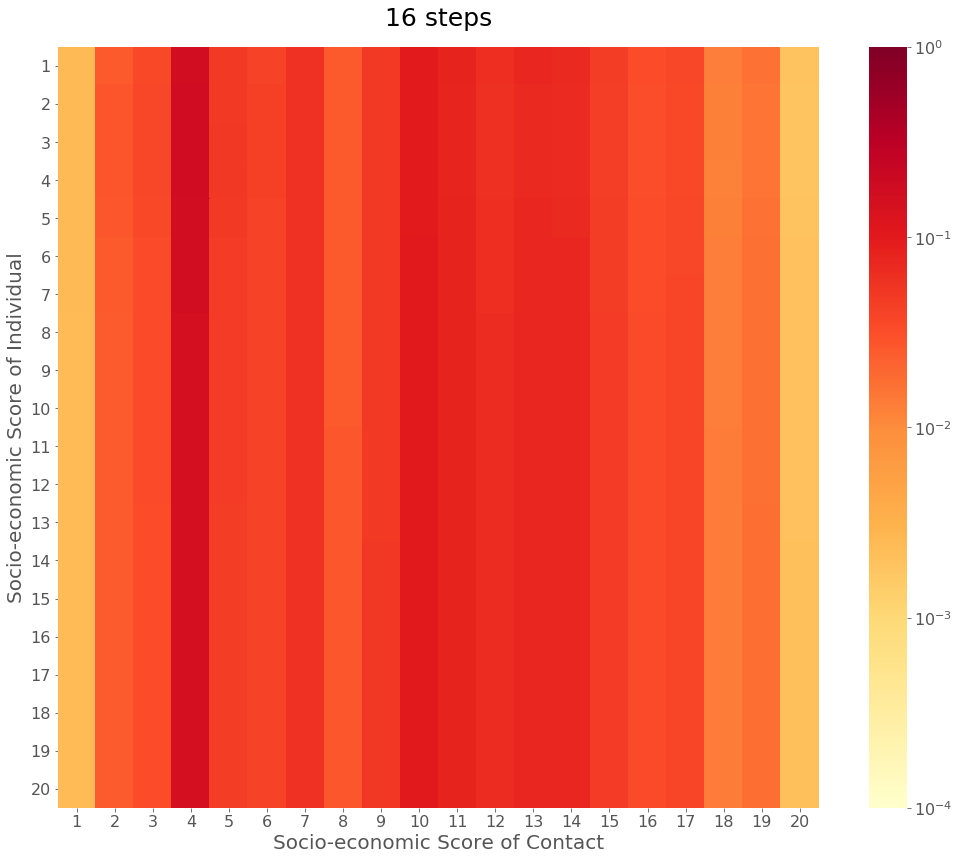

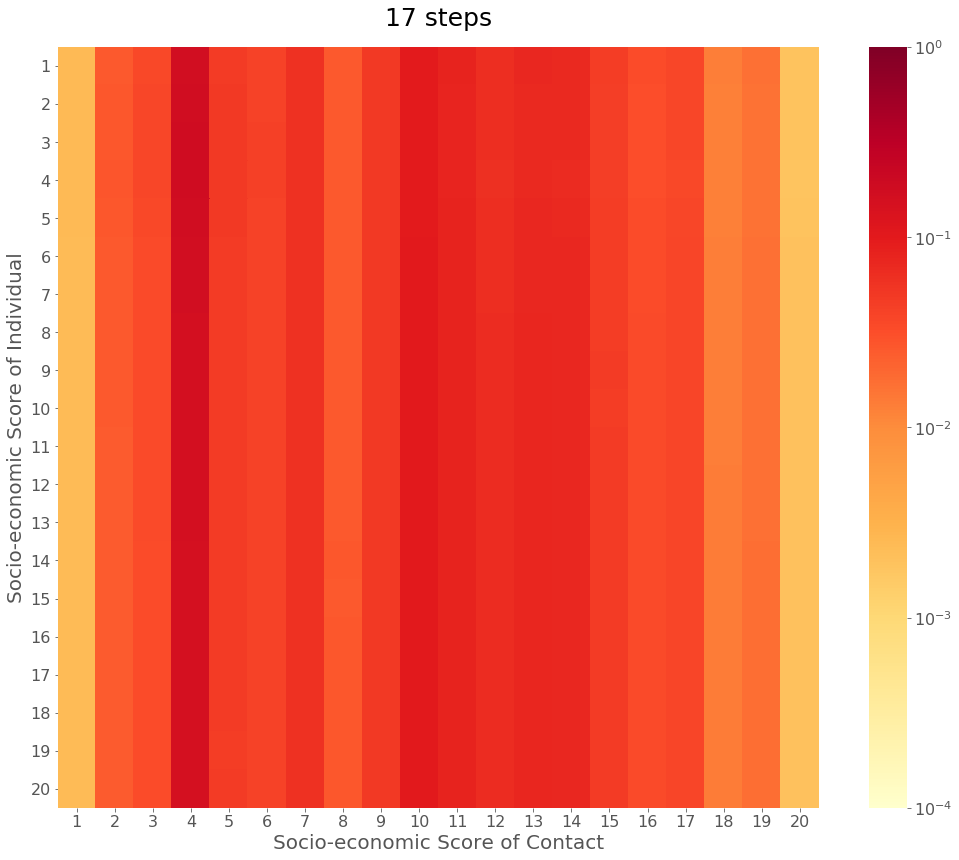

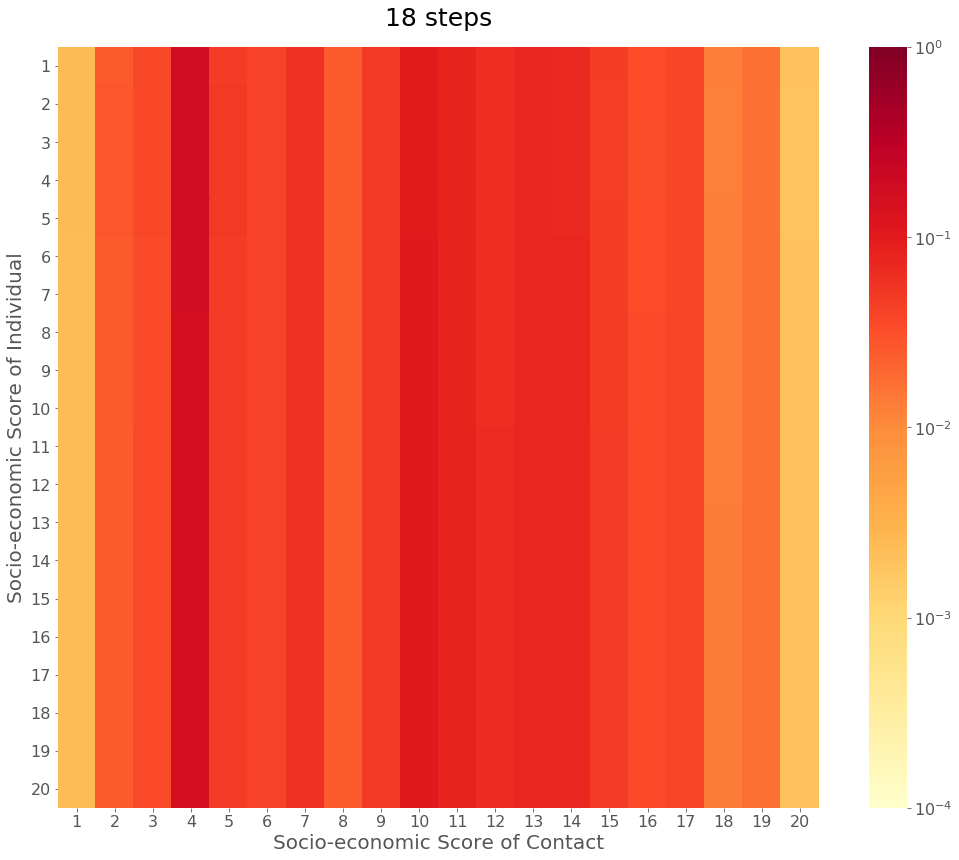

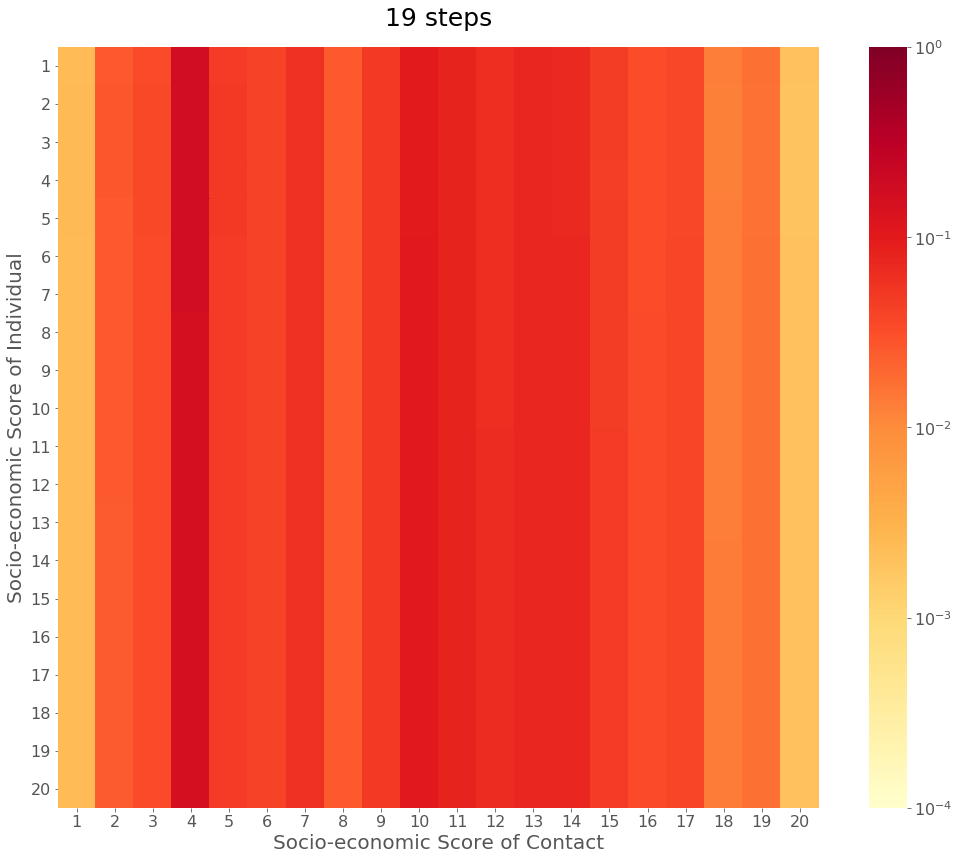

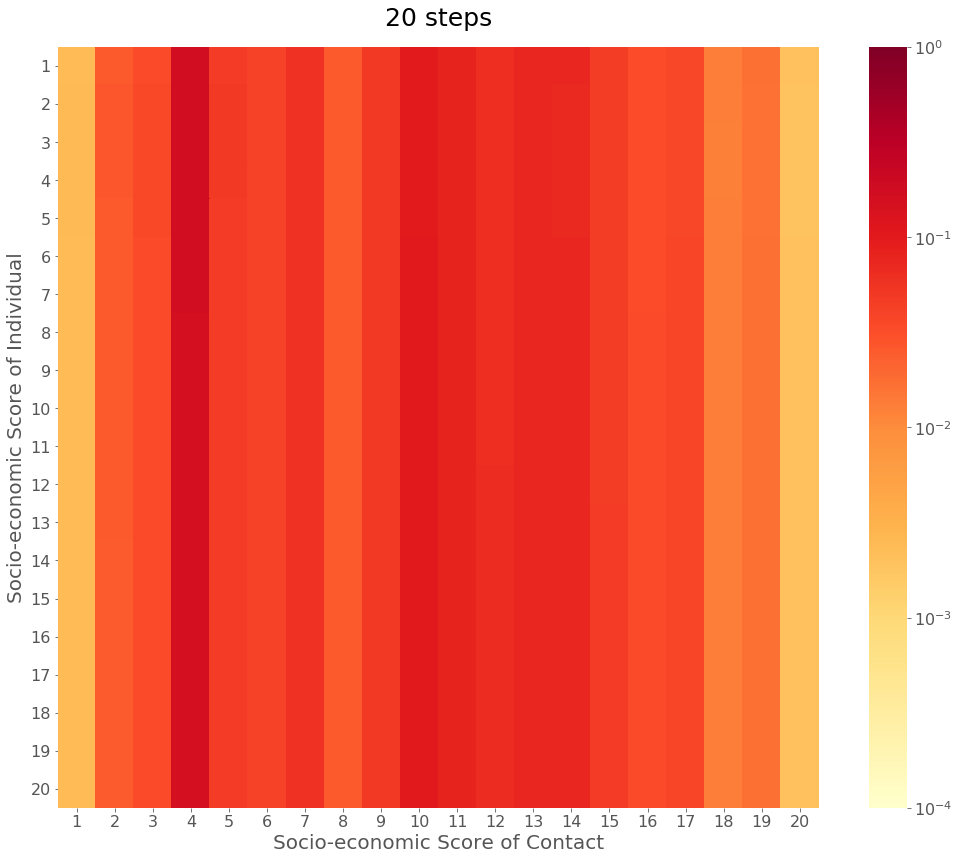

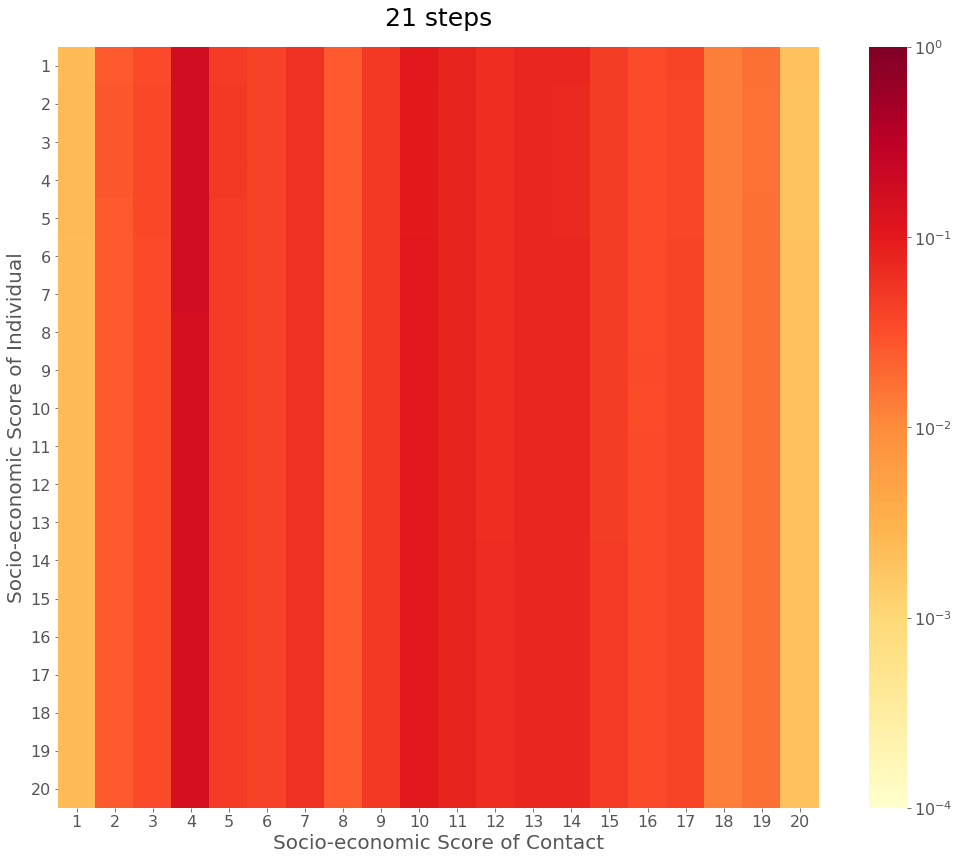

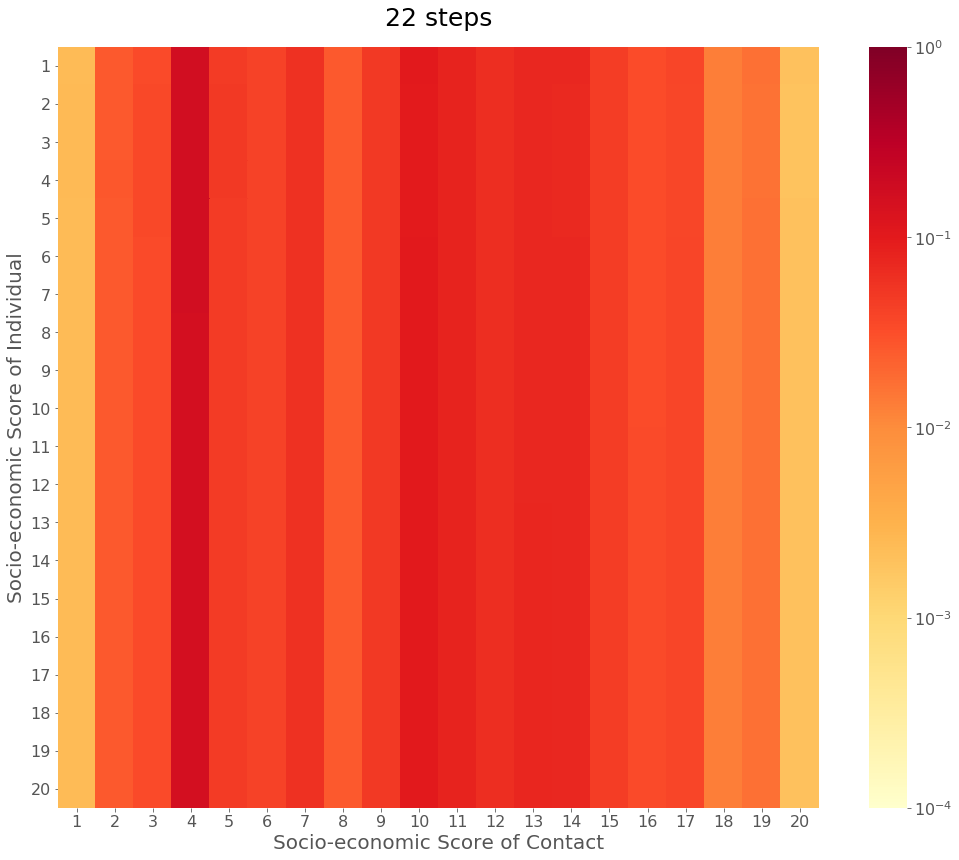

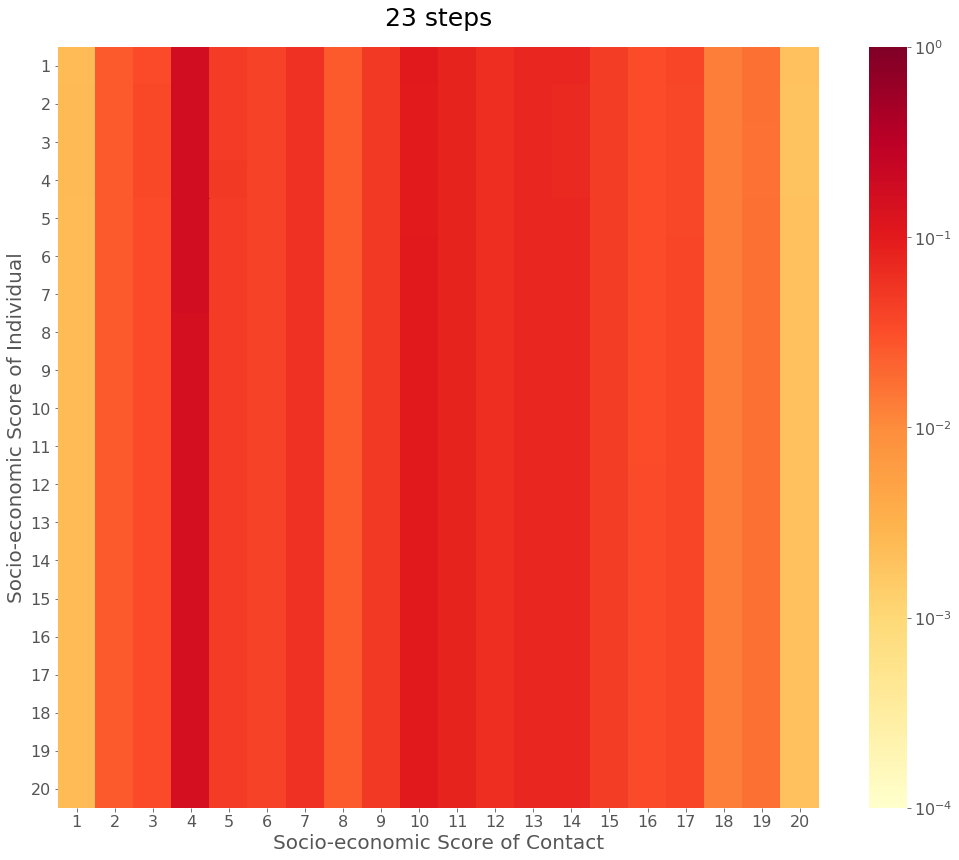

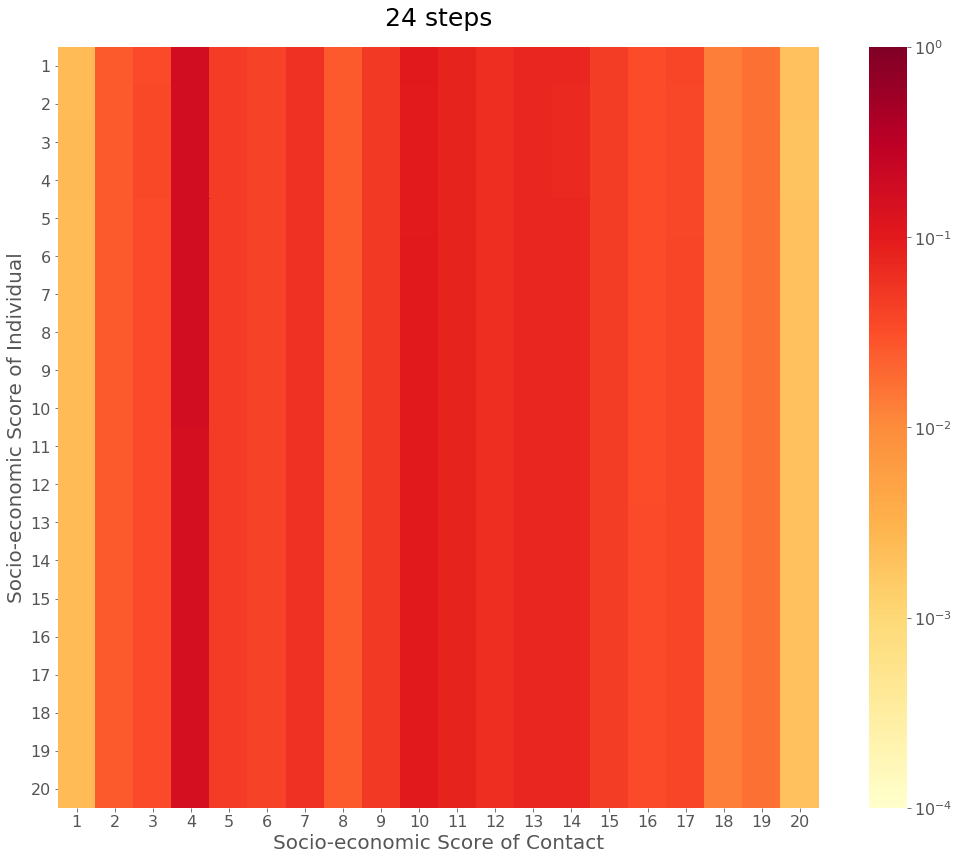

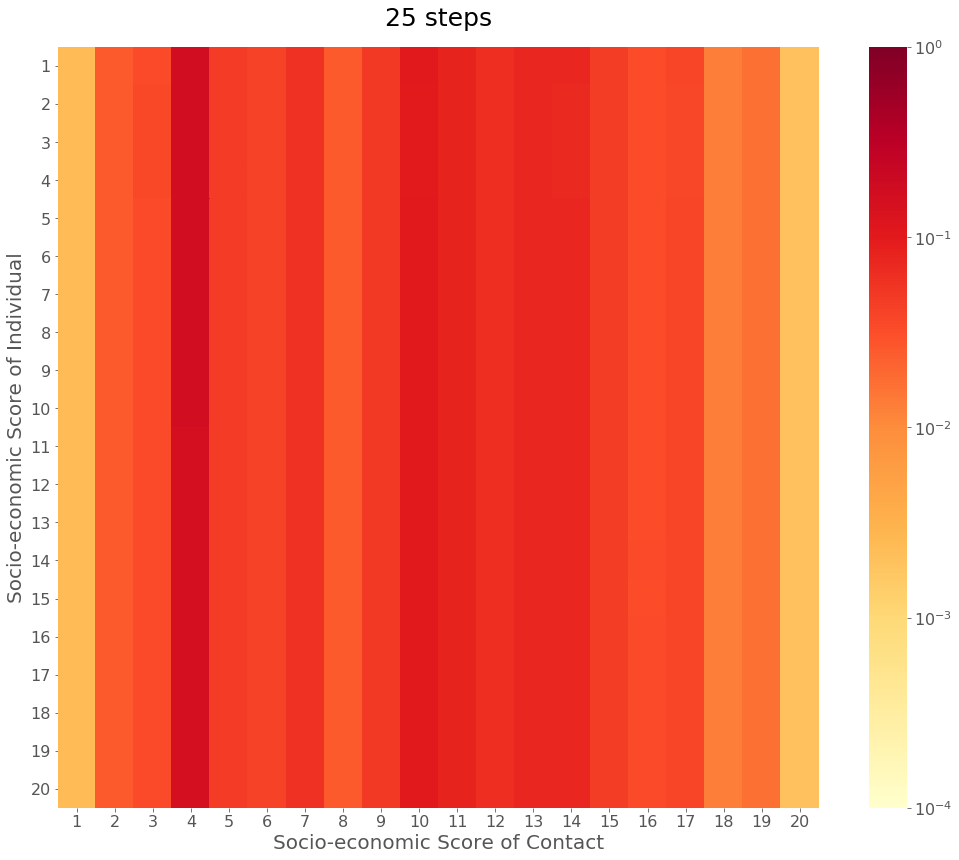

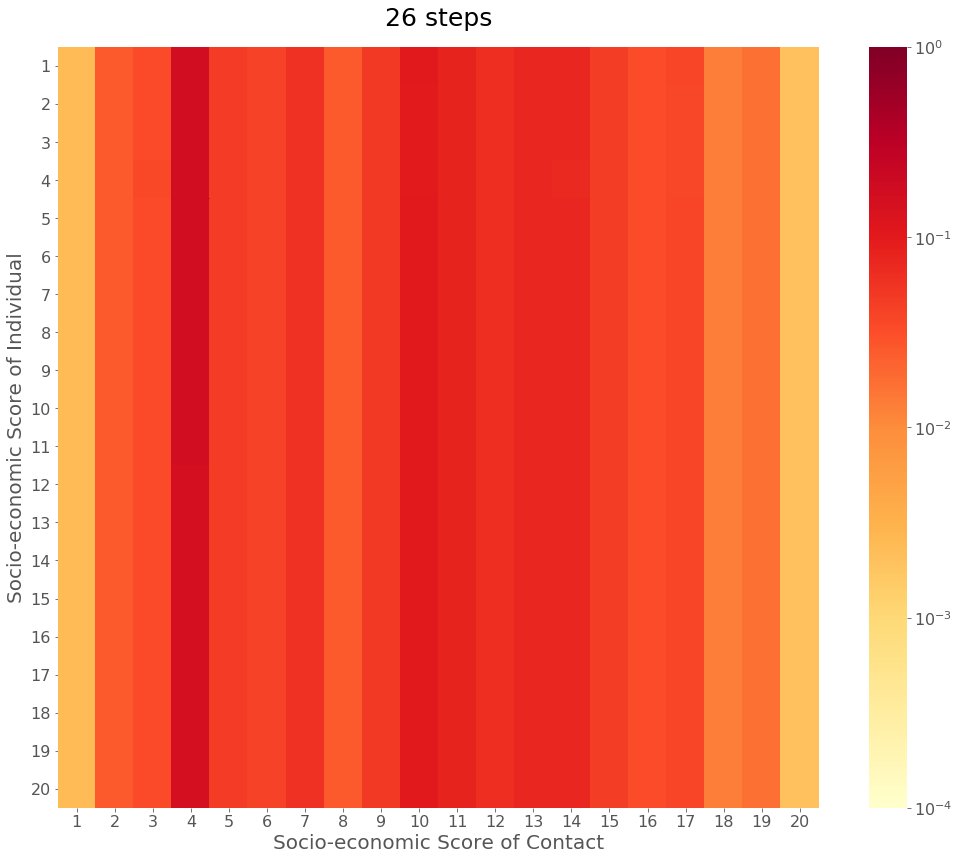

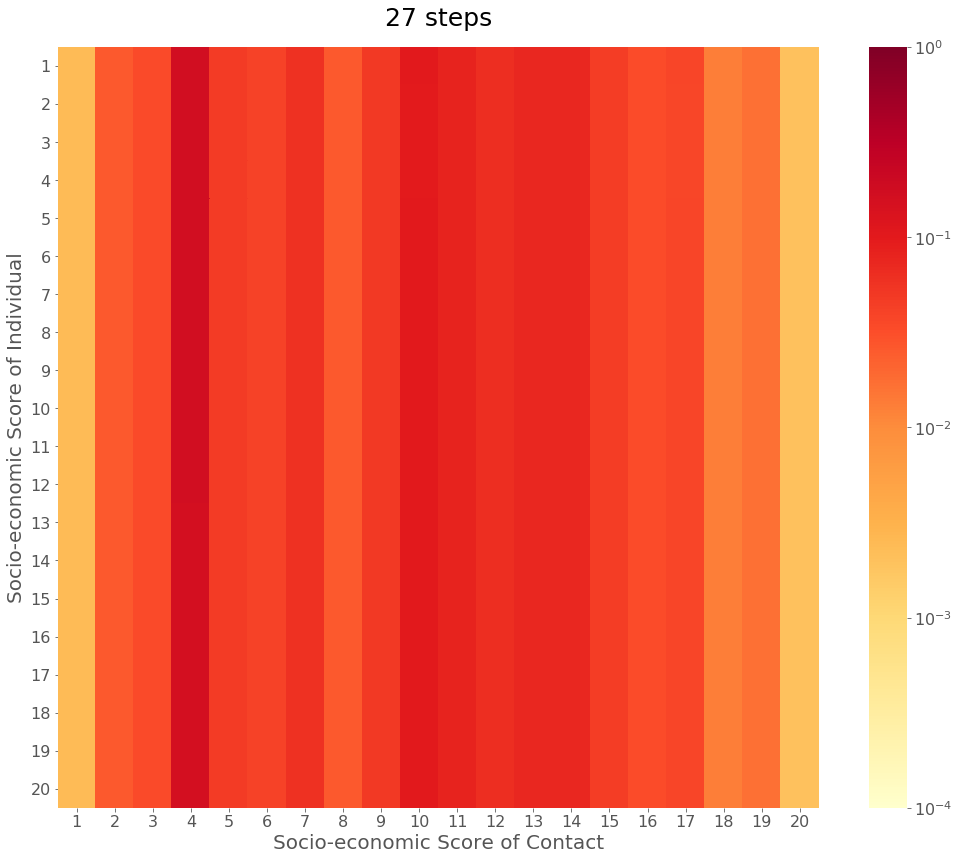

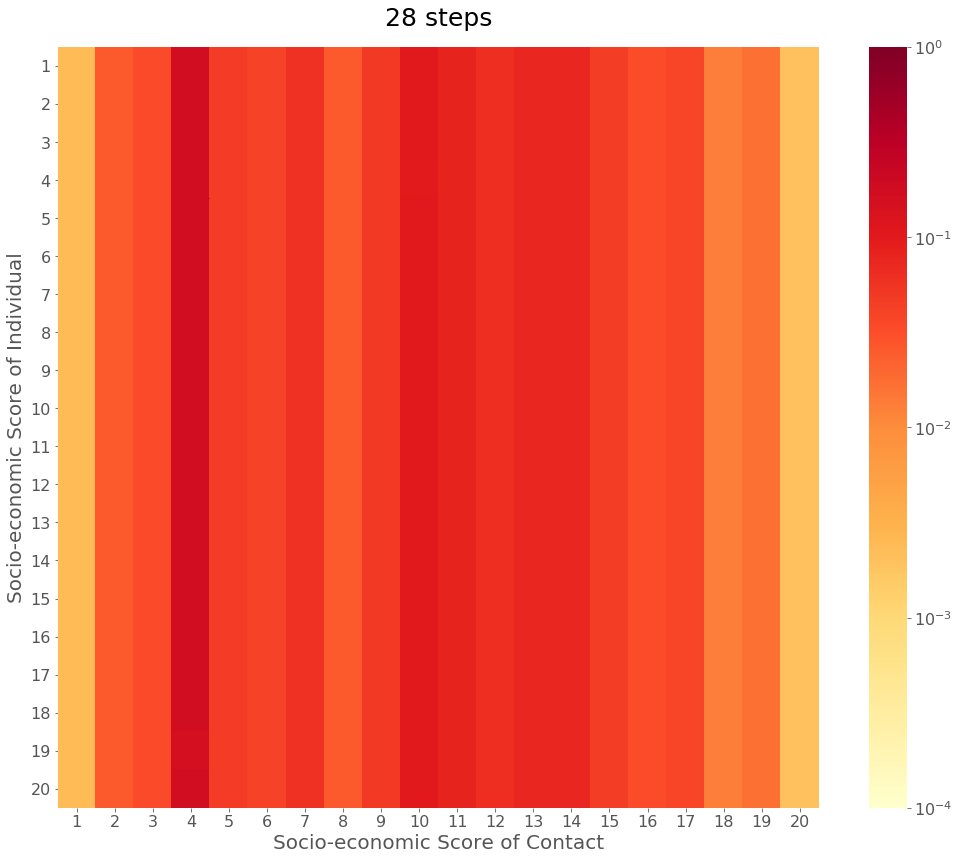

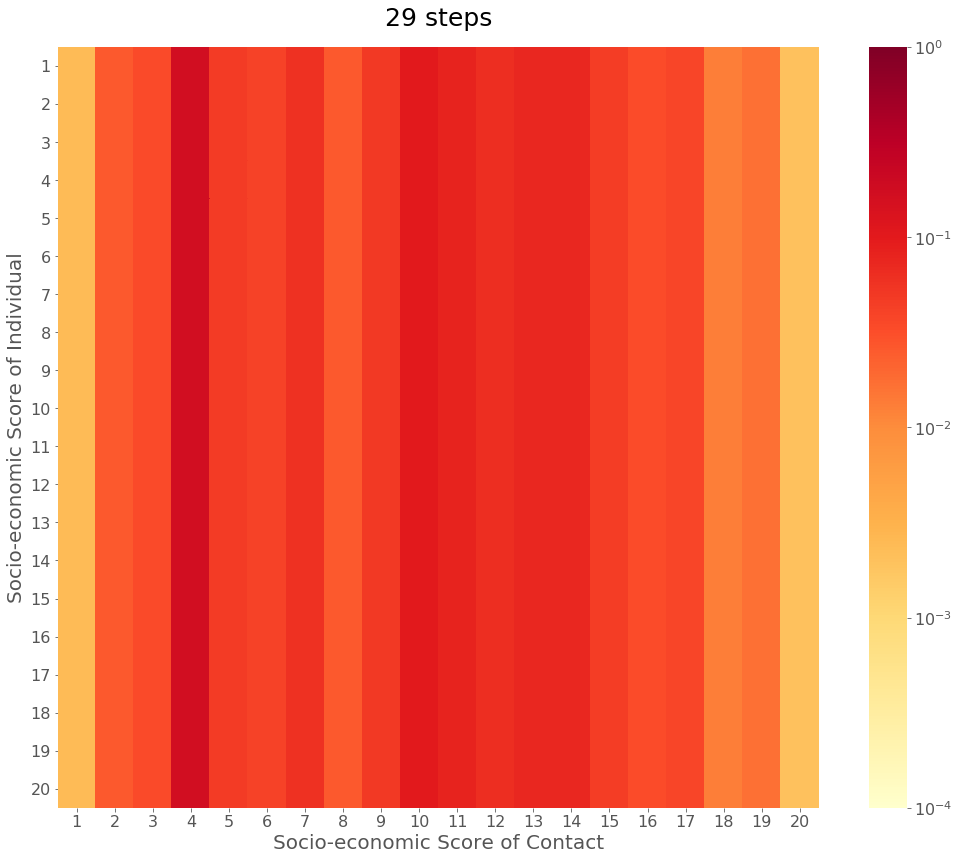

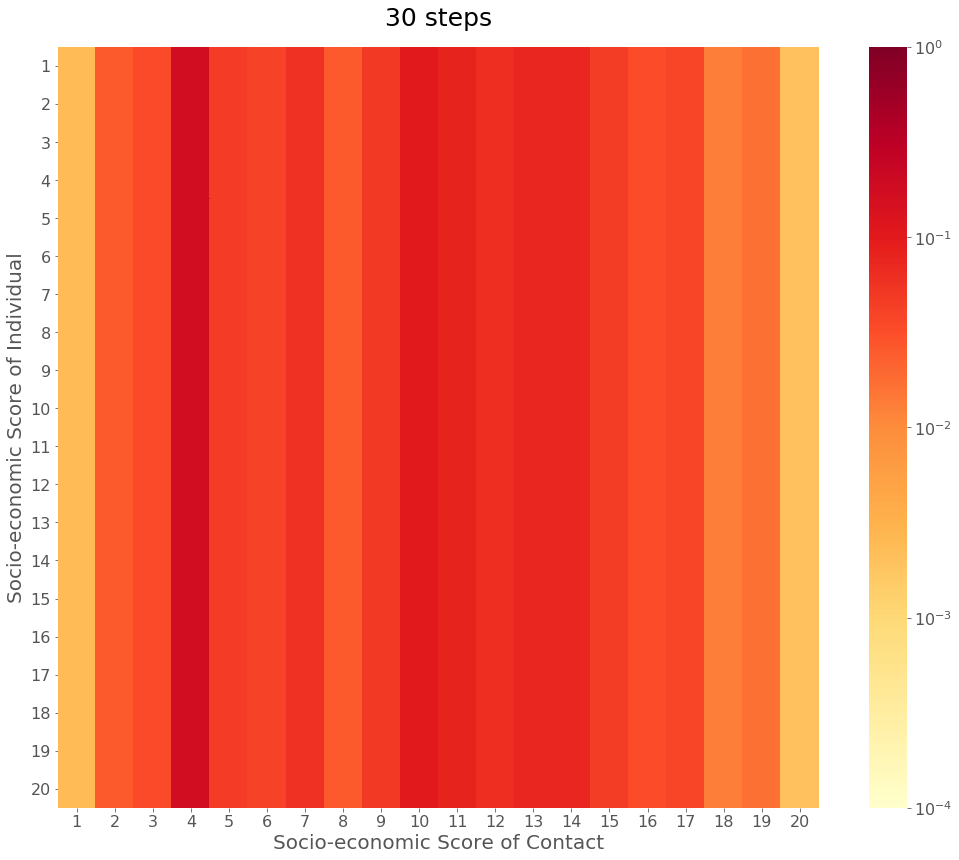

In [161]:
mat = contat_mat_soc_eco.values
steps = np.arange(1,31)

for step in steps:
    contat_mat_soc_eco_i_steps = pd.DataFrame(np.linalg.matrix_power(mat, step), columns=contat_mat_soc_eco.columns,
                                                  index=contat_mat_soc_eco.index)
    # Log transformation
    contat_mat_soc_eco_log_df = contat_mat_soc_eco_i_steps.applymap(lambda x: np.log10(x))

    fig, ax = plt.subplots(figsize=(18,14))
    ax.set_title(f'{step} steps', {'fontsize': 25, 'position': (0.5,1.02)})
    heat = sns.heatmap(contat_mat_soc_eco_log_df, ax=ax, cmap='YlOrRd', robust=False, vmin=-4, vmax=0,
                       cbar_kws={'ticks':np.linspace(-4,0, 5)}, square=True)
    
    # Axis labels
    plt.ylabel('Socio-economic Score of Individual', fontsize=20)
    plt.xlabel('Socio-economic Score of Contact', fontsize=20)

    # Color bar
    cb = fig.axes[1]
    cb.set_yticklabels([f'$10^{"{"+str(int(i))+"}"}$' for i in np.linspace(-4,0, 5)], fontsize=16)

    ax.tick_params(labelsize=16)
    plt.xticks(rotation='horizontal')
    plt.yticks(rotation='horizontal')

    if step<=9:
        plt.savefig(f'./img/socio_eco_gif/0{step}_steps_heatmap.png', bbox_inches="tight");
    else:
        plt.savefig(f'./img/socio_eco_gif/{step}_steps_heatmap.png', bbox_inches="tight");